In [1]:
import os
import sys
import errno
import re
import glob
import csv
import os.path as op
import json
import math
import re
from datetime import datetime, timedelta, date
from IPython.display import display, clear_output, HTML
import numpy as np
from pathlib import Path
import pandas as pd
from osgeo import osr, ogr, gdal
from osgeo.gdalnumeric import *
from osgeo.gdalconst import *
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.gridspec as pltg
import seaborn as sn
from matplotlib.colors import LogNorm
import calendar
import random
import pyproj
from pyproj import Proj, transform
import warnings
import rasterio
import plotly.express as px
import pickle
from rasterio.warp import calculate_default_transform , reproject, Resampling 
from rasterio.mask import mask
from rasterio.merge import merge
from shapely.geometry import mapping
from itertools import chain
import pygeoif
import fiona
import pymannkendall as mk
import statsmodels.api as sm
import statsmodels
import scipy.stats as st
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error
import geopandas as gpd
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

In [2]:
def getDateFromStr(N):
    sepList = ["","-","_","/"]
    datev = ''
    for s in sepList :
        found = re.search('\d{4}'+ s +'\d{2}'+ s +'\d{2}', N)
        if found != None :
            datev = datetime.strptime(found.group(0), '%Y'+ s +'%m'+ s +'%d').date()
            break
    return datev

def getTimeFromStr(N,):
    sepList = ["","-","_"]
    HHMMSS = ''
    for s in sepList :
        found = re.search('-'+'\d{2}'+ s +'\d{2}'+ s +'\d{2}'+'-', N)
        if found != None :
            HHMMSS = datetime.strptime(found.group(0), '-'+'%H'+ s +'%M'+ s +'%S'+'-').time()
            break
    return HHMMSS

def reproject(inEPSG,outEPSG,x1,y1):
    
    inProj = Proj(init='EPSG:' + inEPSG)
    outProj = Proj(init='EPSG:'+ outEPSG)
    x2,y2 = transform(inProj,outProj,x1,y1)
    
    return x2, y2

def getCoords(G):
    
    
    GT = G.GetGeoTransform()
    minx = GT[0]
    maxy = GT[3]
    maxx = minx + GT[1] * G.RasterXSize
    miny = maxy + GT[5] * G.RasterYSize
    
    return minx, maxy, maxx, miny

def mkdir_p(dos):
    try:
        os.makedirs(dos)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(dos):
            pass
        else:
            raise
            
def getTileFromStr(N):

    tile = ''
    found = re.search('\d{2}' +'[A-Z]{3}', N)
    if found != None : tile = found.group(0)
    return tile

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current Axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


def find_file(folder, pattern):
    """ Search recursively into a folder to find a pattern match
    """
    match = None

    for root, dirs, files in os.walk(folder):
        for file in files:
            if re.match(pattern, file):
                logging.debug("match file :%s", file)
                match = os.path.join(root, file)
                break

    return match


In [3]:
MAIN_path=f"/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/synthesis_code"
CONFIG_path=f"{MAIN_path}/configs"
LOG_path=f"{MAIN_path}/logs"
TCD_PATH = "/home/ad/barrouz/datalake/static_aux/TreeCoverDensity"
GLACIER_PATH= "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/GLACIERS"
DEM_PATH= "/home/ad/barrouz/Neige/DEM"
driver = gdal.GetDriverByName('GTiff')


In [4]:
S2_tiles={
    "PYR":
    {
        "30TXN":{'EPSG':'32630','MINX':600000,'MINY':4690200,'MAXX':709800,'MAXY':4800000},
        '30TYN':{'EPSG':'32630','MINX':699960,'MINY':4690200,'MAXX':809760,'MAXY':4800000},
        '31TCH':{'EPSG':'32631','MINX':300000,'MINY':4690200,'MAXX':409800,'MAXY':4800000},
        '31TDH':{'EPSG':'32631','MINX':399960,'MINY':4690200,'MAXX':509760,'MAXY':4800000}
    },
    "ALP":
    {
        "31TGJ":{'EPSG':'32631','MINX':699960,'MINY':4790220,'MAXX':809760,'MAXY':4900020},
        '31TGK':{'EPSG':'32631','MINX':699960,'MINY':4890240,'MAXX':809760,'MAXY':5000040},
        '31TGL':{'EPSG':'32631','MINX':699960,'MINY':4990200,'MAXX':809760,'MAXY':5100000},
        '31TGM':{'EPSG':'32631','MINX':699960,'MINY':5090220,'MAXX':809760,'MAXY':5200020},
        "32TLP":{'EPSG':'32632','MINX':300000,'MINY':4790220,'MAXX':409800,'MAXY':4900020},
        '32TLQ':{'EPSG':'32632','MINX':300000,'MINY':4890240,'MAXX':409800,'MAXY':5000040},
        '32TLR':{'EPSG':'32632','MINX':300000,'MINY':4990200,'MAXX':409800,'MAXY':5100000},
        '32TLS':{'EPSG':'32632','MINX':300000,'MINY':5090220,'MAXX':409800,'MAXY':5200020}
    }
}


epsg_list={
    "30TXN":{'EPSG':'32630'},
    '30TYN':{'EPSG':'32630'},
    '31TCH':{'EPSG':'32631'},
    '31TDH':{'EPSG':'32631'},
    "31TGJ":{'EPSG':'32631'},
    '31TGK':{'EPSG':'32631'},
    '31TGL':{'EPSG':'32631'},
    '31TGM':{'EPSG':'32631'},
    "32TLP":{'EPSG':'32632'},
    '32TLQ':{'EPSG':'32632'},
    '32TLR':{'EPSG':'32632'},
    '32TLS':{'EPSG':'32632'}
}


S2_4326_tiles={
    "PYR":
    {
        "30TXN":{'EPSG':'32630','MINX':reproject('32630','4326',600000,4690200)[0],'MINY':reproject('32630','4326',600000,4690200)[1],'MAXX':reproject('32630','4326',709800,4800000)[0],'MAXY':reproject('32630','4326',709800,4800000)[1]
                },
        '30TYN':{'EPSG':'32630','MINX':reproject('32630','4326',699960,4690200)[0],'MINY':reproject('32630','4326',699960,4690200)[1],'MAXX':reproject('32630','4326',809760,4800000)[0],'MAXY':reproject('32630','4326',809760,4800000)[1]
                },
        '31TCH':{'EPSG':'32631','MINX':reproject('32631','4326',300000,4690200)[0],'MINY':reproject('32631','4326',300000,4690200)[1],'MAXX':reproject('32631','4326',409800,4800000)[0],'MAXY':reproject('32631','4326',409800,4800000)[1]
                },
        '31TDH':{'EPSG':'32631','MINX':reproject('32631','4326',399960,4690200)[0],'MINY':reproject('32631','4326',399960,4690200)[1],'MAXX':reproject('32631','4326',509760,4800000)[0],'MAXY':reproject('32631','4326',509760,4800000)[1]
                }
    },
    "ALP":
    {
        "31TGJ":{'EPSG':'32631','MINX':reproject('32631','4326',699960,4790220)[0],'MINY':reproject('32631','4326',699960,4790220)[1],'MAXX':reproject('32631','4326',809760,4900020)[0],'MAXY':reproject('32631','4326',809760,4900020)[1]
                },
        '31TGK':{'EPSG':'32631','MINX':reproject('32631','4326',699960,4890240)[0],'MINY':reproject('32631','4326',699960,4890240)[1],'MAXX':reproject('32631','4326',809760,5000040)[0],'MAXY':reproject('32631','4326',809760,5000040)[1]
                },
        '31TGL':{'EPSG':'32631','MINX':reproject('32631','4326',699960,4990200)[0],'MINY':reproject('32631','4326',699960,4990200)[1],'MAXX':reproject('32631','4326',809760,5100000)[0],'MAXY':reproject('32631','4326',809760,5100000)[1]
                },
        '31TGM':{'EPSG':'32631','MINX':reproject('32631','4326',699960,5090220)[0],'MINY':reproject('32631','4326',699960,5090220)[1],'MAXX':reproject('32631','4326',809760,5200020)[0],'MAXY':reproject('32631','4326',809760,5200020)[1]
                },
        "32TLP":{'EPSG':'32632','MINX':reproject('32632','4326',300000,4790220)[0],'MINY':reproject('32632','4326',300000,4790220)[1],'MAXX':reproject('32632','4326',409800,4900020)[0],'MAXY':reproject('32632','4326',409800,4900020)[1]
                },
        '32TLQ':{'EPSG':'32632','MINX':reproject('32632','4326',300000,4890240)[0],'MINY':reproject('32632','4326',300000,4890240)[1],'MAXX':reproject('32632','4326',409800,5000040)[0],'MAXY':reproject('32632','4326',409800,5000040)[1]
                },
        '32TLR':{'EPSG':'32632','MINX':reproject('32632','4326',300000,4990200)[0],'MINY':reproject('32632','4326',300000,4990200)[1],'MAXX':reproject('32632','4326',409800,5100000)[0],'MAXY':reproject('32632','4326',409800,5100000)[1]
                },
        '32TLS':{'EPSG':'32632','MINX':reproject('32632','4326',300000,5090220)[0],'MINY':reproject('32632','4326',300000,5090220)[1],'MAXX':reproject('32632','4326',409800,5200020)[0],'MAXY':reproject('32632','4326',409800,5200020)[1]
                }
    }
}



LANDSAT_wrs={
    "ALP":
    {
        "195029":["31TGJ",'31TGK','31TGL',"32TLP",'32TLQ','32TLR'],
        "195028":['31TGL','31TGM','32TLQ','32TLR','32TLS'],
        "196029":["31TGJ",'31TGK','31TGL','32TLQ','32TLR'],
        "196028":['31TGK','31TGL','31TGM','32TLQ','32TLR','32TLS'],
        "194029":["32TLP",'32TLQ','32TLR']
    },
    "PYR":
    {
        "200030":["30TXN",'30TYN'],
        "199030":["30TXN",'30TYN','31TCH'],
        "198031":['31TCH','31TDH'],
        "198030":['31TCH','31TDH'],
        "197031":['31TDH']
    }
}

LANDSAT_tiles={
    "ALP":
    {
        "31TGJ":["195029","196029"],
        '31TGK':["195029","196029","196028"],
        '31TGL':["195029","195028","196029","196028"],
        '31TGM':["195028","196028"],
        "32TLP":["194029","195029"],
        '32TLQ':["194029","195029","195028","196029","196028"],
        '32TLR':["194029","195029","195028","196029","196028"],
        '32TLS':["195028","196028"]
    },
    "PYR":
    {
        "30TXN":["200030","199030"],
        '30TYN':["200030","199030"],
        '31TCH':["199030","198031","198030"],
        '31TDH':["198031","198030","197031"]
    }
}

SPOT_tile={
    "ALP":
    {"KMIN":46,
     "KMAX":55,
     "JMIN":254,
     "JMAX":263
    },
    "PYR":
    {"KMIN":35,
     "KMAX":48,
     "JMIN":262,
     "JMAX":265
    }
}

SAFRAN_tiles={
    "ALP":
    {"31TGM":["Chablais"],
     "32TLR":["Mont-Blanc","Haute-Tarentaise","Haute-Maurienne"],
     "31TGL":["Chartreuse","Aravis","Beaufortain","Vanoise","Maurienne","Bauges","Grandes-Rousses","Belledonne"],
     "31TGK":["Vercors","Oisans","Devoluy","Champsaur","Pelvoux","Embrunnais Parpaillon","Ubaye"],
     "32TLQ":["Queyras","Thabor"],
     "32TLP":["Haut-Var Haut-Verdon","Mercantour"]
     
    },
    "PYR":
    {"30TXN":["Pays-Basque","Aspe Ossau","Navarra","Jacetiana"],
     "30TYN":["Haute-Bigorre","Aure Louron","Luchonnais","Gallego","Sobrarbe","Esera"],
     "31TCH":["Couserans","Haute-Ariege","Andorre","Aran","Ribagorcana","Pallaresa","Perafita"],
     "31TDH":["Orlu St-Barthelemy","Capcir Puymorens","Cerdagne Canigou","Ter-Freser","Cadi Moixero"]
    }
}

SAFRAN_tiles_2={
    "ALP":
    {"Chablais":["31TGM"],
     "Mont-Blanc":["32TLR"],
     "Haute-Tarentaise":["32TLR"],
     "Haute-Maurienne":["32TLR"],
     "Chartreuse":["31TGL"],
     "Aravis":["31TGL","31TGM"],
     "Beaufortain":["31TGL"],
     "Vanoise":["31TGL"],
     "Maurienne":["31TGL"],
     "Bauges":["31TGL"],
     "Grandes-Rousses":["31TGL"],
     "Belledonne":["31TGL"],
     "Vercors":["31TGK","31TGL"],
     "Oisans":["31TGK"],
     "Devoluy":["31TGK"],
     "Champsaur":["31TGK"],
     "Pelvoux":["31TGK"],
     "Embrunnais Parpaillon":["31TGK"],
     "Ubaye":["31TGK"],
     "Queyras":["32TLQ"],
     "Thabor":["31TGK","31TGL"],
     "Haut-Var Haut-Verdon":["32TLP","32TLQ"],
     "Mercantour":["32TLP","32TLQ"]
     
    },
    "PYR":
    {"Pays-Basque":["30TXN"],
     "Aspe Ossau":["30TXN","30TYN"],
     "Haute-Bigorre":["30TYN"],
     "Aure Louron":["30TYN"],
     "Luchonnais":["30TYN"],
     "Couserans":["31TCH"],
     "Haute-Ariege":["31TCH"],
     "Orlu St-Barthelemy":["31TCH","31TDH"],
     "Capcir Puymorens":["31TDH"],
     "Cerdagne Canigou":["31TDH"],
     "Andorre":["31TCH"],
     "Navarra":["30TXN"],
     "Jacetiana":["30TXN","30TYN"],
     "Gallego":["30TYN"],
     "Sobrarbe":["30TYN"],
     "Esera":["30TYN"],
     "Aran":["31TCH"],
     "Ribagorcana":["31TCH"],
     "Pallaresa":["31TCH"],
     "Perafita":["31TCH"],
     "Ter-Freser":["31TDH"]
    }
}



SAFRAN_tiles_test={
    "ALP":
    {"31TGM":["Chablais"],
     "32TLR":["Mont-Blanc","Haute-Tarentaise","Haute-Maurienne"]
     
    },
    "PYR":
    {"30TXN":["Pays-Basque","Aspe Ossau","Navarra","Jacetiana"]
    }
}

In [ ]:
#generate synthesis TREX for sentinel-2 and landsat 7-8 for HY years 2015 and 2016
driver = gdal.GetDriverByName('GTiff')


margins = 15


account = "cesbio"
log_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/LOGS"
job_sh_path = "/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/synthesis_code/synthesis_job.sh"
job_common_params =  " ".join(
    [
        "-A",account,
        " --job-name={}",
        " --time=02:59:59",
        "-N","1","-n","8",
        "--mem-per-cpu=8000M",
        "-o",log_path+"/{}",
        "--export=ALL,{}",job_sh_path
    ]
)
    
config = {
    "ram": 4096,
    "nb_threads": "8",
    "log_level": "DEBUG",
    "chain_version": "None",
    "product_counter": "1"
}
for mtn in ['PYR','ALP']:
    landsat_path = f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/THEIA_SNOW/L8/{mtn}"
    dlr_path = f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/LANDSAT_QA_DLR/{mtn}_LIS"
    swh_path = f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/THEIA_SNOW/S2/{mtn}"
    for hydro_year in range(2015,2017):
        print(hydro_year)
        date1="01/09/"+str(hydro_year)
        date1s = str(hydro_year)+"0901"
        date2="31/08/"+str(hydro_year+1)
        date2s = str(hydro_year+1)+"0831"
        
        
        for tile in S2_tiles[mtn]:
            print(tile)
            landsat_p = glob.glob(os.path.join(landsat_path,tile,f"LANDSAT8-OLITIRS-XS_{hydro_year}*")) + \
            glob.glob(os.path.join(landsat_path,tile,f"LANDSAT8-OLITIRS-XS_{hydro_year+1}*"))
            dlr_p = glob.glob(os.path.join(dlr_path,f"FSC_{hydro_year}*_LE07_*")) +\
            glob.glob(os.path.join(dlr_path,f"FSC_{hydro_year+1}*_LE07_*"))
            swh_p = glob.glob(os.path.join(swh_path,tile,f"SENTINEL2?_{hydro_year}*")) + \
            glob.glob(os.path.join(swh_path,tile,f"SENTINEL2?_{hydro_year+1}*")) 
            
            swh_list_year = []
            for f in swh_p:
                fscdate = getDateFromStr(f)
                if fscdate >= date(hydro_year,9,1) - timedelta(days=margins) and fscdate <= date(hydro_year+1,8,31) + timedelta(days=margins):
                    swh_list_year.append(f)

            print(swh_list_year)   
            
            list_date = []
            landsat_list_year = []
            for f in landsat_p:
                fscdate = getDateFromStr(f)
                if fscdate >= date(hydro_year,9,1) - timedelta(days=margins)  and fscdate <= date(hydro_year+1,8,31) + timedelta(days=margins) :
                    landsat_list_year.append(f)
                    list_date.append(fscdate)

            
            for product in dlr_p:

                wrs = product[-6:]
                if wrs in LANDSAT_tiles[mtn][tile]:
                    fscdate = getDateFromStr(product)
  
                    if fscdate >= date(hydro_year,9,1) - timedelta(days=margins)  and fscdate <= date(hydro_year+1,8,31) + timedelta(days=margins) and fscdate not in list_date :
                        landsat_list_year.append(product)


            print(landsat_list_year) 
            




            config["tile_id"]=tile
            config["date_start"]=date1
            config["date_stop"]=date2
            config["output_dates_filename"]= f"{date1s}_{date2s}_{tile}.txt"
            config["date_margin"]=margins

            


            #with swh and landsat
            config["input_products_list"]= swh_list_year 
            config["densification_products_list"]= landsat_list_year
            config["config_file"]= f"{CONFIG_path}/swh_landsat_{date1s}_{date2s}_{tile}.json"
            config["output_dir"]= f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/THEIA_MARGIN_15D_S2L8L7/{mtn}/{tile}/MULTISAT_{date1s}_{date2s}_{tile}"
            json_object = json.dumps(config, indent=4)
            with open(config["config_file"], "w") as outfile:
                outfile.write(json_object)
            jobname=f"{mtn}_swh_landsat_{date1s}_{date2s}_{tile}"
            
            
            
            
            export =  ",".join([ f"config=\"{config['config_file']}\",out=\"{config['output_dir']}\""])
            os.system("sbatch "+job_common_params.format(jobname,jobname+".log",export))  
            
            
            
            
            
              



In [ ]:
#generate synthesis TREX for SWH and dlr for HY 1986-2014
driver = gdal.GetDriverByName('GTiff')
margins = 30
add_zeros = False
model = "TCD-BLUE_AVG-1200"
account = "cesbio"
log_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/LOGS"
job_sh_path = "/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/synthesis_code/synthesis_job.sh"
job_common_params =  " ".join(
    [
        "-A",account,
        " --job-name={}",
        " --time=01:59:59",
        "-N","1","-n","8",
        "--mem-per-cpu=8000M",
        "-o",log_path+"/{}",
        "--export=ALL,{}",job_sh_path
    ]
)
    
config = {
    "ram": 4096,
    "nb_threads": "8",
    "log_level": "INFO",
    "chain_version": "None",
    "product_counter": "1"
}
for mtn in ['ALP','PYR']:
    landsat_path = f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/LANDSAT_QA_DLR/{mtn}_LIS"
    swh_path = f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SWH_INFERENCE/{model}/{mtn}"
    for hydro_year in range(1986,2015):
        print(hydro_year)
        date1="01/09/"+str(hydro_year)
        date1s = str(hydro_year)+"0901"
        date2="31/08/"+str(hydro_year+1)
        date2s = str(hydro_year+1)+"0831"
        
        landsat_p = glob.glob(os.path.join(landsat_path,f"FSC_{hydro_year}*")) + glob.glob(os.path.join(landsat_path,f"FSC_{hydro_year+1}*"))
        for tile in S2_tiles[mtn]:
            print(tile)
            swh_p = glob.glob(os.path.join(swh_path,"SPOT*",f"{hydro_year}",'*','*','*',tile,f"FSC_*{tile}"),recursive=True) + \
            glob.glob(os.path.join(swh_path,"SPOT*",f"{hydro_year+1}",'*','*','*',tile,f"FSC_*{tile}"),recursive=True) 
            
            swh_list_year = []
            for f in swh_p:
                fscdate = getDateFromStr(f)
                if fscdate >= date(hydro_year,9,1) - timedelta(days=margins) and fscdate <= date(hydro_year+1,8,31) + timedelta(days=margins):
                    swh_list_year.append(f)

            print(swh_list_year)   
            landsat_list_year = [] 
            
            for product in landsat_p:
                wrs = product[-6:]
                if wrs in LANDSAT_tiles[mtn][tile]:
                    fscdate = getDateFromStr(product)
                    if fscdate >= date(hydro_year,9,1) - timedelta(days=margins) and fscdate <= date(hydro_year+1,8,31) + timedelta(days=margins):
                        landsat_list_year.append(product)
            print(landsat_list_year) 

            #generate nodata starter map for when no swh in synthesis
            if len(swh_list_year) == 0:
                nd_path = os.path.join(f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/NODATA/{tile}/",f"FSC_{str(hydro_year)}0901T000000_NODATA_{tile}")
                swh_list_year = [nd_path]
                if not os.path.exists(nd_path):
                    nodata_array = np.ones((5490,5490))*255
                    mkdir_p(nd_path)
                    outDs = driver.Create(os.path.join(nd_path,f"FSC_{str(hydro_year)}0901T000000_NODATA_{tile}_FSCTOC.tif"),  5490, 5490 , 1, gdal.GDT_Byte)
                    geotransform = ([S2_tiles[mtn][tile]['MINX'], 20, 0, S2_tiles[mtn][tile]['MAXY'], 0, -20 ])
                    outBand = outDs.GetRasterBand(1)
                    outBand.WriteArray(nodata_array)
                    outDs.SetGeoTransform(geotransform) 
                    srs = osr.SpatialReference()
                    srs.ImportFromEPSG(int(S2_tiles[mtn][tile]['EPSG']))
                    outDs.SetProjection(srs.ExportToWkt())
                    outDs.FlushCache()    



            #add zero image at start and end
            if add_zeros:
                zero_path_first = os.path.join(f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/NODATA/{tile}/",f"FSC_{str(hydro_year)}0831T000000_ZERO_{tile}")
                zero_tif_first = os.path.join(zero_path_first,f"FSC_{str(hydro_year)}0831T000000_ZERO_{tile}_FSCTOC.tif")
                if not os.path.exists(zero_tif_first):
                    mkdir_p(zero_path_first)
                    zero_array = np.zeros((5490,5490))
                    outDs = driver.Create(zero_tif_first,  5490, 5490 , 1, gdal.GDT_Byte)
                    geotransform = ([S2_tiles[mtn][tile]['MINX'], 20, 0, S2_tiles[mtn][tile]['MAXY'], 0, -20 ])
                    outBand = outDs.GetRasterBand(1)
                    outBand.WriteArray(zero_array)
                    outDs.SetGeoTransform(geotransform) 
                    srs = osr.SpatialReference()
                    srs.ImportFromEPSG(int(S2_tiles[mtn][tile]['EPSG']))
                    outDs.SetProjection(srs.ExportToWkt())
                    outDs.FlushCache()   


                zero_path_last = os.path.join(f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/NODATA/{tile}/",f"FSC_{str(hydro_year+1)}0901T000000_ZERO_{tile}")
                zero_tif_last = os.path.join(zero_path_last,f"FSC_{str(hydro_year+1)}0901T000000_ZERO_{tile}_FSCTOC.tif")
                if not os.path.exists(zero_tif_last):
                    zero_array = np.zeros((5490,5490))
                    mkdir_p(zero_path_last)
                    outDs = driver.Create(zero_tif_last,  5490, 5490 , 1, gdal.GDT_Byte)
                    geotransform = ([S2_tiles[mtn][tile]['MINX'], 20, 0, S2_tiles[mtn][tile]['MAXY'], 0, -20 ])
                    outBand = outDs.GetRasterBand(1)
                    outBand.WriteArray(zero_array)
                    outDs.SetGeoTransform(geotransform) 
                    srs = osr.SpatialReference()
                    srs.ImportFromEPSG(int(S2_tiles[mtn][tile]['EPSG']))
                    outDs.SetProjection(srs.ExportToWkt())
                    outDs.FlushCache()   





            config["tile_id"]=tile
            config["date_start"]=date1
            config["date_stop"]=date2
            config["output_dates_filename"]= f"{date1s}_{date2s}_{tile}.txt"
            config["date_margin"]=margins

            


            #with swh and landsat
            config["input_products_list"]= swh_list_year #+ [zero_path_first,zero_path_last]
            config["densification_products_list"]= landsat_list_year
            config["config_file"]= f"{CONFIG_path}/swh_landsat_{date1s}_{date2s}_{tile}.json"
            config["output_dir"]= f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/LANDSAT_SWH_MARGIN_1M/{model}/{mtn}/{tile}/LANDSAT_SWH_{date1s}_{date2s}_{tile}"
            json_object = json.dumps(config, indent=4)
            with open(config["config_file"], "w") as outfile:
                outfile.write(json_object)
            jobname=f"{mtn}_swh_landsat_{date1s}_{date2s}_{tile}_{model}"
            
            
            
            
            export =  ",".join([ f"config=\"{config['config_file']}\",out=\"{config['output_dir']}\""])
            os.system("sbatch "+job_common_params.format(jobname,jobname+".log",export))  
            
            
            
            
            
              



In [ ]:
#remove tmp dir from completed synthesis
p = f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/TEST2"
for product in glob.glob(os.path.join(p,"**","LANDSAT_*"),recursive=True):
    #print(product)
    list_f = os.listdir(product)
    if len(list_f) > 7:
        print(product)
        os.system("rm -rf "+os.path.join(product,"tmp"))

In [ ]:
# generate insitu SMOD dataframe with cols ID, NAME, ALT, LON, LAT, MODEL, SAFRAN, NOBS, SMOD, ΔNOBS, ΔSMOD, YEAR
#with MODEL = LANDSAT, TCD-ONLY, TCD-BLUE, TCD-CIRRUS-BLUE 

def precision_and_scale(x):
    max_digits = 14
    int_part = int(abs(x))
    magnitude = 1 if int_part == 0 else int(math.log10(int_part)) + 1
    if magnitude >= max_digits:
        return (magnitude, 0)
    frac_part = abs(x) - int_part
    multiplier = 10 ** (max_digits - magnitude)
    frac_digits = multiplier + int(multiplier * frac_part + 0.5)
    while frac_digits % 10 == 0:
        frac_digits /= 10
    scale = int(math.log10(frac_digits))
    return (magnitude,scale)



path_insitu_smod = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/INSITU/STATIONS"
path_synthesis = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS"
TCD_PATH = "/home/ad/barrouz/datalake/static_aux/TreeCoverDensity"
GLACIER_PATH= "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/GLACIERS"
SAFRAN_PATH = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SAFRAN/massifs_WGS84.shp"
models = ["TCD-BLUE_AVG-1200"]#,"TCD-ONLY_AVG-1200","TCD-CIRRUS-BLUE_AVG-1200"]
min_depth_list = [1] #cm snow depth

drv = ogr.GetDriverByName( 'ESRI Shapefile' )
safran_shp = drv.Open(SAFRAN_PATH)
layer_safran = safran_shp.GetLayer()
featureCount = layer_safran.GetFeatureCount()
print( "Number of features in ", os.path.basename(SAFRAN_PATH),featureCount)
#get list of doublon

list_double = []
dict_sort = {}
with open(os.path.join(path_insitu_smod,"insitu_meta.csv"), "r") as metafile:
    reader_meta = list(csv.reader(metafile))
    length = len(reader_meta)#number of lines (stations) with header
    for i in range(1,length): #start from first row after header
        station_id = reader_meta[i][0]
        station_name = reader_meta[i][1]
        station_lat = round(float(reader_meta[i][2]),6)
        station_lon = round(float(reader_meta[i][3]),6)
        if (station_lon,station_lat) not in dict_sort:
            dict_sort[(station_lon,station_lat)] = []
        dict_sort[(station_lon,station_lat)].append(station_name)
for (station_lon,station_lat) in dict_sort:
    if len(dict_sort[(station_lon,station_lat)]) > 1:
        for n in dict_sort[(station_lon,station_lat)]:
            list_double.append(n)
print(sorted(list_double),len(list_double))
dict_insitu_synth={'ID':[],'NAME':[],'MIN_DEPTH':[],'SAFRAN':[],'HYDRO_YEAR':[],'TCD':[],'TILE':[],'MODEL':[],'CONTRIB_SWH':[],
                   'ALT':[],'LON_PREC':[],'LAT_PREC':[],'LON':[],'LAT':[],
                   'SCD':[], 'ΔSCD':[],'CSCD':[], 'ΔCSCD':[],'INSITU_SCD':[],'INSITU_CSCD':[], 
                   'SOD':[],'ΔSOD':[],'INSITU_SOD':[],'INSITU_SOD_PREC':[],
                   'SMOD':[],'ΔSMOD':[],'INSITU_SMOD':[],'INSITU_SMOD_PREC':[],
                   'ΔNOBS':[],'NOBS':[],'INSITU_NOBS':[],'ABLATION_NOBS':[],
                   }
#read insitu csv
for depth in min_depth_list:
    print("min_depth:",depth)
    with open(os.path.join(path_insitu_smod,"insitu_meta.csv"), "r") as metafile, \
    open(os.path.join(path_insitu_smod,"insitu_nobs.csv"), "r") as nobsfile, \
    open(os.path.join(path_insitu_smod,f"{str(depth)}_cm","insitu_smod.csv"), "r") as smodfile, \
    open(os.path.join(path_insitu_smod,f"{str(depth)}_cm","insitu_smod_prec.csv"), "r") as smodprecfile, \
    open(os.path.join(path_insitu_smod,f"{str(depth)}_cm","insitu_scd.csv"), "r") as scdfile, \
    open(os.path.join(path_insitu_smod,f"{str(depth)}_cm","insitu_sod.csv"), "r") as sodfile, \
    open(os.path.join(path_insitu_smod,f"{str(depth)}_cm","insitu_sod_prec.csv"), "r") as sodprecfile :
        reader_meta = list(csv.reader(metafile))
        reader_nobs = list(csv.reader(nobsfile))
        reader_smod = list(csv.reader(smodfile))
        reader_sod = list(csv.reader(sodfile))
        reader_smod_prec = list(csv.reader(smodprecfile))
        reader_sod_prec = list(csv.reader(sodprecfile))
        reader_scd = list(csv.reader(scdfile))
        
        length = len(reader_meta)#number of lines (stations) with header

        for i in range(1,length): #start from first row after header
            #get station meta
            station_id = reader_meta[i][0]
            station_name = reader_meta[i][1]
            if station_name in list_double : continue
            station_lat = float(reader_meta[i][2])
            station_lon = float(reader_meta[i][3])
            station_alt = float(reader_meta[i][4])
            print(station_name)
            wkt = "POINT(%f %f)" %  (station_lon, station_lat)
            geom_point= ogr.CreateGeometryFromWkt(wkt)
            #check if point valid (tile, tcd, glacier, safran)


            #get safran name

            valid = False
            safran_name=""
            for feature in layer_safran:
                geom_safran = feature.GetGeometryRef()
                contain = geom_safran.Contains(geom_point)
                if contain: 
                    valid = True
                    safran_name = feature['title_s']
                    #print("check safran:",safran_name)
                    break
            if not valid: 
                #print("check safran: no safran!")
                continue


            tile_point = ""
            coord_point = None
            valid = False
            for mtn in S2_4326_tiles:
                for tile in S2_4326_tiles[mtn]:
                    if station_lon <= S2_4326_tiles[mtn][tile]["MAXX"] and station_lon >= S2_4326_tiles[mtn][tile]["MINX"] \
                    and station_lat <= S2_4326_tiles[mtn][tile]["MAXY"] and station_lat >= S2_4326_tiles[mtn][tile]["MINY"]:
                        #print("check tile:",tile)
                        to_tile = pyproj.Transformer.from_crs(4326,int(epsg_list[tile]['EPSG']), always_xy=True)
                        coord = to_tile.itransform([(station_lon,station_lat)])  
                        list_coord = [*coord] #only one coord
                        with rasterio.open(glob.glob(op.join(TCD_PATH,tile,f'TCD_{tile}.tif'))[0]) as src:
                            for z in src.sample(list_coord): 
                                station_tcd = int(z)
                        if station_tcd <= 50:
                            with rasterio.open(glob.glob(op.join(GLACIER_PATH,f"*{tile}.tif"))[0]) as src:
                                for z in src.sample(list_coord):
                                    station_gla = int(z)
                            if station_gla == 0:
                                tile_point = tile
                                coord_point = list_coord
                                valid = True
                                break
                if valid: break
            if not valid: 
                #print("not valid!")
                continue

            #print("tile:",tile_point,"tcd:",station_tcd,"glacier:",station_gla)


            #get station yearly smod and nobs (1986 to 2018 => cols[2:])
            year_list = list(range(1986,2019))
            station_nobs_list = [float(n or np.nan) for n in reader_nobs[i][2:]]  
            station_scd_list = [float(n or np.nan) for n in reader_scd[i][2:]]  
            station_smod_list = [float(n or np.nan) for n in reader_smod[i][2:]]  
            station_sod_list = [float(n or np.nan) for n in reader_sod[i][2:]]  
            station_smod_prec_list = [float(n or np.nan) for n in reader_smod_prec[i][2:]]  
            station_sod_prec_list = [float(n or np.nan) for n in reader_sod_prec[i][2:]]  


            #get all smod and nobs values
            for j,year in enumerate(year_list):

                insitu_nobs = station_nobs_list[j]
                insitu_smod = station_smod_list[j]
                insitu_scd = station_scd_list[j]
                insitu_sod = station_sod_list[j]
                insitu_smod_prec = station_smod_prec_list[j]
                insitu_sod_prec = station_sod_prec_list[j]
                if insitu_nobs == 0 or insitu_nobs == np.nan or insitu_smod == np.nan or insitu_sod == np.nan : continue
                
                landsat_nobs = np.nan

                    

                    
                #theia 
                nobs_path_list = glob.glob(op.join(path_synthesis,"THEIA_MARGIN_15D_S2L8L7",mtn,tile_point,f"MULTISAT_{year}*",f'*NOB*.tif'))
                smod_path_list = glob.glob(op.join(path_synthesis,"THEIA_MARGIN_15D_S2L8L7",mtn,tile_point,f"MULTISAT_{year}*",f'*SM*.tif'))
                sod_path_list = glob.glob(op.join(path_synthesis,"THEIA_MARGIN_15D_S2L8L7",mtn,tile_point,f"MULTISAT_{year}*",f'*SOD*.tif'))
                scd_path_list = glob.glob(op.join(path_synthesis,"THEIA_MARGIN_15D_S2L8L7",mtn,tile_point,f"MULTISAT_{year}*",f'*SCD*.tif'))
                if len(nobs_path_list) == 1 & len(smod_path_list) == 1 & len(sod_path_list) == 1 & len(scd_path_list) == 1:
                    dict_insitu_synth['ID'].append(station_id)
                    dict_insitu_synth['HYDRO_YEAR'].append(year)
                    dict_insitu_synth['ALT'].append(station_alt)
                    dict_insitu_synth['NAME'].append(station_name)
                    dict_insitu_synth['LON'].append(station_lon)
                    dict_insitu_synth['LAT'].append(station_lat)
                    dict_insitu_synth['LON_PREC'].append(precision_and_scale(station_lon)[1])
                    dict_insitu_synth['LAT_PREC'].append(precision_and_scale(station_lat)[1])
                    dict_insitu_synth['SAFRAN'].append(safran_name)
                    dict_insitu_synth['CONTRIB_SWH'].append(np.nan)
                    dict_insitu_synth['TILE'].append(tile_point)
                    dict_insitu_synth['MODEL'].append("THEIA")
                    dict_insitu_synth['INSITU_SMOD'].append(insitu_smod)
                    dict_insitu_synth['INSITU_SMOD_PREC'].append(insitu_smod_prec)
                    dict_insitu_synth['INSITU_SOD'].append(insitu_sod)
                    dict_insitu_synth['INSITU_SOD_PREC'].append(insitu_sod_prec)
                    dict_insitu_synth['INSITU_SCD'].append(insitu_scd)
                    dict_insitu_synth['INSITU_NOBS'].append(insitu_nobs)
                    dict_insitu_synth['TCD'].append(station_tcd)
                    dict_insitu_synth['ABLATION_NOBS'].append(np.nan)
                    dict_insitu_synth['MIN_DEPTH'].append(depth)
                    with rasterio.open(nobs_path_list[0]) as src:
                        for z in src.sample(coord_point):
                            nobs = float(z)
                    dict_insitu_synth['NOBS'].append(nobs) 
                    dict_insitu_synth['ΔNOBS'].append(nobs - insitu_nobs)
                    with rasterio.open(smod_path_list[0]) as src:
                        for z in src.sample(coord_point):
                            smod = float(z)
                    dict_insitu_synth['SMOD'].append(smod)    
                    dict_insitu_synth['ΔSMOD'].append(smod - insitu_smod)
                    with rasterio.open(sod_path_list[0]) as src:
                        for z in src.sample(coord_point):
                            sod = float(z)
                    dict_insitu_synth['SOD'].append(sod) 
                    dict_insitu_synth['ΔSOD'].append(sod - insitu_sod)
                    with rasterio.open(scd_path_list[0]) as src:
                        for z in src.sample(coord_point):
                            scd = float(z)
                    dict_insitu_synth['SCD'].append(scd)    
                    dict_insitu_synth['ΔSCD'].append(scd - insitu_scd)
                    cscd = smod - sod
                    insitu_cscd = insitu_smod - insitu_sod
                    dict_insitu_synth['CSCD'].append(cscd)
                    dict_insitu_synth['ΔCSCD'].append(cscd - insitu_cscd)
                    dict_insitu_synth['INSITU_CSCD'].append(insitu_cscd)
                

                
                
              
                #swh models + landsat
                for model in models:
                    nobs_path_list = glob.glob(op.join(path_synthesis,"LANDSAT_SWH",model,mtn,tile_point,f"LANDSAT_SWH_{year}*",f'*NOBS*.tif'))
                    smod_path_list = glob.glob(op.join(path_synthesis,"LANDSAT_SWH",model,mtn,tile_point,f"LANDSAT_SWH_{year}*",f'*SMOD*.tif'))
                    sod_path_list = glob.glob(op.join(path_synthesis,"LANDSAT_SWH",model,mtn,tile_point,f"LANDSAT_SWH_{year}*",f'*SOD*.tif'))
                    scd_path_list = glob.glob(op.join(path_synthesis,"LANDSAT_SWH",model,mtn,tile_point,f"LANDSAT_SWH_{year}*",f'*SCD*.tif'))
                    abla_nobs_path_list = glob.glob(op.join(path_synthesis,"LANDSAT_SWH_ABLATION",model,mtn,tile_point,f"LANDSAT_SWH_{year+1}*",f'*NOBS*.tif'))
                    if len(nobs_path_list) == 1 & len(smod_path_list) == 1  & len(sod_path_list) == 1 & len(scd_path_list) == 1:
                        dict_insitu_synth['ID'].append(station_id)
                        dict_insitu_synth['HYDRO_YEAR'].append(year)
                        dict_insitu_synth['ALT'].append(station_alt)
                        dict_insitu_synth['NAME'].append(station_name)
                        dict_insitu_synth['LON'].append(station_lon)
                        dict_insitu_synth['LAT'].append(station_lat)
                        dict_insitu_synth['LON_PREC'].append(precision_and_scale(station_lon)[1])
                        dict_insitu_synth['LAT_PREC'].append(precision_and_scale(station_lat)[1])
                        dict_insitu_synth['SAFRAN'].append(safran_name)
                        dict_insitu_synth['TILE'].append(tile_point)
                        dict_insitu_synth['MODEL'].append(model[:-9])
                        dict_insitu_synth['INSITU_SMOD'].append(insitu_smod)
                        dict_insitu_synth['INSITU_SMOD_PREC'].append(insitu_smod_prec)
                        dict_insitu_synth['INSITU_SOD'].append(insitu_sod)
                        dict_insitu_synth['INSITU_SOD_PREC'].append(insitu_sod_prec)
                        dict_insitu_synth['INSITU_SCD'].append(insitu_scd)
                        dict_insitu_synth['INSITU_NOBS'].append(insitu_nobs)
                        dict_insitu_synth['TCD'].append(station_tcd)
                        dict_insitu_synth['MIN_DEPTH'].append(depth)
                        with rasterio.open(nobs_path_list[0]) as src:
                            for z in src.sample(coord_point):
                                nobs = float(z)
                        dict_insitu_synth['NOBS'].append(nobs) 
                        if not np.isnan(landsat_nobs):
                            dict_insitu_synth['CONTRIB_SWH'].append((nobs-landsat_nobs)/nobs)
                        else:
                            dict_insitu_synth['CONTRIB_SWH'].append(np.nan)
                        dict_insitu_synth['ΔNOBS'].append(nobs - insitu_nobs)
                        with rasterio.open(smod_path_list[0]) as src:
                            for z in src.sample(coord_point):
                                smod = float(z)
                        dict_insitu_synth['SMOD'].append(smod)    
                        dict_insitu_synth['ΔSMOD'].append(smod - insitu_smod)
                        with rasterio.open(sod_path_list[0]) as src:
                            for z in src.sample(coord_point):
                                sod = float(z)
                        dict_insitu_synth['SOD'].append(sod) 
                        dict_insitu_synth['ΔSOD'].append(sod - insitu_sod)
                        with rasterio.open(scd_path_list[0]) as src:
                            for z in src.sample(coord_point):
                                scd = float(z)
                        dict_insitu_synth['SCD'].append(scd)    
                        dict_insitu_synth['ΔSCD'].append(scd - insitu_scd)
                        cscd = smod - sod
                        insitu_cscd = insitu_smod - insitu_sod
                        dict_insitu_synth['CSCD'].append(cscd)
                        dict_insitu_synth['ΔCSCD'].append(cscd - insitu_cscd)
                        dict_insitu_synth['INSITU_CSCD'].append(insitu_cscd)
                        if abla_nobs_path_list == 0:
                            abl = np.nan
                            print("warning, ablation missing:",)
                        else:
                            with rasterio.open(abla_nobs_path_list[0]) as src:
                                for z in src.sample(coord_point):
                                    abl = float(z)
                        dict_insitu_synth['ABLATION_NOBS'].append(abl)    
                        
                        
df_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/DATAFRAMES/SWHLX_Theia.pkl"

df = pd.DataFrame(data=dict_insitu_synth)

df.to_pickle(df_path)
    





In [12]:
#prepare dataframes
df_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/DATAFRAMES/SWHLX_Theia.pkl"
with open( df_path, "rb" )  as dp:
    df = pickle.load(dp)  
    

df = df.replace("TCD-BLUE", "TB")
df = df.replace("LANDSAT", "L")
df = df.replace("TCD-ONLY", "TO")
df = df.replace("TCD-CIRRUS-BLUE", "TBC")
df = df.replace("SWH_ONLY_TCD-BLUE", "SWH-TB")
#df['MODEL'] = np.where(df['MODEL'] == 'SWH_ONLY_TCD-BLUE', 'SWH', df['MODEL'])
df['MTN'] = np.where(((df['TILE']== '31TCH') |(df['TILE']== '31TDH') |(df['TILE']== '30TYN')|(df['TILE']== '30TXN')), "PYR", "ALP")


alt_step = 300
alt_range = range(600,5000,alt_step)
df["ELEVATION"] = df["ALT"]
for alt in alt_range:
    df["ELEVATION"] = np.where((df["ALT"] >= alt-alt_step/2) & (df["ALT"] <alt+alt_step/2),alt,df["ELEVATION"])

nobs_step = 5
nobs_range = range(0,101,nobs_step)
df["NOBS_RANGE"] = df["NOBS"]
df["INSITU_NOBS_RANGE"] = df["INSITU_NOBS"]
for nobs in nobs_range:
    df["NOBS_RANGE"] = np.where((df["NOBS"] >= nobs) & (df["NOBS"] <nobs+nobs_step),f"[{nobs};{nobs+nobs_step}[",df["NOBS_RANGE"])
    df["INSITU_NOBS_RANGE"] = np.where((df["INSITU_NOBS"] >= nobs) & (df["INSITU_NOBS"] <nobs+nobs_step),nobs,df["INSITU_NOBS_RANGE"])


df = df.query(f"LON_PREC >=4 & LAT_PREC >=4 & SMOD > 0 & INSITU_SMOD_PREC <= 0 ")



#identify stations covering the full period of hydro_year 1986-2014
full_period_length = df.HYDRO_YEAR.max() - df.HYDRO_YEAR.min() +1
print(full_period_length)

list_stations_full = []
list_stations = df['ID'].unique().tolist()
for station in list_stations:
    #print(station)
    len_list_year_station = len(df.query(f"ID == '{station}'")["HYDRO_YEAR"].unique().tolist())
    #print(list_year_station)
    if len_list_year_station == full_period_length:
        print(station,df.query(f"ID == '{station}'")["HYDRO_YEAR"].unique().tolist())
        list_stations_full.append(station)


df["PERIOD"] = np.where(df["ID"].isin(list_stations_full), "FULL", "NOFULL")



    
df



33
73040005 [1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
05007001 [1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]


,ID,NAME,MIN_DEPTH,SAFRAN,HYDRO_YEAR,TCD,TILE,MODEL,CONTRIB_SWH,ALT,...,INSITU_SMOD_PREC,ΔNOBS,NOBS,INSITU_NOBS,ABLATION_NOBS,MTN,ELEVATION,NOBS_RANGE,INSITU_NOBS_RANGE,PERIOD
15,73257400,Les Menuires,1,Vanoi,1986,0,31TGL,TB,NaN,1800.0,...,0.0,-18.0,19.0,37.0,5.0,ALP,1800.0,[15;20[,35.0,NOFULL
19,73257400,Les Menuires,1,Vanoi,1990,0,31TGL,TB,NaN,1800.0,...,0.0,-14.0,24.0,38.0,6.0,ALP,1800.0,[20;25[,35.0,NOFULL
20,73257400,Les Menuires,1,Vanoi,1991,0,31TGL,TB,NaN,1800.0,...,0.0,-13.0,28.0,41.0,5.0,ALP,1800.0,[25;30[,40.0,NOFULL
21,73257400,Les Menuires,1,Vanoi,1992,0,31TGL,TB,NaN,1800.0,...,0.0,-14.0,25.0,39.0,6.0,ALP,1800.0,[25;30[,35.0,NOFULL
24,73257400,Les Menuires,1,Vanoi,1995,0,31TGL,TB,NaN,1800.0,...,0.0,-21.0,16.0,37.0,3.0,ALP,1800.0,[15;20[,35.0,NOFULL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6793,09139400,L Hospitalet,1,H-Ari,2009,0,31TCH,TB,NaN,1420.0,...,0.0,-10.0,36.0,46.0,8.0,PYR,1500.0,[35;40[,45.0,NOFULL
6794,09139400,L Hospitalet,1,H-Ari,2010,0,31TCH,TB,NaN,1420.0,...,0.0,-11.0,22.0,33.0,6.0,PYR,1500.0,[20;25[,30.0,NOFULL
6796,09139400,L Hospitalet,1,H-Ari,2012,0,31TCH,TB,NaN,1420.0,...,0.0,-27.0,20.0,47.0,4.0,PYR,1500.0,[20;25[,45.0,NOFULL
6797,09139400,L Hospitalet,1,H-Ari,2013,0,31TCH,TB,NaN,1420.0,...,0.0,-21.0,26.0,47.0,9.0,PYR,1500.0,[25;30[,45.0,NOFULL


In [58]:
df_temp = df.query(f"(MODEL == 'THEIA' | MODEL == 'TB' ) ")

df_temp.groupby("HYDRO_YEAR")["SMOD"].count().mean()


60.484848484848484

In [34]:
d={"YEAR":[],"MONTH":[],"COUNT":[],"PERIOD":[]}
for year in range(1998,2002):
    for month in range(1,13):
            list_swh = glob.glob(os.path.join(f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SWH_INFERENCE/TCD-BLUE_AVG-1200/ALP","*",f"{year}",f"{month}",f"*","*","31TGK","*","*FSCTOC.tif"),recursive=True)
            print(f"{year}",f"{month:02}",len(list_swh))
            d["YEAR"].append(year)
            d["MONTH"].append(month)
            d["COUNT"].append(len(list_swh))
            d["PERIOD"].append(f"{year}-{month}")
    
df_swh_count = pd.DataFrame(data=d)
    

1998 01 1
1998 02 11
1998 03 15
1998 04 4
1998 05 51
1998 06 73
1998 07 64
1998 08 57
1998 09 27
1998 10 25
1998 11 11
1998 12 6
1999 01 4
1999 02 5
1999 03 10
1999 04 10
1999 05 7
1999 06 23
1999 07 62
1999 08 34
1999 09 47
1999 10 50
1999 11 29
1999 12 0
2000 01 7
2000 02 0
2000 03 9
2000 04 20
2000 05 20
2000 06 82
2000 07 82
2000 08 52
2000 09 57
2000 10 32
2000 11 8
2000 12 0
2001 01 0
2001 02 0
2001 03 0
2001 04 0
2001 05 1
2001 06 114
2001 07 71
2001 08 42
2001 09 36
2001 10 100
2001 11 54
2001 12 2


<Figure size 720x720 with 0 Axes>

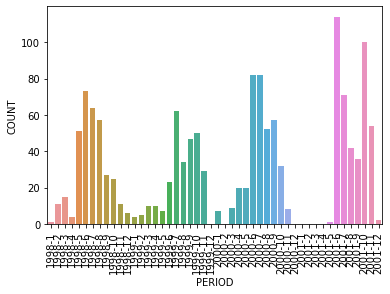

<Figure size 720x720 with 0 Axes>

In [35]:
sn.barplot(data=df_swh_count.sort_values(by=["YEAR","MONTH"]),x="PERIOD",y="COUNT")
plt.xticks(rotation=90)
plt.figure(figsize=(10,10))

         ALT        ID  MTN  ALL
15    1800.0  73257400  ALP  ALL
48    2150.0  64330400  PYR  ALL
63    1941.0  66188401  PYR  ALL
73    1665.0  05181002  ALP  ALL
101   1960.0  73322401  ALP  ALL
...      ...       ...  ...  ...
6636   945.0  38442001  ALP  ALL
6722  2084.0  38253403  ALP  ALL
6733  1330.0  38285400  ALP  ALL
6736  1350.0  38289401  ALP  ALL
6772  1420.0  09139400  PYR  ALL

[184 rows x 4 columns]
620.0 2730.0


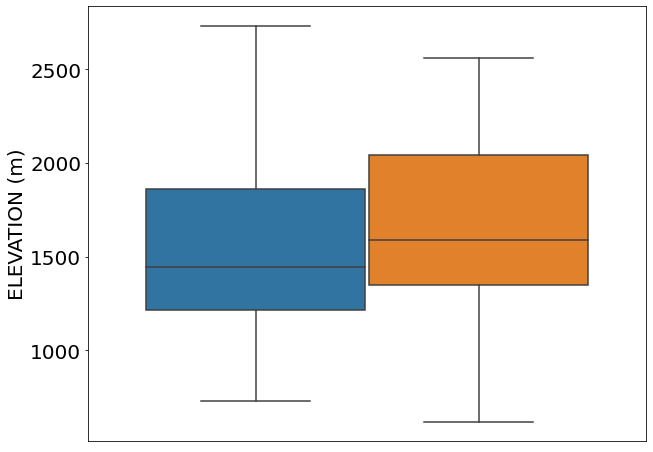

In [9]:
#get used stations meta
plot_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/PLOTS"




df_stations_alt = df[["ALT","ID","MTN"]].drop_duplicates()
df_stations_alt["ALL"] = "ALL"

print(df_stations_alt)

print(df_stations_alt['ALT'].min(),df_stations_alt['ALT'].max())
#sn.reset_orig()
fig, axs = plt.subplots()
sn.boxplot(ax=axs,data = df_stations_alt,y="ALT",x= 'ALL',hue='MTN')
axs.set_xlabel(None)
axs.set_ylabel("ELEVATION (m)",size=20)

plt.xticks(ticks=[], labels=[])
plt.yticks(fontsize=20)
axs.get_legend().remove()
#sn.histplot(ax=axs[2],data = df_stations_years,x="NB_OF_YEARS",hue='MTN',hue_order=['ALP','PYR'],bins=29,multiple='stack')
#axs[2].set(ylabel="NB OF STATIONS")
#axs[2].set_xticks([1986] + list(range(1990,2016,5)),[1986] + list(range(1990,2016,5)),rotation=45) 
#axs[2].set_xlim(1986,2015) 

fig.set_figwidth(10)
fig.set_figheight(8)

plt.savefig(op.join(plot_path,f'stations_meta.svg'),format="svg")


         ALT        ID  MTN  ALL
15    1800.0  73257400  ALP  ALL
48    2150.0  64330400  PYR  ALL
63    1941.0  66188401  PYR  ALL
73    1665.0  05181002  ALP  ALL
101   1960.0  73322401  ALP  ALL
...      ...       ...  ...  ...
6636   945.0  38442001  ALP  ALL
6722  2084.0  38253403  ALP  ALL
6733  1330.0  38285400  ALP  ALL
6736  1350.0  38289401  ALP  ALL
6772  1420.0  09139400  PYR  ALL

[184 rows x 4 columns]
620.0 2730.0


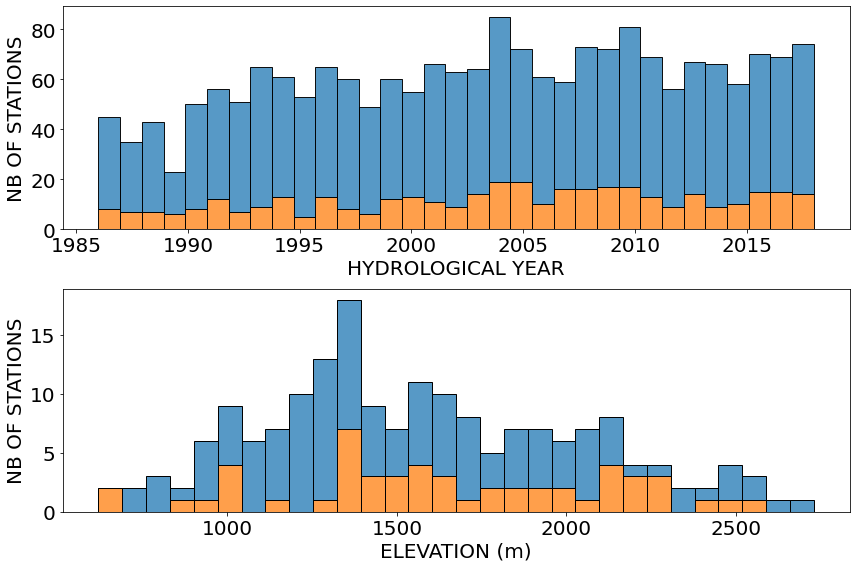

In [34]:
#get used stations meta
plot_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/PLOTS"




df_stations_alt = df[["ALT","ID","MTN"]].drop_duplicates()
df_stations_alt["ALL"] = "ALL"

print(df_stations_alt)

print(df_stations_alt['ALT'].min(),df_stations_alt['ALT'].max())
#sn.reset_orig()
fig, axs = plt.subplots(2)
sn.histplot(ax=axs[1],data = df_stations_alt,x= 'ALT',hue='MTN',hue_order=['ALP','PYR'],multiple='stack',bins=30)
axs[1].set_ylabel("NB OF STATIONS",fontsize=20)
axs[1].tick_params(axis='both', which='major', labelsize=20)
#axs[0].set_xlabel(None)
axs[1].set_xlabel("ELEVATION (m)",fontsize=20)

#plt.xticks(ticks=[], labels=[])
#plt.yticks(fontsize=20)
axs[1].get_legend().remove()

df_stations_years = df[["HYDRO_YEAR","ID","MTN"]].drop_duplicates()
sn.histplot(ax=axs[0],data = df_stations_years,x="HYDRO_YEAR",hue='MTN',hue_order=['ALP','PYR'],bins=33,multiple='stack')
axs[0].set_ylabel("NB OF STATIONS",fontsize=20)
axs[0].tick_params(axis='both', which='major', labelsize=20)
#axs[0].set_xticks([1986] + list(range(1990,2019,5)),[1986] + list(range(1990,2019,5)),rotation=45) 
#axs[0].set_xlim(1986,2019) 
axs[0].set_xlabel("HYDROLOGICAL YEAR",fontsize=20)
axs[0].get_legend().remove()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.tight_layout()

plt.savefig(op.join(plot_path,f'stations_meta.svg'),format="svg")


In [8]:
df_temp = df.query("MODEL == 'S2' &  MIN_PREC == 4 & MIN_DEPTH == 1 & MAX_SMOD_ΔOBS == 0  & SMOD > 0 ")
df_temp["HYDRO_YEAR"].value_counts()

2018    74
2016    70
2017    69
2015    58
Name: HYDRO_YEAR, dtype: int64

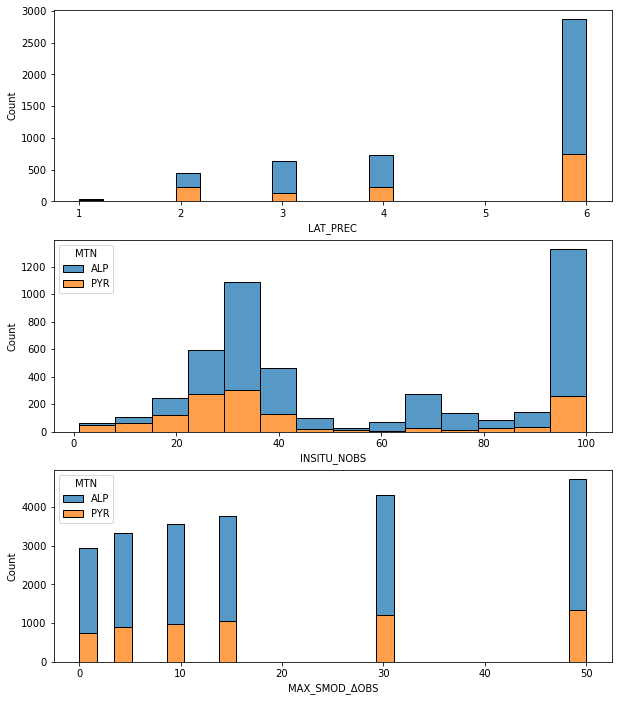

In [13]:
df_temp = df.query(" MODEL == 'TB'  & MIN_PREC == 1 &MIN_DEPTH == 1  & HYDRO_YEAR >= 1986 & HYDRO_YEAR < 2015 ")

fig, axs = plt.subplots(3)
sn.histplot(ax=axs[0],data=df_temp.query("MAX_SMOD_ΔOBS == 50"),x='LAT_PREC',hue='MTN',multiple='stack')
sn.histplot(ax=axs[1],data=df_temp.query("MAX_SMOD_ΔOBS == 50"),x='INSITU_NOBS',hue='MTN',multiple='stack')
sn.histplot(ax=axs[2],data=df_temp,x='MAX_SMOD_ΔOBS',hue='MTN',multiple='stack')
fig.set_figwidth(10)
fig.set_figheight(12)

MTN
ALP    0.773522
PYR    0.610390
Name: SMOD, dtype: float64
MTN
ALP    1201
PYR     308
Name: SMOD, dtype: int64


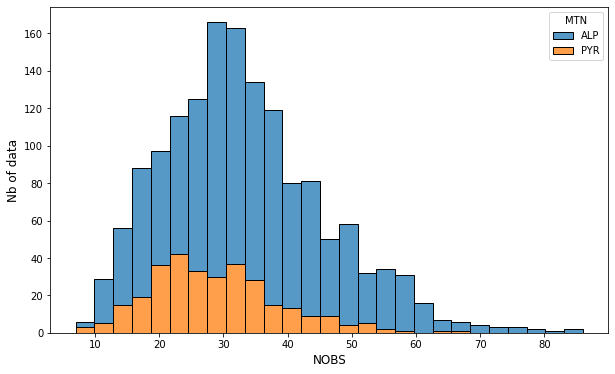

In [17]:
plot_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/PLOTS"
df_temp =  df.query(" MODEL == 'TB' & MIN_DEPTH == 1 & SMOD > 0   & MAX_SMOD_ΔOBS == 0 & MIN_PREC == 4 & ELEVATION > 900 ")
fig, ax = plt.subplots()
sn.histplot(ax=ax,data=df_temp,x='NOBS',hue="MTN",multiple='stack')
fig.set_figwidth(10)
fig.set_figheight(6)
ax.set_xlabel("NOBS",size=12)
ax.set_ylabel("Nb of data",size=12)
plt.savefig(op.join(plot_path,f'NOBSMTN.pdf'),format="pdf",transparent=False,facecolor='white')
print(df_temp.query("NOBS >= 25").groupby("MTN")["SMOD"].count()/df_temp.groupby("MTN")["SMOD"].count())
print(df_temp.groupby("MTN")["SMOD"].count())

33.380648591174904 10.0 59.0


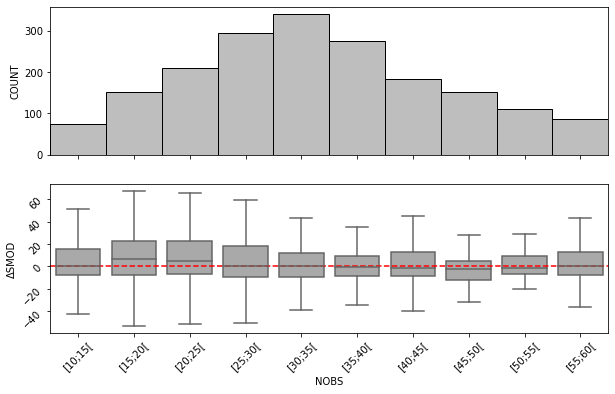

In [40]:
df_temp =  df.query(" (MODEL == 'TB' | MODEL == 'THEIA') & SMOD > 0  & NOBS < 60 & NOBS >= 10  ").sort_values(by=["NOBS"])
plot_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/PLOTS"
print(df_temp['NOBS'].mean(),df_temp['NOBS'].min(),df_temp['NOBS'].max())
fig, axs = plt.subplots(2,sharex='col')
sn.histplot(data=df_temp,x='NOBS_RANGE',ax=axs[0],color="darkgrey")
sn.boxplot(data=df_temp,y='ΔSMOD',x='NOBS_RANGE',ax=axs[1],showfliers=False,color="darkgrey")
axs[1].tick_params(labelrotation=45)
axs[1].axhline(0, ls='--', color='red')
axs[1].set_xlabel("NOBS")
axs[0].set_ylabel("COUNT")
fig.set_figwidth(10)
fig.set_figheight(6)
plt.savefig(op.join(plot_path,f'smodhist.png'),format="png",transparent=False,facecolor='white', dpi=300)

TypeError: boxplot() got an unexpected keyword argument 'legend'

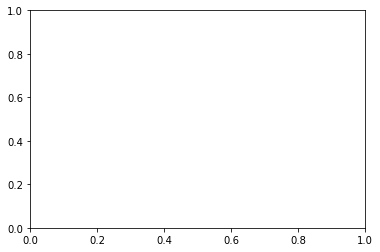

In [16]:
df_temp =  df.query(" MIN_DEPTH == 1 & SMOD > 0   & MAX_SMOD_ΔOBS == 0 & MIN_PREC == 4   ").sort_values(by=["NOBS"])
fig, axs = plt.subplots()
sn.boxplot(data=df_temp,x='NOBS_RANGE',y="ΔSMOD",hue="MODEL",legend=False)

axs.tick_params(labelrotation=45)


fig.set_figwidth(10)
fig.set_figheight(6)

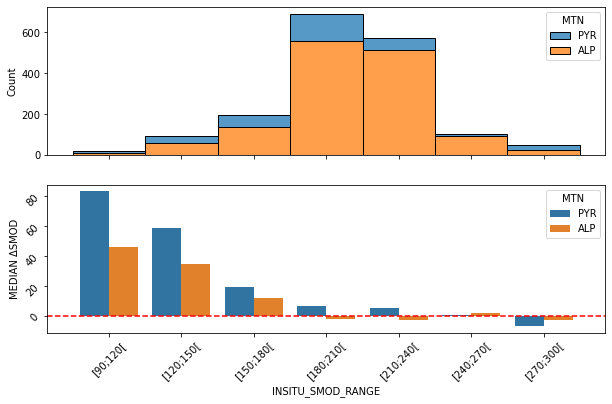

In [13]:


df_temp = df.sort_values(by=['INSITU_SMOD']).query(" MODEL == 'TB' & MIN_PREC == 4 & MIN_DEPTH == 1 & MAX_SMOD_ΔOBS == 0 & HYDRO_YEAR >= 1986 & HYDRO_YEAR < 2015 & SMOD > 0 & INSITU_SCD > 60")
df_temp = df_temp.query("INSITU_SMOD >= 0 & INSITU_SMOD <= 300")

fig, axs = plt.subplots(2,sharex='col')
sn.barplot(data=df_temp,y= 'ΔSMOD',x='INSITU_SMOD_RANGE',ci=None,ax=axs[1],estimator=np.median,hue="MTN")
sn.histplot(data=df_temp,x='INSITU_SMOD_RANGE',ax=axs[0],hue="MTN",multiple='stack')
axs[1].tick_params(labelrotation=45)
axs[1].axhline(0, ls='--', color='red')
axs[1].set_ylabel("MEDIAN ΔSMOD")
fig.set_figwidth(10)
fig.set_figheight(6)


In [ ]:
def r2_rmse_interval(g):
    r2 = r2_score( g['INSITU_SMOD'], g['SMOD'] )
    rmse = np.sqrt( mean_squared_error( g['INSITU_SMOD'], g['SMOD'] ))
    return pd.Series( dict(  r2 = r2, rmse = rmse) )

def mae_interval(g):

    mae = np.sqrt( mean_absolute_error( g['INSITU_SMOD'], g['SMOD'] ))
    return pd.Series( dict( mae = mae) )

def draw_text(plot,ax):
    w = []
    y = []
    for i,patch in enumerate(plot.patches):
        w.append(plot.patches[i].get_width())
        y.append(plot.patches[i].get_y())
    w = np.array(w).reshape(2, int(len(w)/2))
    y = np.array(y).reshape(2, int(len(y)/2))
    print(w,y)
    p = w[1]/w[0]*100
    print(p)
    for i in range(len(p)):
        plot.annotate("{:.1f}%".format(p[i]), xy=(w[1][i],y[0][i]))

df_temp =  df.query("MODEL == 'TO' &  MIN_PREC == 4 & MIN_DEPTH == 1 & MAX_SMOD_ΔOBS == 0  & SMOD > 0 & NOBS <= 50")
df_temp2 = df_temp.groupby(['NOBS'])['ΔSMOD'].mean().to_frame('ΔSMOD_MEAN')
df_temp2["ΔSMOD_MEDIAN"] = df_temp.groupby(['NOBS'])['ΔSMOD'].median()
df_temp2["ΔSMOD_MEDIAN"] = df_temp.groupby(['NOBS'])['ΔSMOD'].median()
df_temp2["ΔSMOD_STD"] = df_temp.groupby(['NOBS'])['ΔSMOD'].std()
df_temp2["ΔSMOD_Q1"] = df_temp.groupby(['NOBS'])['ΔSMOD'].quantile(0.25)
df_temp2["ΔSMOD_Q3"] = df_temp.groupby(['NOBS'])['ΔSMOD'].quantile(0.75)
df_temp2["ΔSMOD_IQR"]  = df_temp2.ΔSMOD_Q3  - df_temp2.ΔSMOD_Q1 
df_temp2["ΔSMOD_COUNT"] = df_temp.groupby(['NOBS'])['ΔSMOD'].count()
df_temp2["ci95_lo"] = df_temp2.ΔSMOD_MEAN - 1.96*df_temp2.ΔSMOD_STD/np.sqrt(df_temp2.ΔSMOD_COUNT)
df_temp2["ci95_hi"] = df_temp2.ΔSMOD_MEAN + 1.96*df_temp2.ΔSMOD_STD/np.sqrt(df_temp2.ΔSMOD_COUNT)
df_temp2["ΔSMOD_CI"]  = df_temp2.ci95_hi  - df_temp2.ci95_lo 
df_temp2[["SMOD_R2",'SMOD_RMSE']]  =  df_temp.groupby(['NOBS']).apply( r2_rmse_interval )
df_temp2[['SMOD_MAE']]  =  df_temp.groupby(['NOBS']).apply( mae_interval )
df_temp2=df_temp2.reset_index()

df_temp2 = df_temp2.melt(id_vars=['NOBS'], value_vars=['ΔSMOD_MEDIAN','ΔSMOD_IQR','SMOD_RMSE'],var_name='ΔSMOD_METRIC', value_name='METRIC_VALUE')
df_temp = df_temp.sort_values(by=['NOBS'])


fig, axs = plt.subplots(1,2,sharey=True)
bp = sn.boxplot(ax=axs[0],data=df_temp,y="NOBS_RANGE",x="ΔSMOD",showfliers=False,hue="MODEL")
#axs[0].invert_yaxis() 
axs[0].set_axisbelow(True)
axs[0].tick_params(axis='both', labelrotation=-90)
axs[0].axvline(0, ls='--', color='red')
axs[0].set_ylabel("NOBS RANGE", rotation=-90,labelpad=20)
axs[0].xaxis.set_label_position('top') 
axs[0].xaxis.set_ticks_position('top')
hs = sn.histplot(ax=axs[1],data=df_temp,y='NOBS_RANGE',hue="MODEL",multiple='stack')
#axs[1].invert_yaxis()
axs[1].tick_params(axis='x', labelrotation=-90)
axs[1].xaxis.set_label_position('top') 
axs[1].xaxis.set_ticks_position('top')
fig.set_figwidth(8)
fig.set_figheight(10)

             ID                 NAME  MIN_DEPTH SAFRAN  HYDRO_YEAR  TCD  \
34581  73257400        Les Menuires           1  Vanoi        2015    0   
34582  73257400        Les Menuires           1  Vanoi        2016    0   
34583  73257400        Les Menuires           1  Vanoi        2017    0   
34584  73257400        Les Menuires           1  Vanoi        2018    0   
34625  64330400    SOUM COUY-NIVOSE           1  AspOs        2015    0   
...         ...                  ...        ...    ...         ...  ...   
41767  38442001   GRANDE-CHARTREUSE           1  Chart        2015    0   
41816  38289401               Olmet           1  G-Rou        2015    0   
41817  38289401               Olmet           1  G-Rou        2016    0   
41818  38289401               Olmet           1  G-Rou        2017    0   
41819  38289401               Olmet           1  G-Rou        2018    0   

        TILE MODEL  CONTRIB_SWH     ALT  ...  ABLATION_NOBS  MTN  PERIOD  \
34581  31TGL    S2     

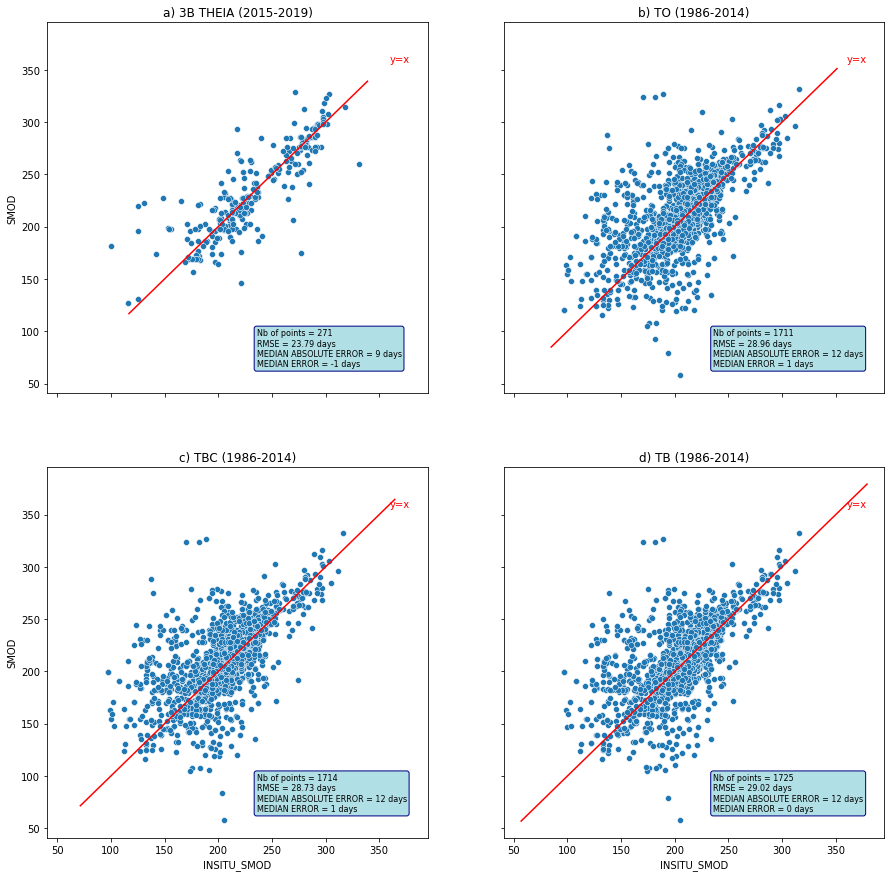

In [10]:
plot_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/PLOTS"
fig, axs = plt.subplots(2,2,sharey=True,sharex=True)



df_temp =  df.query("MODEL == 'S2' &  MIN_PREC == 4 & MIN_DEPTH == 1 & MAX_SMOD_ΔOBS == 0  & SMOD > 0 ")
print(df_temp)
rmse = np.sqrt( mean_squared_error( df_temp['INSITU_SMOD'], df_temp['SMOD'] ))
ΔSMOD_MEDIAN = np.median(df_temp['ΔSMOD'])
MAE = median_absolute_error( df_temp['INSITU_SMOD'], df_temp['SMOD'] )
nb = df_temp['INSITU_SMOD'].count()


sn.scatterplot(data=df_temp, x="INSITU_SMOD", y="SMOD",ax= axs[0,0])

x0, x1 = axs[0,0].get_xlim()
y0, y1 = axs[0,0].get_ylim()
lims = [max(x0, y0), min(x1, y1)]
axs[0,0].plot(lims, lims, '-r')
axs[0,0].annotate(f'y=x',
                    xy=(0.9, 0.9), xycoords='axes fraction',
                    ha='left', va='center',color='red')
axs[0,0].annotate(f"Nb of points = {nb}\nRMSE = {round(rmse,2)} days\nMEDIAN ABSOLUTE ERROR = {int(MAE)} days\nMEDIAN ERROR = {int(ΔSMOD_MEDIAN)} days" ,
                    xy=(0.55, 0.12), xycoords='axes fraction',
                    ha='left', va='center', fontsize=8,
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

axs[0,0].set_title("a) 3B THEIA (2015-2019)")


df_temp =  df.query("MODEL == 'TO' &  MIN_PREC == 4 & MIN_DEPTH == 1 & MAX_SMOD_ΔOBS == 0  & SMOD > 0 ")
rmse = np.sqrt( mean_squared_error( df_temp['INSITU_SMOD'], df_temp['SMOD'] ))
ΔSMOD_MEDIAN = np.median(df_temp['ΔSMOD'])
MAE = median_absolute_error( df_temp['INSITU_SMOD'], df_temp['SMOD'] )
nb = df_temp['INSITU_SMOD'].count()


sn.scatterplot(data=df_temp, x="INSITU_SMOD", y="SMOD",ax=axs[0,1])

x0, x1 = axs[0,1].get_xlim()
y0, y1 = axs[0,1].get_ylim()
lims = [max(x0, y0), min(x1, y1)]
axs[0,1].plot(lims, lims, '-r')
axs[0,1].annotate(f'y=x',
                    xy=(0.9, 0.9), xycoords='axes fraction',
                    ha='left', va='center',color='red')
axs[0,1].annotate(f"Nb of points = {nb}\nRMSE = {round(rmse,2)} days\nMEDIAN ABSOLUTE ERROR = {int(MAE)} days\nMEDIAN ERROR = {int(ΔSMOD_MEDIAN)} days" ,
                    xy=(0.55, 0.12), xycoords='axes fraction',
                    ha='left', va='center', fontsize=8,
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

axs[0,1].set_title("b) TO (1986-2014)")






df_temp =  df.query("MODEL == 'TBC' &  MIN_PREC == 4 & MIN_DEPTH == 1 & MAX_SMOD_ΔOBS == 0  & SMOD > 0 ")
rmse = np.sqrt( mean_squared_error( df_temp['INSITU_SMOD'], df_temp['SMOD'] ))
ΔSMOD_MEDIAN = np.median(df_temp['ΔSMOD'])
MAE = median_absolute_error( df_temp['INSITU_SMOD'], df_temp['SMOD'] )
nb = df_temp['INSITU_SMOD'].count()


sn.scatterplot(data=df_temp, x="INSITU_SMOD", y="SMOD",ax=axs[1,0])

x0, x1 = axs[1,0].get_xlim()
y0, y1 = axs[1,0].get_ylim()
lims = [max(x0, y0), min(x1, y1)]
axs[1,0].plot(lims, lims, '-r')
axs[1,0].annotate(f'y=x',
                    xy=(0.9, 0.9), xycoords='axes fraction',
                    ha='left', va='center',color='red')
axs[1,0].annotate(f"Nb of points = {nb}\nRMSE = {round(rmse,2)} days\nMEDIAN ABSOLUTE ERROR = {int(MAE)} days\nMEDIAN ERROR = {int(ΔSMOD_MEDIAN)} days" ,
                    xy=(0.55, 0.12), xycoords='axes fraction',
                    ha='left', va='center', fontsize=8,
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

axs[1,0].set_title("c) TBC (1986-2014)")



df_temp =  df.query("MODEL == 'TB' &  MIN_PREC == 4 & MIN_DEPTH == 1 & MAX_SMOD_ΔOBS == 0  & SMOD > 0 ")
rmse = np.sqrt( mean_squared_error( df_temp['INSITU_SMOD'], df_temp['SMOD'] ))
ΔSMOD_MEDIAN = np.median(df_temp['ΔSMOD'])
MAE = median_absolute_error( df_temp['INSITU_SMOD'], df_temp['SMOD'] )
nb = df_temp['INSITU_SMOD'].count()


sn.scatterplot(data=df_temp, x="INSITU_SMOD", y="SMOD",ax=axs[1,1])

x0, x1 = axs[1,1].get_xlim()
y0, y1 = axs[1,1].get_ylim()
lims = [max(x0, y0), min(x1, y1)]
axs[1,1].plot(lims, lims, '-r')
axs[1,1].annotate(f'y=x',
                    xy=(0.9, 0.9), xycoords='axes fraction',
                    ha='left', va='center',color='red')
axs[1,1].annotate(f"Nb of points = {nb}\nRMSE = {round(rmse,2)} days\nMEDIAN ABSOLUTE ERROR = {int(MAE)} days\nMEDIAN ERROR = {int(ΔSMOD_MEDIAN)} days" ,
                    xy=(0.55, 0.12), xycoords='axes fraction',
                    ha='left', va='center', fontsize=8,
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})


axs[1,1].set_title("d) TB (1986-2014)")

fig.set_figwidth(15)
fig.set_figheight(15)

plt.savefig(op.join(plot_path,f'scatter_theia_swhlandsat.pdf'),format="pdf",transparent=False,facecolor='white')


['SWHLX' 'THEIA']
['SWHLX' 'THEIA']


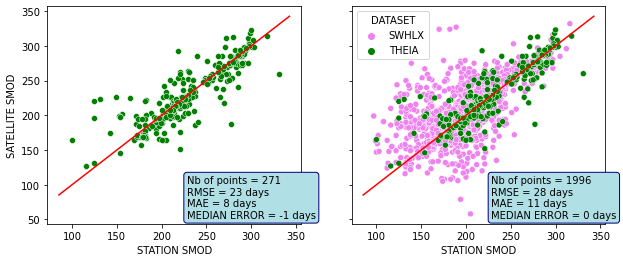

In [18]:
plot_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/PLOTS"
fig, axs = plt.subplots(1,2,sharex=True, sharey=True)


df_temp = df.replace("TB", "SWHLX")
df_temp = df_temp.rename(columns={"MODEL": "DATASET"})

df_temp.loc[df_temp['DATASET'] == 'THEIA', 'Top'] = 2
df_temp.loc[df_temp['DATASET'] == 'SWHLX', 'Top'] = 1
df_temp = df_temp.sort_values(by=['Top'], ascending=True) 

print(df_temp.DATASET.unique())

df_temp2 =  df_temp.query("DATASET == 'THEIA' | DATASET == 'SWHLX'")
print(df_temp2.DATASET.unique())

#print(df_temp)
rmse = np.sqrt( mean_squared_error( df_temp2['INSITU_SMOD'], df_temp2['SMOD'] ))
ΔSMOD_MEDIAN = np.median(df_temp2['ΔSMOD'])
MAE = median_absolute_error( df_temp2['INSITU_SMOD'], df_temp2['SMOD'] )
nb = df_temp2['INSITU_SMOD'].count()


sn.scatterplot(data=df_temp2, x="INSITU_SMOD", y="SMOD",hue='DATASET',palette = ['violet','green'],ax= axs[1])

x0, x1 = axs[1].get_xlim()
y0, y1 = axs[1].get_ylim()
lims = [max(x0, y0), min(x1, y1)]
axs[1].plot(lims, lims, '-r')

axs[1].annotate(f"Nb of points = {nb}\nRMSE = {round(rmse)} days\nMAE = {int(MAE)} days\nMEDIAN ERROR = {int(ΔSMOD_MEDIAN)} days" ,
                    xy=(0.55, 0.12), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})


axs[1].set_xlabel("STATION SMOD")
axs[1].set_ylabel("SATELLITE SMOD")




df_temp1 =  df_temp.query("(DATASET == 'THEIA')")
#print(df_temp)
rmse = np.sqrt( mean_squared_error( df_temp1['INSITU_SMOD'], df_temp1['SMOD'] ))
ΔSMOD_MEDIAN = np.median(df_temp1['ΔSMOD'])
MAE = median_absolute_error( df_temp1['INSITU_SMOD'], df_temp1['SMOD'] )
nb = df_temp1['INSITU_SMOD'].count()


sn.scatterplot(data=df_temp1, x="INSITU_SMOD", y="SMOD",color = 'green',ax= axs[0])

x0, x1 = axs[0].get_xlim()
y0, y1 = axs[0].get_ylim()
#lims = [max(x0, y0), min(x1, y1)]
axs[0].plot(lims, lims, '-r')

axs[0].annotate(f"Nb of points = {nb}\nRMSE = {round(rmse)} days\nMAE = {int(MAE)} days\nMEDIAN ERROR = {int(ΔSMOD_MEDIAN)} days" ,
                    xy=(0.55, 0.12), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})


axs[0].set_xlabel("STATION SMOD")
axs[0].set_ylabel("SATELLITE SMOD")





fig.set_figwidth(10)

plt.savefig(op.join(plot_path,f'scatter_SWHLX_Theia.pdf'),format="pdf",transparent=False,facecolor='white')


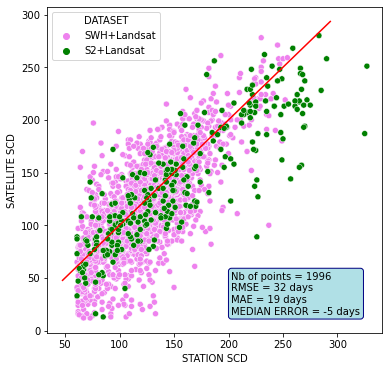

In [8]:
plot_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/PLOTS"
fig, axs = plt.subplots()


df_temp = df.replace("TB", "SWH+Landsat")
df_temp = df_temp.replace("THEIA", "S2+Landsat")
df_temp = df_temp.rename(columns={"MODEL": "DATASET"})

df_temp.loc[df_temp['DATASET'] == 'S2+Landsat', 'Top'] = 2
df_temp.loc[df_temp['DATASET'] == 'SWH+Landsat', 'Top'] = 1
df_temp = df_temp.sort_values(by=['Top'], ascending=True) 



df_temp2 =  df_temp.query("(DATASET == 'S2+Landsat' | DATASET == 'SWH+Landsat' )")
#print(df_temp)
rmse = np.sqrt( mean_squared_error( df_temp2['INSITU_SCD'], df_temp2['SCD'] ))
ΔSMOD_MEDIAN = np.median(df_temp2['ΔSCD'])
MAE = median_absolute_error( df_temp2['INSITU_SCD'], df_temp2['SCD'] )
nb = df_temp2['INSITU_SCD'].count()


sn.scatterplot(data=df_temp2, x="INSITU_SCD", y="SCD",hue='DATASET',palette = ['violet','green'],ax= axs)

x0, x1 = axs.get_xlim()
y0, y1 = axs.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
axs.plot(lims, lims, '-r')

axs.annotate(f"Nb of points = {nb}\nRMSE = {round(rmse)} days\nMAE = {int(MAE)} days\nMEDIAN ERROR = {int(ΔSMOD_MEDIAN)} days" ,
                    xy=(0.55, 0.12), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})


axs.set_xlabel("STATION SCD")
axs.set_ylabel("SATELLITE SCD")





fig.set_figheight(6)

fig.set_figwidth(6)

plt.savefig(op.join(plot_path,f'scatter_SWHLX_Theia.png'),format="png",transparent=False,facecolor='white')


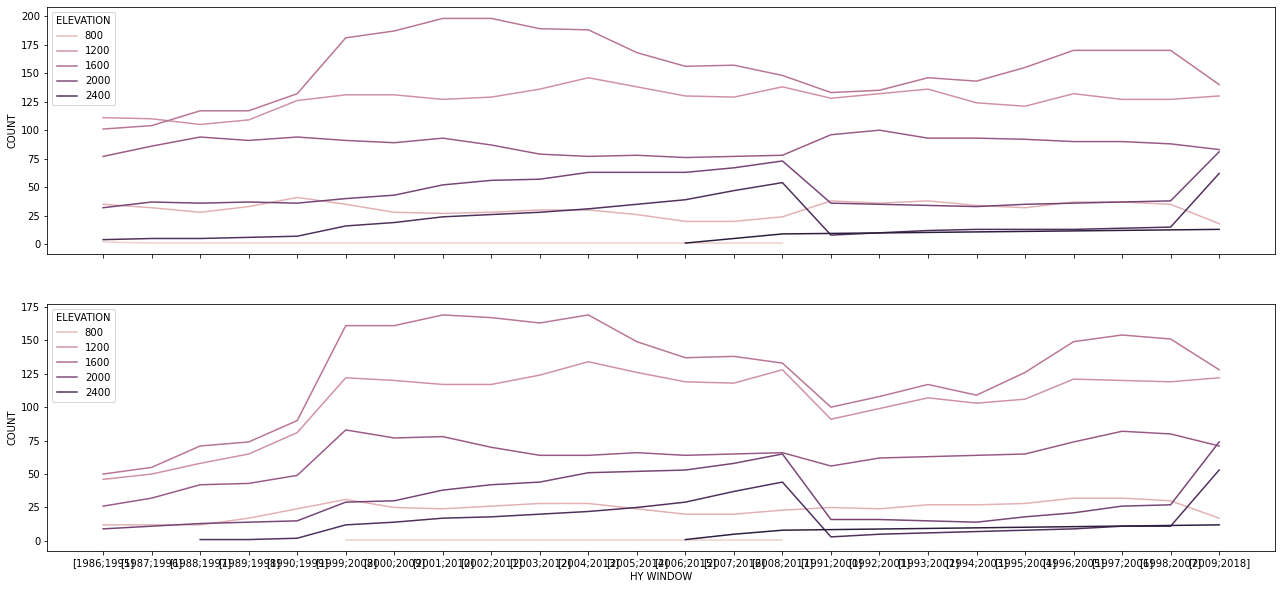

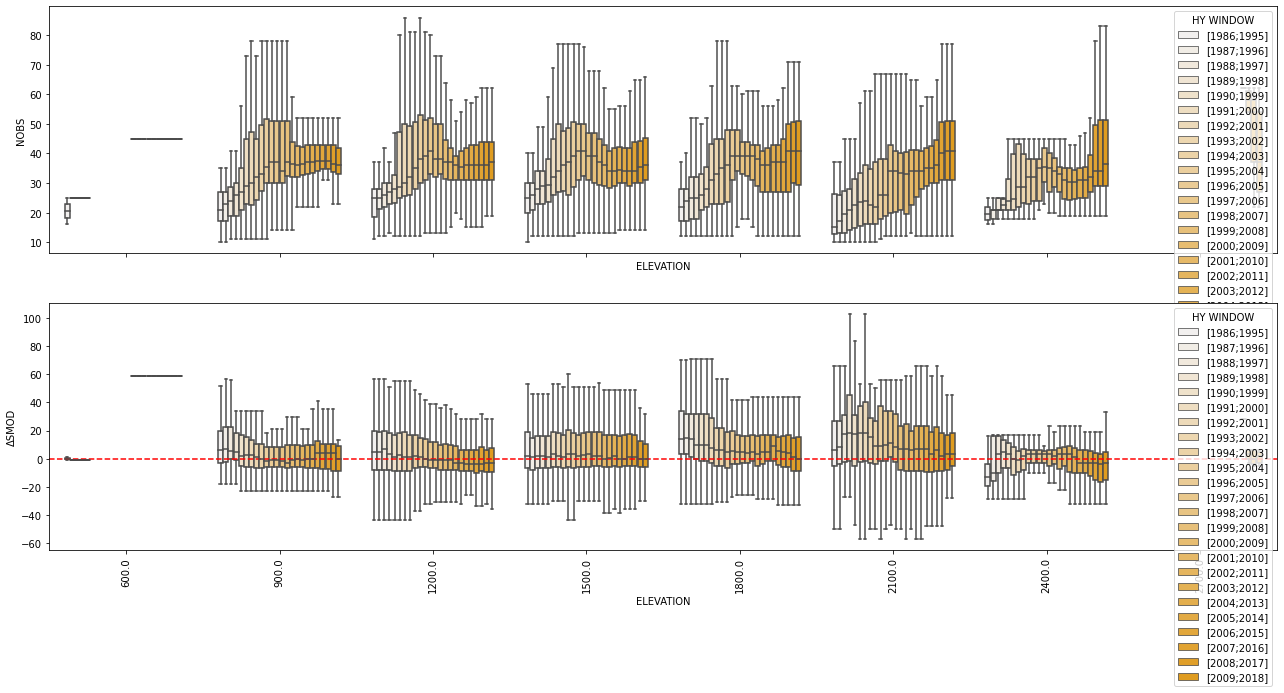

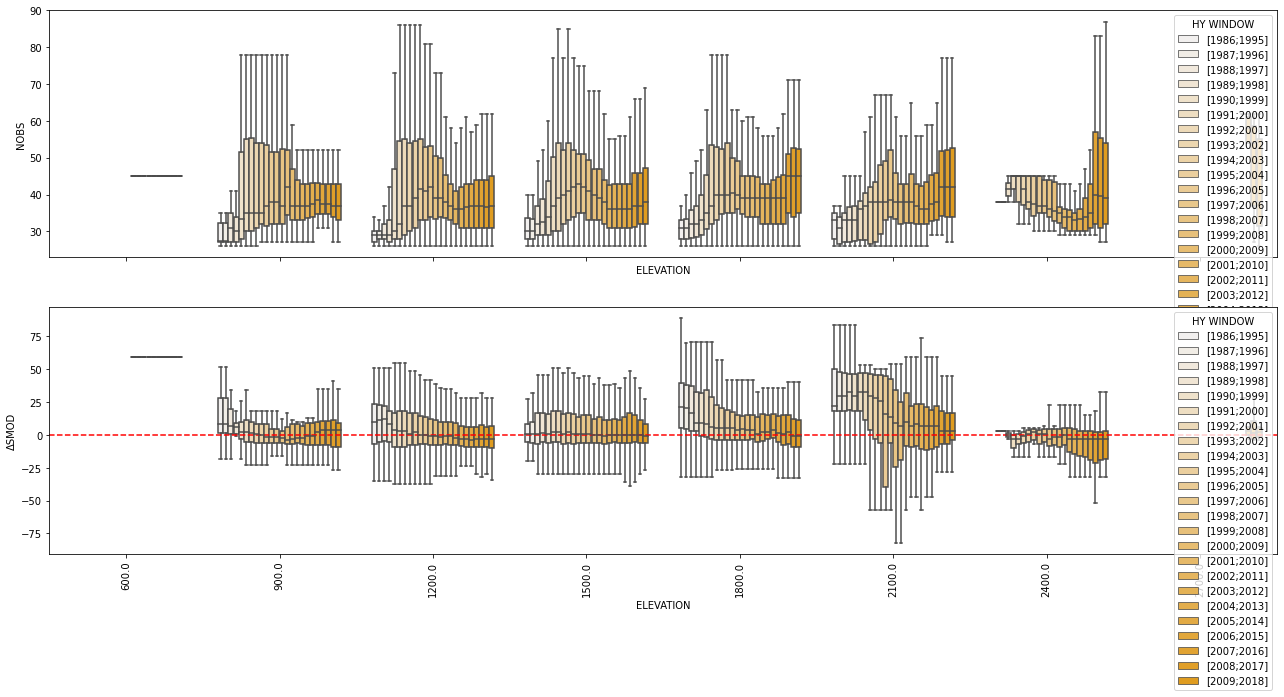

In [34]:
#sliding window
def draw_modes(plot,ax):
    for line in plot.get_lines():
        x, y = line.get_data()
        color = line.get_color()
        #print(x[np.argmax(y)])
        print(np.median(y))
        ax.axhline(np.median(y), ls='--', color=color)
        
        
plot_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/PLOTS"

pd.options.mode.chained_assignment = None

df_temp = df.query(f"(MODEL == 'THEIA' | MODEL == 'TB' ) & SCD > 90")


window_size = 10
slide_size = 1
list_period=[]
list_df = []
for HY in  range(1986,2019-window_size+1,slide_size):
    df_i= df_temp.query(f" HYDRO_YEAR >= {HY} & HYDRO_YEAR < {HY + window_size} ")
    df_i['HY WINDOW'] = f"[{HY};{HY + window_size -1}]"
    list_df.append(df_i)
    list_period.append(f"[{HY};{HY + window_size -1}]")
df_windows = pd.concat(list_df,ignore_index=True)



fig, axs = plt.subplots(2,1,sharex=True)

sn.lineplot(data=df_windows.query("NOBS >= 10").groupby(["ELEVATION","HY WINDOW"])["NOBS"].count().to_frame("COUNT").reset_index(),hue="ELEVATION", x="HY WINDOW", y="COUNT",ax= axs[0],color="orange")
sn.lineplot(data=df_windows.query("NOBS >= 26").groupby(["ELEVATION","HY WINDOW"])["NOBS"].count().to_frame("COUNT").reset_index(),hue="ELEVATION", x="HY WINDOW", y="COUNT",ax= axs[1],color="orange")



fig.set_figwidth(22)
fig.set_figheight(10)


fig, axs = plt.subplots(2,1,sharex=True)

sn.boxplot(data=df_windows.query("NOBS >= 10"),x="ELEVATION", hue="HY WINDOW", y="NOBS",ax= axs[0], showfliers=False,color="orange")
sn.boxplot(data=df_windows.query("NOBS >= 10"),x="ELEVATION", hue="HY WINDOW", y="ΔSMOD",ax= axs[1], showfliers=False,color="orange")

axs[1].axhline(0, ls='--', color='red')

axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)


fig.set_figwidth(22)
fig.set_figheight(10)


fig, axs = plt.subplots(2,1,sharex=True)

sn.boxplot(data=df_windows.query("NOBS >= 26"),x="ELEVATION", hue="HY WINDOW", y="NOBS",ax= axs[0], showfliers=False,color="orange")
sn.boxplot(data=df_windows.query("NOBS >= 26"),x="ELEVATION", hue="HY WINDOW", y="ΔSMOD",ax= axs[1], showfliers=False,color="orange")
axs[1].axhline(0, ls='--', color='red')

axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)


fig.set_figwidth(22)
fig.set_figheight(10)







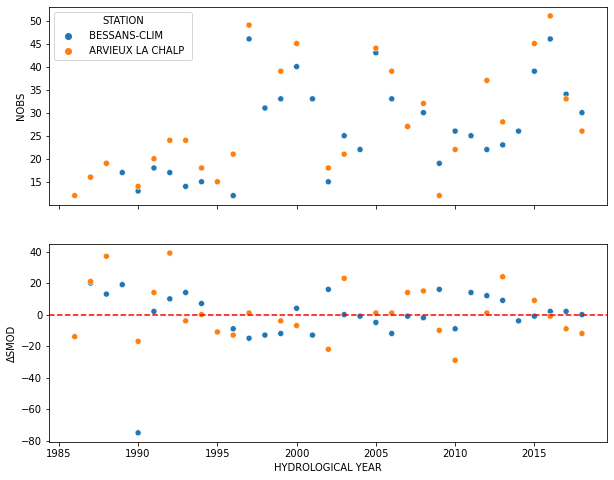

In [8]:
#sliding window
def draw_modes(plot,ax):
    for line in plot.get_lines():
        x, y = line.get_data()
        color = line.get_color()
        #print(x[np.argmax(y)])
        print(np.median(y))
        ax.axhline(np.median(y), ls='--', color=color)
        
        
plot_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/PLOTS"

pd.options.mode.chained_assignment = None

df_temp = df.query(f"(MODEL == 'THEIA' | MODEL == 'TB' ) & SCD > 90 & INSITU_SMOD_PREC <= 0 & PERIOD == 'FULL'")

df_temp = df_temp.rename(columns={"NAME": "STATION", "HYDRO_YEAR": "HY"})



window_size = 1
slide_size = 1
list_period=[]
list_df = []
for Y in  range(1986,2019-window_size+1,slide_size):
    df_i= df_temp.query(f" HY >= {Y} & HY < {Y + window_size} ")
    df_i['HY WINDOW'] = f"[{Y};{Y + window_size -1}]"
    list_df.append(df_i)
    list_period.append(f"[{Y};{Y + window_size -1}]")
df_windows = pd.concat(list_df,ignore_index=True)




fig, axs = plt.subplots(2,sharex=True)

sn.scatterplot(data=df_temp.query("NOBS >= 10"), x="HY", y="NOBS",hue="STATION",ax= axs[0],color="orange")
sn.scatterplot(data=df_temp.query("NOBS >= 10"), x="HY", y="ΔSMOD",hue="STATION",ax= axs[1],color="orange",legend=False)

axs[1].axhline(0, ls='--', color='red')
axs[1].set_xlabel('HYDROLOGICAL YEAR')



fig.set_figwidth(10)
fig.set_figheight(8)

plt.savefig(op.join(plot_path,f'D_SMOD_10.png'),format="png",transparent=False,facecolor='white')






In [8]:
#trend test
def mannkendall(g):
    if g.SMOD.count() >=20 :
        mk_test = mk.original_test(g.SMOD, alpha=0.05)
        i_mk_test = mk.original_test(g.INSITU_SMOD, alpha=0.05)
        out = pd.Series( dict(  Tau = mk_test.Tau, trend = mk_test.trend, p = mk_test.p, slope = mk_test.slope, intercept = mk_test.intercept,
                              i_Tau = i_mk_test.Tau, i_trend = i_mk_test.trend, i_p = i_mk_test.p, i_slope = i_mk_test.slope, i_intercept = i_mk_test.intercept,
                              year_count=g.SMOD.count()) )
    else:
        out = pd.Series( dict(  Tau = np.nan, trend = "nan", p = np.nan, slope = np.nan, intercept = np.nan,
                              i_Tau = np.nan, i_trend = "nan", i_p = np.nan, i_slope = np.nan, i_intercept = np.nan,
                              year_count=g.SMOD.count()) )
    return out


df_mask = df.query(" (MODEL == 'TB' | MODEL == 'S2') & MIN_DEPTH == 1 & SMOD > 0 & NOBS >= 30  & MAX_SMOD_ΔOBS == 0 & MIN_PREC == 4 & ELEVATION > 900")

df_MK = df_mask.sort_values(by=['HYDRO_YEAR']).groupby(["ID"]).apply(mannkendall)
#df_MK = df_MK.append(df_mask.sort_values(by=['HYDRO_YEAR']).groupby(["ID"]).apply(insitu_mannkendall))

print(df_mask)
print(df_MK)

              ID            NAME  MIN_DEPTH SAFRAN  HYDRO_YEAR  TCD   TILE  \
479769  73257400   Les Menuires           1  Vanoi        1997    0  31TGL   
479774  73257400   Les Menuires           1  Vanoi        1999    0  31TGL   
479779  73257400   Les Menuires           1  Vanoi        2000    0  31TGL   
479784  73257400   Les Menuires           1  Vanoi        2001    0  31TGL   
479789  73257400   Les Menuires           1  Vanoi        2002    0  31TGL   
...          ...             ...        ...    ...         ...  ...    ...   
488970  38289401          Olmet           1  G-Rou        2018    0  31TGL   
489008  09139400   L Hospitalet           1  H-Ari        1999    0  31TCH   
489013  09139400   L Hospitalet           1  H-Ari        2000    0  31TCH   
489038  09139400   L Hospitalet           1  H-Ari        2005    0  31TCH   
489053  09139400   L Hospitalet           1  H-Ari        2009    0  31TCH   

       MODEL  CONTRIB_SWH     ALT  ...  ABLATION_NOBS  MTN  PER

MTN  ELEVATION
ALP  1200         344
     1500         305
     1800         204
     2100          81
     2400          29
PYR  1200          26
     1500         113
     1800          35
     2100          47
     2400          22
Name: SMOD, dtype: int64


/work/scratch/env/barrouz/conda_env/pl_lightning/lib/python3.8/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


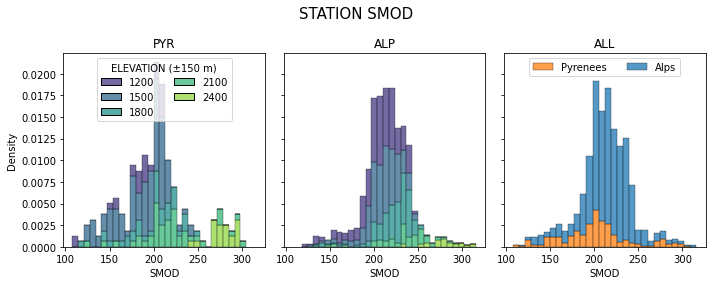

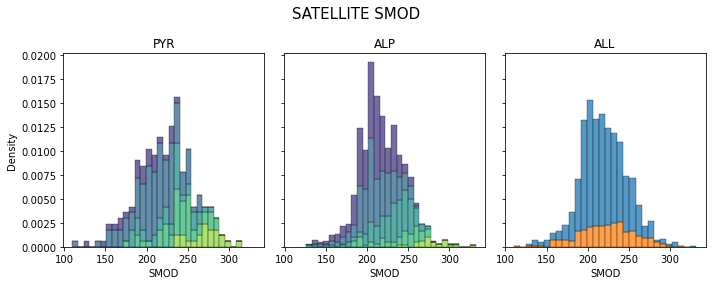

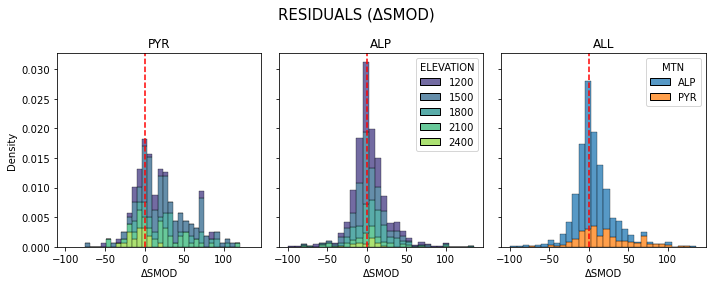

In [39]:
plot_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/PLOTS"

def draw_modes(plot,ax):
    for line in plot.get_lines():
        x, y = line.get_data()
        color = line.get_color()
        #print(x[np.argmax(y)])
        ax.axvline(x[np.argmax(y)], ls='--', color=color)

df_temp = df.query(" (MODEL == 'TB' | MODEL == 'S2') & MIN_DEPTH == 1 & SMOD > 0 & SCD >= 90  & ELEVATION > 900 & ELEVATION < 2700 ")
df_temp = df_temp.sort_values(by='ELEVATION')
df_temp["ELEVATION"] = df_temp["ELEVATION"].astype(int).astype(str)
print(df_temp.groupby(["MTN","ELEVATION"])["SMOD"].count())


fig, axs = plt.subplots(1,3,sharex='row',sharey="all")
axs[2].set_xbound(-100,100)
stations_kde = sn.histplot(ax=axs[0],data = df_temp.query("MTN == 'PYR'"),x="INSITU_SMOD",hue='ELEVATION',stat = 'density',bins=30, common_norm = True,multiple='stack',palette="viridis")
stations_kde = sn.histplot(ax=axs[1],data = df_temp.query("MTN == 'ALP'"),x="INSITU_SMOD",hue='ELEVATION',stat = 'density',bins=30,common_norm = True,multiple='stack',palette="viridis",legend=False)
stations_kde = sn.histplot(ax=axs[2],data = df_temp,x="INSITU_SMOD",hue='MTN',hue_order=["ALP","PYR"],stat = 'density',bins=30,common_norm = True,multiple='stack')
axs[0].set_title("PYR")
axs[1].set_title("ALP")
axs[2].set_title("ALL")
axs[0].set_xlabel("SMOD")
axs[1].set_xlabel("SMOD")
axs[2].set_xlabel("SMOD")
plt.suptitle("STATION SMOD",fontsize=15)
sn.move_legend(axs[0], "upper center", ncol=2, title = "ELEVATION (±150 m)")
sn.move_legend(axs[2], "upper center", ncol=2, title = None,labels=['Pyrenees','Alps'])
fig.set_figwidth(10)
fig.tight_layout()
plt.savefig(op.join(plot_path,f'smodgkde_station.pdf'),format="pdf",transparent=False,facecolor='white')


fig, axs = plt.subplots(1,3,sharex='row',sharey="all")
axs[2].set_xbound(-100,100)
stations_kde = sn.histplot(ax=axs[0],data = df_temp.query("MTN == 'PYR'"),x="SMOD",hue='ELEVATION',stat = 'density',bins=30, common_norm = True,multiple='stack',palette="viridis",legend=False)
stations_kde = sn.histplot(ax=axs[1],data = df_temp.query("MTN == 'ALP'"),x="SMOD",hue='ELEVATION',stat = 'density',bins=30,common_norm = True,multiple='stack',palette="viridis",legend=False)
stations_kde = sn.histplot(ax=axs[2],data = df_temp,x="SMOD",hue='MTN',hue_order=["ALP","PYR"],stat = 'density',bins=30,common_norm = True,multiple='stack',legend=False)
axs[0].set_title("PYR")
axs[1].set_title("ALP")
axs[2].set_title("ALL")
axs[0].set_xlabel("SMOD")
axs[1].set_xlabel("SMOD")
axs[2].set_xlabel("SMOD")
plt.suptitle("SATELLITE SMOD",fontsize=15)
fig.set_figwidth(10)
fig.tight_layout()
plt.savefig(op.join(plot_path,f'smodgkde_satellite.pdf'),format="pdf",transparent=False,facecolor='white')



fig, axs = plt.subplots(1,3,sharex='row',sharey="all")
axs[0].axvline(0, ls='--', color='red')
axs[1].axvline(0, ls='--', color='red')
axs[2].axvline(0, ls='--', color='red')
axs[2].set_xbound(-100,100)
stations_kde = sn.histplot(ax=axs[0],data = df_temp.query("MTN == 'PYR'"),x="ΔSMOD",hue='ELEVATION',stat = 'density',bins=30, common_norm = True,multiple='stack',palette="viridis",legend=False)
stations_kde = sn.histplot(ax=axs[1],data = df_temp.query("MTN == 'ALP'"),x="ΔSMOD",hue='ELEVATION',stat = 'density',bins=30,common_norm = True,multiple='stack',palette="viridis")
stations_kde = sn.histplot(ax=axs[2],data = df_temp,x="ΔSMOD",hue='MTN',hue_order=["ALP","PYR"],stat = 'density',bins=30,common_norm = True,multiple='stack')
axs[0].set_title("PYR")
axs[1].set_title("ALP")
axs[2].set_title("ALL")
axs[0].set_xlabel("ΔSMOD")
axs[1].set_xlabel("ΔSMOD")
axs[2].set_xlabel("ΔSMOD")
plt.suptitle("RESIDUALS (ΔSMOD)",fontsize=15)
fig.set_figwidth(10)
fig.tight_layout()
plt.savefig(op.join(plot_path,f'smodgkde_diff.pdf'),format="pdf",transparent=False,facecolor='white')












In [ ]:
def draw_modes(plot,ax):
    for line in plot.get_lines():
        x, y = line.get_data()
        color = line.get_color()
        #print(x[np.argmax(y)])
        ax.axvline(x[np.argmax(y)], ls='--', color=color)

safran_list=['CaPuy','OrSBa']
safran_list=[]
df_temp = df.query(" MODEL == 'TB' & MIN_DEPTH == 1 & SMOD > 0   & MAX_SMOD_ΔOBS == 0 & MIN_PREC == 4 & ELEVATION > 900 ").sort_values(by="NOBS")
print(df_temp.groupby(["MTN","NOBS_RANGE"])["SMOD"].count())
fig, axs = plt.subplots(3,3,sharex='row',sharey="all")
stations_kde = sn.kdeplot(ax=axs[0,0],data = df_temp.query("MTN == 'PYR'"),x="INSITU_SMOD",hue='NOBS_RANGE',common_norm = True,multiple='stack',palette="viridis",legend=False)
stations_kde = sn.kdeplot(ax=axs[1,0],data = df_temp.query("MTN == 'PYR'"),x="SMOD",hue='NOBS_RANGE',common_norm = True,multiple='stack',palette="viridis",legend=False)
stations_kde = sn.kdeplot(ax=axs[2,0],data = df_temp.query("MTN == 'PYR'"),x="ΔSMOD",hue='NOBS_RANGE',common_norm = True,multiple='stack',palette="viridis",legend=False)
axs[2,0].axvline(0, ls='--', color='red')
axs[2,0].set_xbound(-100,100)
axs[0,0].set_title("PYR")
stations_kde = sn.kdeplot(ax=axs[0,1],data = df_temp.query("MTN == 'ALP'"),x="INSITU_SMOD",hue='NOBS_RANGE',common_norm = True,multiple='stack',palette="viridis",legend=False)
stations_kde = sn.kdeplot(ax=axs[1,1],data = df_temp.query("MTN == 'ALP'"),x="SMOD",hue='NOBS_RANGE',common_norm = True,multiple='stack',palette="viridis",legend=False)
stations_kde = sn.kdeplot(ax=axs[2,1],data = df_temp.query("MTN == 'ALP'"),x="ΔSMOD",hue='NOBS_RANGE',common_norm = True,multiple='stack',palette="viridis")
axs[2,1].axvline(0, ls='--', color='red')
axs[2,1].set_xbound(-100,100)
axs[0,1].set_title("ALP")
stations_kde = sn.kdeplot(ax=axs[0,2],data = df_temp,x="INSITU_SMOD",hue='MTN',hue_order=["ALP","PYR"],common_norm = True,multiple='stack')
#draw_modes(stations_kde,axs[0,0])
stations_kde = sn.kdeplot(ax=axs[1,2],data = df_temp,x="SMOD",hue='MTN',hue_order=["ALP","PYR"],common_norm = True,multiple='stack')
#draw_modes(stations_kde,axs[0,1])
stations_kde = sn.kdeplot(ax=axs[2,2],data = df_temp,x="ΔSMOD",hue='MTN',hue_order=["ALP","PYR"],common_norm = True,multiple='stack')
axs[2,2].axvline(0, ls='--', color='red')
axs[2,2].set_xbound(-100,100)
#draw_modes(stations_kde,axs[0,2])






fig.set_figwidth(12)
fig.set_figheight(12)

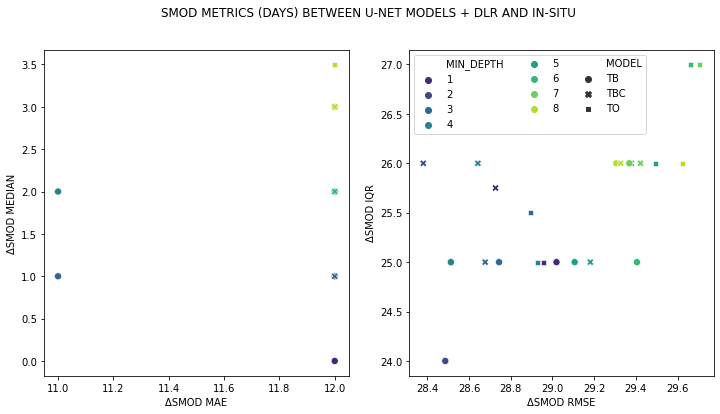

In [20]:
#study snow depth sensibility for each models
plot_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/PLOTS"

def r2_rmse_interval(g):
    r2 = r2_score( g['INSITU_SMOD'], g['SMOD'] )
    rmse = np.sqrt( mean_squared_error( g['INSITU_SMOD'], g['SMOD'] ))
    return pd.Series( dict(  r2 = r2, rmse = rmse) )

def mae_interval(g):
    mae = median_absolute_error( g['INSITU_SMOD'], g['SMOD'] )
    return pd.Series( dict( mae = mae) )

#sn.set_style("whitegrid", {'grid.color': 'red'})
df_temp = df.query(" SMOD > 0 & (MODEL == 'TB' | MODEL == 'TO' | MODEL == 'TBC' | MODEL == 'L')  & MIN_DEPTH <= 1 ")








#fig, axs = plt.subplots()
#sn.boxplot(ax=axs,data = df_temp.query("MIN_PREC == 4 & MAX_SMOD_ΔOBS == 0"),x = 'ELEVATION',y='ΔSMOD',hue='MODEL',showfliers=False)

#axs.axhline(0, ls='--', color='red')

#fig.set_figwidth(12)
#fig.set_figheight(6)
#plt.savefig(op.join(plot_path,f'1.png'),format="png")






df_temp = df.query(" SMOD > 0  & MIN_DEPTH <= 8  & (MODEL == 'TB' | MODEL == 'TO' | MODEL == 'TBC')")
df_temp_3 = df_temp.groupby(['MIN_PREC','MIN_DEPTH','MODEL','MAX_SMOD_ΔOBS'])['ΔSMOD'].mean().to_frame('ΔSMOD_MEAN')
df_temp_3["ΔSMOD_MEDIAN"] = df_temp.groupby(['MIN_PREC','MIN_DEPTH','MODEL','MAX_SMOD_ΔOBS'])['ΔSMOD'].median()
df_temp_3[["ΔSMOD_MAE"]] = df_temp.groupby(['MIN_PREC','MIN_DEPTH','MODEL','MAX_SMOD_ΔOBS']).apply( mae_interval )
df_temp_3["ABLATION_NOBS_MEDIAN"] = df_temp.groupby(['MIN_PREC','MIN_DEPTH','MODEL','MAX_SMOD_ΔOBS'])['ABLATION_NOBS'].median()
df_temp_3["ABLATION_NOBS_MEAN"] = df_temp.groupby(['MIN_PREC','MIN_DEPTH','MODEL','MAX_SMOD_ΔOBS'])['ABLATION_NOBS'].mean()
df_temp_3["ΔSMOD_STD"] = df_temp.groupby(['MIN_PREC','MIN_DEPTH','MODEL','MAX_SMOD_ΔOBS'])['ΔSMOD'].std()
df_temp_3["ΔSMOD_COUNT"] = df_temp.groupby(['MIN_PREC','MIN_DEPTH','MODEL','MAX_SMOD_ΔOBS'])['ΔSMOD'].count()
df_temp_3["ΔSMOD_Q1"] = df_temp.groupby(['MIN_PREC','MIN_DEPTH','MODEL','MAX_SMOD_ΔOBS'])['ΔSMOD'].quantile(0.25)
df_temp_3["ΔSMOD_Q3"] = df_temp.groupby(['MIN_PREC','MIN_DEPTH','MODEL','MAX_SMOD_ΔOBS'])['ΔSMOD'].quantile(0.75)
df_temp_3["NOBS_MEAN"] = df_temp.groupby(['MIN_PREC','MIN_DEPTH','MODEL','MAX_SMOD_ΔOBS'])['NOBS'].mean()
df_temp_3["NOBS_MEDIAN"] = df_temp.groupby(['MIN_PREC','MIN_DEPTH','MODEL','MAX_SMOD_ΔOBS'])['NOBS'].median()
df_temp_3["ΔSMOD_IQR"]  = df_temp_3.ΔSMOD_Q3  - df_temp_3.ΔSMOD_Q1 
df_temp_3["ci95_lo"] = df_temp_3.ΔSMOD_MEAN - 1.96*df_temp_3.ΔSMOD_STD/np.sqrt(df_temp_3.ΔSMOD_COUNT)
df_temp_3["ci95_hi"] = df_temp_3.ΔSMOD_MEAN + 1.96*df_temp_3.ΔSMOD_STD/np.sqrt(df_temp_3.ΔSMOD_COUNT)
df_temp_3["ΔSMOD_CI"]  = df_temp_3.ci95_hi  - df_temp_3.ci95_lo 
df_temp_3[["SMOD_R2",'SMOD_RMSE']]  =  df_temp.groupby(['MIN_PREC','MIN_DEPTH','MODEL','MAX_SMOD_ΔOBS']).apply( r2_rmse_interval )
df_temp_3 = df_temp_3.drop(columns=["ΔSMOD_Q1","ΔSMOD_Q3","ci95_lo","ci95_hi","SMOD_R2"])
#print(df_temp_2)
df_temp_3 = df_temp_3.reset_index()
#print(df_temp_2.sort_values(by=['ΔSMOD MEAN','ΔSMOD STD']))
df_temp_3['MIN_DEPTH'] = df_temp_3['MIN_DEPTH'].astype(str)




scatter_opt={'hue':'MIN_DEPTH','style':'MODEL','palette':'viridis','s':50}

#fig, axs = plt.subplots(3,2,sharey='col',sharex='col')
fig, axs = plt.subplots(1,2)
sn.scatterplot(ax=axs[0],data = df_temp_3.query("MIN_PREC == 4 & MAX_SMOD_ΔOBS == 0"),x = 'ΔSMOD_MAE',y='ΔSMOD_MEDIAN',**scatter_opt)
sn.scatterplot(ax=axs[1],data = df_temp_3.query("MIN_PREC == 4 & MAX_SMOD_ΔOBS == 0"),x = 'SMOD_RMSE',y='ΔSMOD_IQR',**scatter_opt)

axs[0].get_legend().remove()
axs[1].legend(ncol=3)
axs[0].set_xlabel('ΔSMOD MAE')
axs[0].set_ylabel('ΔSMOD MEDIAN')
axs[1].set_xlabel('ΔSMOD RMSE')
axs[1].set_ylabel('ΔSMOD IQR')
plt.suptitle("SMOD METRICS (DAYS) BETWEEN U-NET MODELS + DLR AND IN-SITU")
fig.set_figwidth(12)
fig.set_figheight(6)
plt.savefig(op.join(plot_path,f'1.png'),format="png")



In [ ]:
#study nobs sensibility
def r2_rmse_interval(g):
    #r2 = r2_score( g['INSITU_SMOD'], g['SMOD'] )
    rmse = np.sqrt( mean_squared_error( g['INSITU_SMOD'], g['SMOD'] ))
    return pd.Series( dict(  rmse = rmse) )


df_temp = df.query("  SMOD > 0 &  MIN_DEPTH == 4 & (MODEL != 'TCD-CIRRUS-BLUE' & MODEL != 'TCD-ONLY') ")


df_temp_2 = df_temp.groupby(['NOBS','MTN','MODEL'])['ΔSMOD'].mean().to_frame('ΔSMOD_MEAN')
df_temp_2["ΔSMOD_MEDIAN"] = df_temp.groupby(['NOBS','MTN','MODEL'])['ΔSMOD'].median()
df_temp_2["ΔSMOD_STD"] = df_temp.groupby(['NOBS','MTN','MODEL'])['ΔSMOD'].std()
df_temp_2["ΔSMOD_COUNT"] = df_temp.groupby(['NOBS','MTN','MODEL'])['ΔSMOD'].count()
df_temp_2["ΔSMOD_Q1"] = df_temp.groupby(['NOBS','MTN','MODEL'])['ΔSMOD'].quantile(0.25)
df_temp_2["ΔSMOD_Q3"] = df_temp.groupby(['NOBS','MTN','MODEL'])['ΔSMOD'].quantile(0.75)
df_temp_2["ΔSMOD_IQR"]  = df_temp_2.ΔSMOD_Q3  - df_temp_2.ΔSMOD_Q1 
df_temp_2["ci95_lo"] = df_temp_2.ΔSMOD_MEAN - 1.96*df_temp_2.ΔSMOD_STD/np.sqrt(df_temp_2.ΔSMOD_COUNT)
df_temp_2["ci95_hi"] = df_temp_2.ΔSMOD_MEAN + 1.96*df_temp_2.ΔSMOD_STD/np.sqrt(df_temp_2.ΔSMOD_COUNT)
df_temp_2["ΔSMOD_CI"]  = df_temp_2.ci95_hi  - df_temp_2.ci95_lo 
df_temp_2[['SMOD_RMSE']]  =  df_temp.groupby(['NOBS','MTN','MODEL']).apply( r2_rmse_interval )
df_temp_2 = df_temp_2.reset_index()
df_melt_nobs = df_temp_2.melt(id_vars=['NOBS','MTN','MODEL'], value_vars=['ΔSMOD_MEDIAN','ΔSMOD_MEAN','ΔSMOD_STD','ΔSMOD_IQR','SMOD_RMSE'],var_name='ΔSMOD_METRIC', value_name='METRIC_VALUE')
print(df_melt_nobs)

df_temp_3 = df_temp.groupby(['HYDRO_YEAR','MTN','MODEL'])['ΔSMOD'].mean().to_frame('ΔSMOD_MEAN')
df_temp_3["ΔSMOD_MEDIAN"] = df_temp.groupby(['HYDRO_YEAR','MTN','MODEL'])['ΔSMOD'].median()
df_temp_3["ΔSMOD_STD"] = df_temp.groupby(['HYDRO_YEAR','MTN','MODEL'])['ΔSMOD'].std()
df_temp_3["ΔSMOD_COUNT"] = df_temp.groupby(['HYDRO_YEAR','MTN','MODEL'])['ΔSMOD'].count()
df_temp_3["ΔSMOD_Q1"] = df_temp.groupby(['HYDRO_YEAR','MTN','MODEL'])['ΔSMOD'].quantile(0.25)
df_temp_3["ΔSMOD_Q3"] = df_temp.groupby(['HYDRO_YEAR','MTN','MODEL'])['ΔSMOD'].quantile(0.75)
df_temp_3["ΔSMOD_IQR"]  = df_temp_3.ΔSMOD_Q3  - df_temp_3.ΔSMOD_Q1 
df_temp_3["ci95_lo"] = df_temp_3.ΔSMOD_MEAN - 1.96*df_temp_3.ΔSMOD_STD/np.sqrt(df_temp_3.ΔSMOD_COUNT)
df_temp_3["ci95_hi"] = df_temp_3.ΔSMOD_MEAN + 1.96*df_temp_3.ΔSMOD_STD/np.sqrt(df_temp_3.ΔSMOD_COUNT)
df_temp_3["ΔSMOD_CI"]  = df_temp_3.ci95_hi  - df_temp_3.ci95_lo 
df_temp_3[['SMOD_RMSE']]  =  df_temp.groupby(['HYDRO_YEAR','MTN','MODEL']).apply( r2_rmse_interval )
df_temp_3 = df_temp_3.drop(columns=["ΔSMOD_Q1","ΔSMOD_Q3","ci95_lo","ci95_hi"])
df_temp_3 = df_temp_3.reset_index()
df_melt_insitu_nobs = df_temp_3.melt(id_vars=['HYDRO_YEAR','MTN','MODEL'], value_vars=['ΔSMOD_MEDIAN','ΔSMOD_MEAN','ΔSMOD_STD','ΔSMOD_IQR','SMOD_RMSE'],var_name='ΔSMOD_METRIC', value_name='METRIC_VALUE')
print(df_melt_insitu_nobs)








fig, axs = plt.subplots(3)
sn.boxplot(ax=axs[0],data = df_temp,x = 'MTN',y='NOBS',hue="MODEL",showfliers=False)
sn.lineplot(ax=axs[1],data = df_melt_nobs.query("ΔSMOD_METRIC == 'ΔSMOD_MEDIAN' & (MODEL == 'SWH+LANDSAT')"),x = 'NOBS',y='METRIC_VALUE',hue='MODEL',style='MTN')
sn.lineplot(ax=axs[2],data = df_melt_insitu_nobs.query(" ΔSMOD_METRIC == 'ΔSMOD_MEDIAN' & (MODEL == 'SWH+LANDSAT' )"),x = 'HYDRO_YEAR',y='METRIC_VALUE',hue='MODEL',style='MTN')
axs[0].grid()
axs[1].grid()
axs[2].grid()
#axs[2].get_legend().remove()
handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles=handles[0:], labels=labels[0:])
fig.set_figwidth(12)
fig.set_figheight(10)

In [ ]:
df_temp = df.query("SMOD > 0  & MODEL == 'SWH+LANDSAT' & MIN_DEPTH == 4 & MTN == 'PYR'")
sorted_safran = df_temp["SAFRAN"].value_counts().index.tolist()
df_temp['SAFRAN'] = pd.Categorical(df_temp['SAFRAN'],sorted_safran)
print(sorted_safran)

fig, axs = plt.subplots(3,sharex=True)
sn.histplot(ax=axs[0],data = df_temp,x = 'SAFRAN',hue='MTN')
sn.scatterplot(ax=axs[1],data = df_temp,x = 'SAFRAN',y='ALT',hue='MTN')
sn.boxplot(ax=axs[2],data = df_temp,x = 'SAFRAN',y='ΔSMOD',hue='MTN',showfliers=False)
plt.xticks(rotation=45)
axs[2].grid()

fig.set_figwidth(10)
fig.set_figheight(10)



In [ ]:
#SAFRAN OPTION A : calculate smod median trend per massif per elevation
#SAFRAN OPTION A.1 OLD: calculate yearly smod median

model="TCD-BLUE_AVG-1200"
synthese_model = f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/LANDSAT_SWH_MERGED/{model}"
plot_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/PLOTS"
#SAFRAN_PATH = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SAFRAN/GR_alps_safran_31.shp"
GLACIER_PATH= "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/GLACIERS"
DEM_PATH= "/home/ad/barrouz/Neige/DEM"
TCD_PATH = "/home/ad/barrouz/datalake/static_aux/TreeCoverDensity"
TMP_PATH = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/TMP/tmp.tif"
drv = ogr.GetDriverByName( 'ESRI Shapefile' )
#safran_shp = drv.Open(SAFRAN_PATH)
#shapefile = gpd.read_file(SAFRAN_PATH)
#geoms = (shapefile.query("title == 'Grandes-Rousses'")).geometry.values # list of shapely geometries
#geoms = [mapping(geoms[0])]



dict_massif_trends = {'ELEVATION':[],'SAFRAN':[],
                   'MTN':[], 'MEDIAN':[], 'METRIC':[], 'PIXEL_COUNT':[], 'MASK':[], 'HYDRO_YEAR':[]}



period = range(1986,2015)
metric_list= ["SMOD"]
TCD_max = 50
DTM_step = 300
DTM_min = 1200
DTM_max= 4500
MIN_NOBS = 8
MIN_SCD = 60

for mtn in SAFRAN_tiles_2:
    for massif in SAFRAN_tiles_2[mtn]:
        tile_list = SAFRAN_tiles_2[mtn][massif]
        epsg_nb = (tile_list[0])[:2]
        SAFRAN_PATH = f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SAFRAN/safran_{epsg_nb}.shp"
        shapefile = gpd.read_file(SAFRAN_PATH)
        geoms = (shapefile.query(f"title == '{massif}'")).geometry.values
        geoms = [mapping(geoms[0])]
        print("\n")
        print(massif)


        #TCD
        raster_list = []
        for tile in tile_list:
            tcd_path = os.path.join(TCD_PATH,tile,f'TCD_{tile}.tif')
            raster_list.append(tcd_path)
        merge(raster_list,dst_path = TMP_PATH,nodata=255)
        with rasterio.open(TMP_PATH) as src:
            tcd, out_transform = mask(src, geoms, crop=True,nodata=255)
            tcd = tcd[0].flatten()
        os.system(f"rm {TMP_PATH}")

        #GLACIER
        raster_list = []
        for tile in tile_list:
            gla_path = os.path.join(GLACIER_PATH,f'glacier_{tile}.tif')
            raster_list.append(gla_path)
        merge(raster_list,dst_path = TMP_PATH,nodata=255)
        with rasterio.open(TMP_PATH) as src:
            gla, out_transform = mask(src, geoms, crop=True,nodata=255)
            gla = gla[0].flatten()
        os.system(f"rm {TMP_PATH}")
        
        #ELEVATION
        raster_list = []
        for tile in tile_list:
            dem_path = os.path.join(DEM_PATH,f"S2__TEST_AUX_REFDE2_T{tile}_0001.DBL.DIR",f'S2__TEST_AUX_REFDE2_T{tile}_0001_ALT_R2.TIF')
            raster_list.append(dem_path)
        merge(raster_list,dst_path = TMP_PATH,nodata=0)
        with rasterio.open(TMP_PATH) as src:
            dem, out_transform = mask(src, geoms, crop=True,nodata=0)
            dem = dem[0].flatten()
        os.system(f"rm {TMP_PATH}")

            
        for i,metric in enumerate(metric_list):
            #mask_zero = None
            ##make mask for pixels with metric = 0 at least once during the period and also for glacier and tcd
            #for year in period:
            #    raster_list=[]
            #    nobs_list=[]
            #    scd_list=[]
            #    for tile in tile_list:
            #        swh_landsat_path = glob.glob(op.join(synthese_model,mtn,tile,"*",f"LIS_S2-SNOW-{metric}_{tile}_{str(year)}*.tif"),recursive=True)
            #        nobs_path = glob.glob(op.join(synthese_model,mtn,tile,"*",f"LIS_S2-SNOW-NOBS_{tile}_{str(year)}*.tif"),recursive=True)
            #        scd_path = glob.glob(op.join(synthese_model,mtn,tile,"*",f"LIS_S2-SNOW-SCD_{tile}_{str(year)}*.tif"),recursive=True)
            #        if len(swh_landsat_path) == 1:
            #            raster_list.extend(swh_landsat_path)
            #            nobs_list.extend(nobs_path)
            #            scd_list.extend(scd_path)
            #    if len(raster_list) == 0:
            #        print("ERROR MISSING SYNTHESIS FOR",mtn,tile_list,year)
            #    #print(raster_list)
            #    merge(raster_list,dst_path = TMP_PATH,nodata=0)
            #    with rasterio.open(TMP_PATH) as src:
            #        swh_landsat, out_transform = mask(src, geoms, crop=True,nodata=0)
            #        swh_landsat = swh_landsat[0].flatten()
            #    os.system(f"rm {TMP_PATH}")
            #    merge(nobs_list,dst_path = TMP_PATH,nodata=0)
            #    with rasterio.open(TMP_PATH) as src:
            #        nobs, out_transform = mask(src, geoms, crop=True,nodata=0)
            #        nobs = nobs[0].flatten()
            #    os.system(f"rm {TMP_PATH}")
            #    merge(scd_list,dst_path = TMP_PATH,nodata=0)
            #    with rasterio.open(TMP_PATH) as src:
            #        scd, out_transform = mask(src, geoms, crop=True,nodata=0)
            #        scd = scd[0].flatten()
            #    os.system(f"rm {TMP_PATH}")
            #    
            #    if mask_zero is None: 
            #        mask_zero = np.where((swh_landsat == 0) | (nobs < MIN_NOBS)| (scd < MIN_SCD)  ,1,0)
            #    else:
            #        mask_zero = np.where((swh_landsat == 0) | (nobs < MIN_NOBS) | (scd < MIN_SCD) ,mask_zero += 1,mask_zero)
            #    print(f"{mtn} {massif} {metric} MASK {year} ",end="                            \r")
            #    #print(year,"TCD",tcd.shape,"gla",gla.shape,"dem",dem.shape,"swh_landsat",swh_landsat.shape,"mask_zero",mask_zero.shape) 
            #mask_zero = np.where((tcd >= TCD_max) | (gla == 1) ,400,mask_zero)
            
            
            for year in period:
                raster_list=[]
                nobs_list=[]
                scd_list=[]
                for tile in tile_list:
                    swh_landsat_path = glob.glob(op.join(synthese_model,mtn,tile,"*",f"LIS_S2-SNOW-{metric}_{tile}_{str(year)}*.tif"),recursive=True)
                    nobs_path = glob.glob(op.join(synthese_model,mtn,tile,"*",f"LIS_S2-SNOW-NOBS_{tile}_{str(year)}*.tif"),recursive=True)
                    scd_path = glob.glob(op.join(synthese_model,mtn,tile,"*",f"LIS_S2-SNOW-SCD_{tile}_{str(year)}*.tif"),recursive=True)
                    if len(swh_landsat_path) == 1:
                        raster_list.extend(swh_landsat_path)
                        nobs_list.extend(nobs_path)
                        scd_list.extend(scd_path)
                if len(raster_list) == 0:
                    print("ERROR MISSING SYNTHESIS FOR",mtn,tile_list,year)
                merge(raster_list,dst_path = TMP_PATH)
                with rasterio.open(TMP_PATH) as src:
                    swh_landsat, out_transform = mask(src, geoms, crop=True,nodata=0)
                    swh_landsat = swh_landsat[0].flatten()
                os.system(f"rm {TMP_PATH}")
                merge(nobs_list,dst_path = TMP_PATH,nodata=0)
                with rasterio.open(TMP_PATH) as src:
                    nobs, out_transform = mask(src, geoms, crop=True,nodata=0)
                    nobs = nobs[0].flatten()
                os.system(f"rm {TMP_PATH}")
                merge(scd_list,dst_path = TMP_PATH,nodata=0)
                with rasterio.open(TMP_PATH) as src:
                    scd, out_transform = mask(src, geoms, crop=True,nodata=0)
                    scd = scd[0].flatten()
                os.system(f"rm {TMP_PATH}")

                for ele in range(DTM_min,DTM_max+1,DTM_step):
                    #print(f"{mtn} {massif} {metric} {ele} MEDIAN {year}")
                    #with masking of period interupted pixels
                    #swh_landsat_ele = swh_landsat[ (dem >= ele - DTM_step/2) & (dem < ele + DTM_step/2) & (mask_zero == 0)]
                    #count = len(swh_landsat_ele)
                    #if count >= 2:
                    #    year_median = np.median(swh_landsat_ele)
                    #    dict_massif_trends['ELEVATION'].append(ele)
                    #    dict_massif_trends['SAFRAN'].append(massif)
                    #    dict_massif_trends['MTN'].append(mtn)
                    #    dict_massif_trends['METRIC'].append(metric)
                    #    dict_massif_trends['MEDIAN'].append(year_median)
                    #    dict_massif_trends['HYDRO_YEAR'].append(year)
                    #    dict_massif_trends['PIXEL_COUNT'].append(count)
                    #    dict_massif_trends['MASK'].append('PERIOD')
                    #with masking of SMOD > 0
                    swh_landsat_ele = swh_landsat[ (dem >= ele - DTM_step/2) & (dem < ele + DTM_step/2)& (swh_landsat > 0)]
                    count = len(swh_landsat_ele)
                    if count >= 2:
                        #print("no mask:",count)
                        year_median = np.median(swh_landsat_ele)
                        dict_massif_trends['ELEVATION'].append(ele)
                        dict_massif_trends['SAFRAN'].append(massif)
                        dict_massif_trends['MTN'].append(mtn)
                        dict_massif_trends['METRIC'].append(metric)
                        dict_massif_trends['MEDIAN'].append(year_median)
                        dict_massif_trends['HYDRO_YEAR'].append(year)
                        dict_massif_trends['PIXEL_COUNT'].append(count)
                        dict_massif_trends['MASK'].append('None')
                    swh_landsat_ele = swh_landsat[ (dem >= ele - DTM_step/2) & (dem < ele + DTM_step/2) & (swh_landsat > 0)& (scd >= MIN_SCD)  ]
                    count = len(swh_landsat_ele)
                    if count >= 2:
                        #print("SCD:",count)
                        year_median = np.median(swh_landsat_ele)
                        dict_massif_trends['ELEVATION'].append(ele)
                        dict_massif_trends['SAFRAN'].append(massif)
                        dict_massif_trends['MTN'].append(mtn)
                        dict_massif_trends['METRIC'].append(metric)
                        dict_massif_trends['MEDIAN'].append(year_median)
                        dict_massif_trends['HYDRO_YEAR'].append(year)
                        dict_massif_trends['PIXEL_COUNT'].append(count)
                        dict_massif_trends['MASK'].append('SCD')
                    swh_landsat_ele = swh_landsat[ (dem >= ele - DTM_step/2) & (dem < ele + DTM_step/2) & (swh_landsat > 0)& (scd >= MIN_SCD) & (nobs >=MIN_NOBS ) ]
                    count = len(swh_landsat_ele)
                    if count >= 2:
                        #print("SCD_NOBS:",count)
                        year_median = np.median(swh_landsat_ele)
                        dict_massif_trends['ELEVATION'].append(ele)
                        dict_massif_trends['SAFRAN'].append(massif)
                        dict_massif_trends['MTN'].append(mtn)
                        dict_massif_trends['METRIC'].append(metric)
                        dict_massif_trends['MEDIAN'].append(year_median)
                        dict_massif_trends['HYDRO_YEAR'].append(year)
                        dict_massif_trends['PIXEL_COUNT'].append(count)
                        dict_massif_trends['MASK'].append('SCD_NOBS')
            
            
                    print(f"{mtn} {massif} {metric} {ele} MEDIAN {year}",end="                              \r")
            
            
df_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/DATAFRAMES/safran_yearly_metrics_nobs_30.pkl"
df = pd.DataFrame(data=dict_massif_trends)

df.to_pickle(df_path)         
            
            
            
            
            
            
            
            
            





In [ ]:
#SAFRAN OPTION A.2 OLD: open dataframe
df_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/DATAFRAMES/safran_yearly_metrics_nobs_30.pkl"
with open( df_path, "rb" )  as dp:
    df = pickle.load(dp)  
print(df.MEDIAN.isna().sum())
#on s'assure d'avoir 29 valeurs par massif/elevation/mask/metric pour le mk test
extension = df.groupby(["ELEVATION","SAFRAN","MASK","METRIC"])["HYDRO_YEAR"].agg(["min", "max"]).reset_index()
extension["HYDRO_YEAR"] = extension.apply(lambda x: list(range(x["min"], x["max"] + 1)), axis=1)
extension = extension.explode("HYDRO_YEAR")[["ELEVATION","SAFRAN","MASK","METRIC", "HYDRO_YEAR"]]
extension["HYDRO_YEAR"] = extension["HYDRO_YEAR"].astype(int)
df = df.merge(extension, how="right", on=["ELEVATION","SAFRAN","MASK","METRIC", "HYDRO_YEAR"])
df.loc[(df.PIXEL_COUNT < 100),'MEDIAN'] = np.nan
print(df)
print(df.MEDIAN.isna().sum())
print(df.MEDIAN.count())
print(df.HYDRO_YEAR.value_counts())
print(df.query("MEDIAN.isnull() ", engine='python').SAFRAN.unique())
print(df.loc[(df.ELEVATION == 3900) & (df.SAFRAN == 'Vanoise') & (df.MASK == 'SCD_NOBS'),'MEDIAN'])

In [28]:
#SAFRAN OPTION A.1 NEW: calculate yearly smod median
account = "cesbio"
log_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/LOGS"
job_sh_path = "/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/synthesis_code/safran_median_aspect_MK.sh"
job_common_params =  " ".join(
    [
        "-A",account,
        " --job-name={}",
        " --time=06:59:59",
        "-N","1","-n","8",
        "--mem-per-cpu=8000M",
        "-o",log_path+"/{}",
        "--export=ALL,{}",job_sh_path
    ]
)

for mtn in SAFRAN_tiles_2:
    for i,massif in enumerate(SAFRAN_tiles_2[mtn]):

        jobname=f"{mtn}_{i}_MK"
        export =  ",".join([ f"MTN=\"{mtn}\",MASSIF=\"{massif}\",N=\"{i}\""])
        os.system("sbatch "+job_common_params.format(jobname,jobname+".log",export))  
        
            
            
            
            

Submitted batch job 21297737
Submitted batch job 21297738
Submitted batch job 21297739
Submitted batch job 21297740
Submitted batch job 21297741
Submitted batch job 21297742
Submitted batch job 21297743
Submitted batch job 21297744
Submitted batch job 21297745
Submitted batch job 21297746
Submitted batch job 21297747
Submitted batch job 21297748
Submitted batch job 21297749
Submitted batch job 21297750
Submitted batch job 21297751
Submitted batch job 21297752
Submitted batch job 21297753
Submitted batch job 21297754
Submitted batch job 21297755
Submitted batch job 21297756
Submitted batch job 21297757
Submitted batch job 21297758
Submitted batch job 21297759
Submitted batch job 21297760
Submitted batch job 21297761
Submitted batch job 21297762
Submitted batch job 21297763
Submitted batch job 21297764
Submitted batch job 21297765
Submitted batch job 21297766
Submitted batch job 21297767
Submitted batch job 21297768
Submitted batch job 21297769
Submitted batch job 21297770
Submitted batc

In [7]:
list_df = glob.glob(f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/DATAFRAMES/safran_median_4_aspect*.pkl")
with open( list_df[1], "rb" )  as dp:
    df = pickle.load(dp) 
print(df.query("TOPO == 'DAH' & PIXEL_COUNT >= 1000 & MIN_NOBS == 20 & ELEVATION == 2100 ").reset_index(drop=True))

     ELEVATION     SAFRAN  MTN  SMOD_MEDIAN  PIXEL_COUNT  PIXEL_RATIO  \
0         2100  Jacetiana  PYR        253.0        13361         49.0   
1         2100  Jacetiana  PYR        247.0        23863         47.0   
2         2100  Jacetiana  PYR        239.0        25240         42.0   
3         2100  Jacetiana  PYR        237.0        18119         42.0   
4         2100  Jacetiana  PYR        239.0         1244         44.0   
..         ...        ...  ...          ...          ...          ...   
178       2100  Jacetiana  PYR        244.0        25748         95.0   
179       2100  Jacetiana  PYR        236.0        46849         92.0   
180       2100  Jacetiana  PYR        218.0        50014         84.0   
181       2100  Jacetiana  PYR        213.0        32597         77.0   
182       2100  Jacetiana  PYR        207.0         1842         65.0   

     PIXEL_RATIO_SNOW  MIN_NOBS TOPO  TOPO_VALUE  HYDRO_YEAR DATASET  
0                50.0        20  DAH        -0.1    

In [5]:
#SAFRAN OPTION A.2 NEW: concatenate all dataframes
list_df = glob.glob(f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/DATAFRAMES/swhlx_theia_safran_median_aspect_hydro_rgi_*.pkl")

with open( list_df[0], "rb" )  as dp:
    df = pickle.load(dp) 
for l in list_df[1:]:
    with open( l, "rb" )  as dp:
        df2 = pickle.load(dp) 
    df = pd.concat([df,df2],ignore_index=True)
df.to_pickle(f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/DATAFRAMES/SWHLX_THEIA_ALL_MK.pkl")


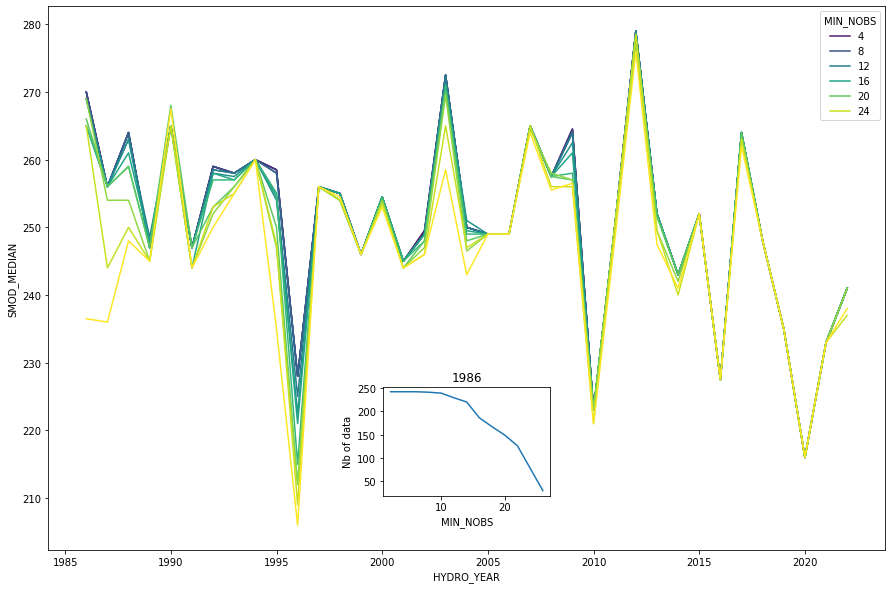

In [6]:

with open( f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/DATAFRAMES/SWHLX_THEIA_ALL_MK.pkl", "rb" )  as dp:
    df = pickle.load(dp) 


massif= "Mont-Blanc"
ele = 2400
min_px = 1000
df_temp = df.query("TOPO == 'NONE' ").sort_values(by="MIN_NOBS")
#df_temp["MIN_NOBS"] = df_temp["MIN_NOBS"].astype(str)
df_temp["DATASET"] = np.where((df_temp["DATASET"] == 'TB'),'SWH+LANDSAT',df_temp["DATASET"])

df_simon = df_temp[["ELEVATION","SAFRAN","MTN","SMOD_MEDIAN","PIXEL_COUNT","MIN_NOBS","HYDRO_YEAR","DATASET"]].reset_index(drop=True)
#df_simon.query("SAFRAN == 'Andorre' & ELEVATION == 1200 & HYDRO_YEAR == 2008")
fig, ax = plt.subplots()
sn.lineplot(ax=ax,data=df_simon.query(f"PIXEL_COUNT >= {min_px}  "),x="HYDRO_YEAR",y="SMOD_MEDIAN",hue="MIN_NOBS",palette="viridis",ci = None,estimator = np.median)


#ax.annotate(f"Massif = {massif}\nElevation = {ele} ± 300 m\nMin pixels per median = {int(min_px)}" ,
#                    xy=(0.4, 0.9), xycoords='axes fraction',
#                    ha='left', va='top', fontsize=12,
#                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

ins = ax.inset_axes([0.4,0.1,0.2,0.2])


#sn.barplot(data=df_simon,x= "MIN_NOBS",y = 'SMOD_MEDIAN')


df_count = df_simon.query(f" PIXEL_COUNT >= 1000 & HYDRO_YEAR == 1986").groupby(["MIN_NOBS"])["SMOD_MEDIAN"].count().to_frame("Nb of data").reset_index()

sn.lineplot(ax=ins,data=df_count,x="MIN_NOBS",y="Nb of data")
ins.set_title("1986")

fig.set_figwidth(15)
fig.set_figheight(10)





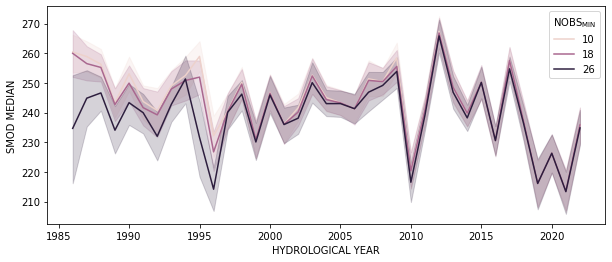

In [38]:

with open( f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/DATAFRAMES/SWHLX_THEIA_MK.pkl", "rb" )  as dp:
    df = pickle.load(dp) 

plot_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/PLOTS"
min_px = 1000
df_temp = df.query("TOPO == 'NONE' ").sort_values(by="MIN_NOBS")
df_temp["DATASET"] = np.where((df_temp["DATASET"] == 'TB'),'SWH+LANDSAT',df_temp["DATASET"])
df_simon = df_temp[["ELEVATION","SAFRAN","MTN","SMOD_MEDIAN","PIXEL_COUNT","MIN_NOBS","HYDRO_YEAR","DATASET"]].reset_index(drop=True)
fig, ax = plt.subplots()
plt.rcParams.update({'mathtext.default':  'regular' })
sn.lineplot(ax=ax,data=df_simon.query(f"PIXEL_COUNT >= {min_px}  & (MIN_NOBS == 10 | MIN_NOBS == 18 | MIN_NOBS == 26 )"),x="HYDRO_YEAR",y="SMOD_MEDIAN",hue="MIN_NOBS",estimator = np.mean)
ax.legend(title="NOBS$_{MIN}$")
ax.set_ylabel("SMOD MEDIAN")
ax.set_xlabel("HYDROLOGICAL YEAR")
fig.set_figwidth(10)
fig.set_figheight(4)


plt.savefig(op.join(plot_path,f'NOBSMIN_2.png'),format="png",transparent=False,facecolor='white', dpi=300)


     MIN_NOBS  HYDRO_YEAR  Nb of data
0           2        1986         246
9           4        1986         246
18          6        1986         246
27          8        1986         245
36         10        1986         243
45         12        1986         233
54         14        1986         225
63         16        1986         190
72         18        1986         172
81         20        1986         153
90         22        1986         129
99         24        1986          80
108        26        1986          30


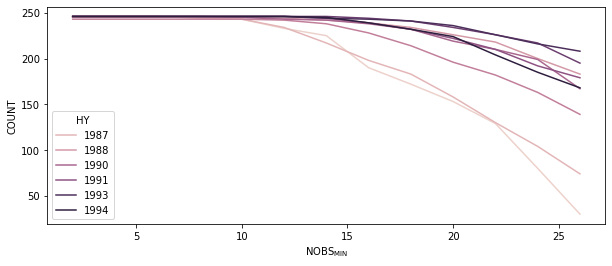

In [37]:
with open( f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/DATAFRAMES/SWHLX_THEIA_ALL_MK.pkl", "rb" )  as dp:
    df = pickle.load(dp) 
df_temp = df.query("TOPO == 'NONE' ").sort_values(by="MIN_NOBS")
plot_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/PLOTS"
df_count = df_temp.query(f" PIXEL_COUNT >= 1000 & HYDRO_YEAR < 1995").groupby(["MIN_NOBS","HYDRO_YEAR"])["SMOD_MEDIAN"].count().to_frame("Nb of data").reset_index()
print(df_count.query("HYDRO_YEAR == 1986"))
df_count = df_count.rename(columns={"HYDRO_YEAR":"HYDRO YEAR"})

fig, ax = plt.subplots()
sn.lineplot(ax=ax,data=df_count,x="MIN_NOBS",y="Nb of data",hue="HYDRO YEAR")
plt.rcParams.update({'mathtext.default':  'regular' })
ax.set_xlabel("NOBS$_{MIN}$")
ax.set_ylabel("COUNT")
ax.legend(title="HY")
fig.set_figwidth(10)
fig.set_figheight(4)
plt.savefig(op.join(plot_path,f'NOBSMIN.png'),format="png",transparent=False,facecolor='white', dpi=300)

<AxesSubplot:xlabel='ELEVATION', ylabel='SMOD_MEDIAN'>

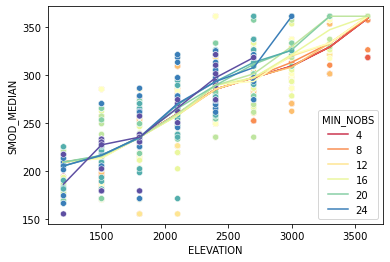

In [11]:
df_count = df_simon.query(f" PIXEL_COUNT >= 1000 & HYDRO_YEAR == 1986  ")

sn.lineplot(data=df_count,y="SMOD_MEDIAN",x="ELEVATION",hue="MIN_NOBS",ci=None,estimator=np.median,palette="Spectral")
sn.scatterplot(data=df_count,y="SMOD_MEDIAN",x="ELEVATION",hue="MIN_NOBS",palette="Spectral",legend=False)


In [84]:
with open( f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/DATAFRAMES/MEDIAN_4_ASPECT_MK.pkl", "rb" )  as dp:
    df = pickle.load(dp) 
df
df_temp = df.query("TOPO == 'NONE'")
df_simon = df_temp[["ELEVATION","SAFRAN","MTN","SMOD_MEDIAN","PIXEL_COUNT","MIN_NOBS","HYDRO_YEAR","DATASET"]].reset_index(drop=True)
df_simon.to_csv(f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/DATAFRAMES/Simon_SMOD_median.csv")


df_simon.query("MTN == 'PYR' & PIXEL_COUNT >= 1000 & MIN_NOBS == 16 & ELEVATION == 2100")


,ELEVATION,SAFRAN,MTN,SMOD_MEDIAN,PIXEL_COUNT,MIN_NOBS,HYDRO_YEAR,DATASET
5818,2100,Jacetiana,PYR,247.0,152878,16,1986,TB
5974,2100,Jacetiana,PYR,256.0,110367,16,1987,TB
6130,2100,Jacetiana,PYR,258.0,114653,16,1988,TB
6286,2100,Jacetiana,PYR,189.0,155932,16,1989,TB
6442,2100,Jacetiana,PYR,264.0,175821,16,1990,TB
...,...,...,...,...,...,...,...,...
253234,2100,Couserans,PYR,249.0,85257,16,2018,THEIA
253390,2100,Couserans,PYR,205.0,84106,16,2019,THEIA
253546,2100,Couserans,PYR,213.0,96362,16,2020,THEIA
253702,2100,Couserans,PYR,248.0,96800,16,2021,THEIA


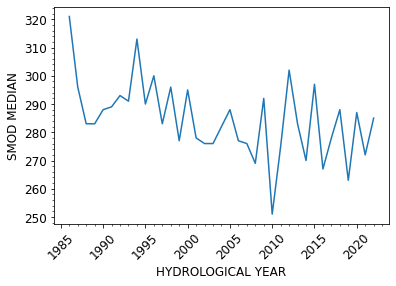

In [17]:
sn.lineplot(data=df.query("PIXEL_COUNT >= 1000  &  SAFRAN == 'Mont-Blanc' & MIN_NOBS == 10 & TOPO == 'NONE' & ELEVATION == 2400"),x="HYDRO_YEAR",y="SMOD_MEDIAN")
plt.xlabel("HYDROLOGICAL YEAR",size=12)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.ylabel("SMOD MEDIAN",size=12)
plt.minorticks_on()

In [ ]:
#SAFRAN OPTION A.3: check for autocorrelation
with open( f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/DATAFRAMES/MEDIAN_4_ASPECT_MK.pkl", "rb" )  as dp:
    df = pickle.load(dp) 
df_mask = df.query("MASK == 'TCDGLASCDNOBS15'")
print(df_mask)
#df_mask['MEDIAN'] = np.where((df_mask["PIXEL_COUNT"] < 100),np.nan,df_mask["MEDIAN"])
df_mask.loc[(df_mask.PIXEL_COUNT < 100),'MEDIAN']=np.nan
for massif in df_mask.SAFRAN.unique():
    print(massif)
    ele_list = df_mask.query(f"SAFRAN == '{massif}'").ELEVATION.unique()
    nb_ele = len(ele_list)
    fig, axs = plt.subplots(1,nb_ele,figsize=(25,2),sharey=True)
    df_msf = df_mask.query(f"SAFRAN == '{massif}'")
    fig.suptitle(massif)
    for i,ele in enumerate(ele_list):
        print(ele)
        data = df_msf.query(f"ELEVATION == {ele}").set_index('HYDRO_YEAR').MEDIAN.tolist()
        if not np.isnan(data).any():
            sm.graphics.tsa.plot_acf(data, lags=20, ax=axs[i],alpha=.05)
            axs[i].set_title(ele, y=1.0,pad=-14)
            axs[i].axhline(y=0.5,xmin=0,xmax=20,c="red",linewidth=0.5,zorder=0)
            axs[i].axhline(y=-0.5,xmin=0,xmax=20,c="red",linewidth=0.5,zorder=0)



In [13]:
#SAFRAN OPTION A.4: mannkendall test for every 20 year periods or more for each massif


min_px_count = 1000


notna_var = pd.notna
def mannkendall(g,sy,ey):
    if g.query("@notna_var(SMOD_MEDIAN)").HYDRO_YEAR.min() == sy and \
       g.query("@notna_var(SMOD_MEDIAN)").HYDRO_YEAR.max() == ey and \
       g["SMOD_MEDIAN"].count() >= (ey - sy + 1)*95/100:
        mk_test = mk.original_test(g.SMOD_MEDIAN, alpha=0.05)
        out = pd.Series( dict(  p = mk_test.p < 0.05 , slope = mk_test.slope, COUNT_YEAR = g.HYDRO_YEAR.count()) )
    else:
        out = pd.Series( dict(  p = False , slope = np.nan, COUNT_YEAR = np.nan) )
    return out

with open( f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/DATAFRAMES/SWHLX_THEIA_ALL_MK.pkl", "rb" )  as dp:
    df = pickle.load(dp) 


#df_mask['MEDIAN'] = np.where((df_mask["PIXEL_COUNT"] < 100),np.nan,df_mask["MEDIAN"])
df = df.query(f"TOPO == 'NONE' & ELEVATION > 1200 & (MIN_NOBS == 26) ")
print(df)
df.loc[(df.PIXEL_COUNT < min_px_count)  ,'SMOD_MEDIAN']=np.nan


list_df = []

for start_year in range(1986,2004):
    
    for end_year in range(start_year + 19,2023):
        print(start_year,end_year,end="           \r")
        
        c = end_year - start_year +1
        
        df_period = df.sort_values(by=["HYDRO_YEAR"]).query(f"HYDRO_YEAR >= {start_year} & HYDRO_YEAR <= {end_year}").groupby(["MTN","ELEVATION","SAFRAN","MIN_NOBS"]).apply(mannkendall,sy=start_year,ey=end_year)
        
        df_period = df_period.reset_index()
        df_period["START_YEAR"] = int(start_year)
        df_period["END_YEAR"] = int(end_year)
        #df_period.dropna(inplace=True)
        list_df.append(df_period)
        

        
df_mk = pd.concat(list_df,ignore_index=True)    
df_mk["slope"] = df_mk["slope"] * 10

              
   

         ELEVATION        SAFRAN  MTN  SMOD_MEDIAN  SOD_MEDIAN  SCD_MEDIAN  \
120           1500       Pelvoux  ALP        181.0       106.0        76.0   
250           1800       Pelvoux  ALP        150.0       106.0        88.0   
380           2100       Pelvoux  ALP        269.0        38.0       252.0   
510           2400       Pelvoux  ALP        269.0        38.0       232.0   
640           2700       Pelvoux  ALP        289.0        38.0       252.0   
...            ...           ...  ...          ...         ...         ...   
2327510       3300  Haute-Ariege  PYR          NaN         NaN         NaN   
2327640       3600  Haute-Ariege  PYR          NaN         NaN         NaN   
2327770       3900  Haute-Ariege  PYR          NaN         NaN         NaN   
2327900       4200  Haute-Ariege  PYR          NaN         NaN         NaN   
2328030       4500  Haute-Ariege  PYR          NaN         NaN         NaN   

         PIXEL_COUNT  MIN_NOBS  TOPO  TOPO_VALUE  HYDRO_YEAR DA

In [ ]:
#for individual massifs 


plot_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/PLOTS"
print(df_mk)
df_mk_nan = df_mk.copy()
notna_var = pd.notna
df_mk_nan["slope"] = np.where((df_mk_nan["p"] == False),np.nan,df_mk_nan["slope"])
df_mk_nan["annot"] = np.where((df_mk_nan["p"] == False) ,int(32),int(8901))

bar_min = -25#df_mk["slope"].values.min()
bar_max = 25#df_mk["slope"].values.max()
ticks=[-25,-20,-15,-10,-5,0,5,10,15,20,25]         


for mtn in SAFRAN_tiles_2:
    for massif in SAFRAN_tiles_2[mtn]:

        for min_obs in range(18,19):
            list_ele = df_mk.query(f"SAFRAN == '{massif}' & @notna_var(slope)")["ELEVATION"].unique()
            if len(list_ele) == 0: continue
            fig, axs = plt.subplots(int(ceil(len(list_ele)/2)),2)
            cbar_ax = fig.add_axes([.91, .3, .03, .4])

            x= 0
            y=0

            for i , elevation in enumerate(list_ele):

                x = i%2 
                
                df_heat = df_mk.query(f"SAFRAN == '{massif}'  & ELEVATION == {elevation} & MIN_NOBS == {min_obs}").pivot(index="END_YEAR", columns="START_YEAR", values="slope")
                df_heat_nan = df_mk_nan.query(f"SAFRAN == '{massif}' & ELEVATION == {elevation} & MIN_NOBS == {min_obs}").pivot(index="END_YEAR", columns="START_YEAR", values="slope")
                df_annot = df_mk_nan.query(f"SAFRAN == '{massif}' & ELEVATION == {elevation} & MIN_NOBS == {min_obs}").pivot(index="END_YEAR", columns="START_YEAR", values="annot")
                df_annot = df_annot.fillna(32).astype('int')




                #print(massif,elevation)
                #im = axs.imshow(df_heat.values,cmap='RdBu',vmin=-2, vmax=2)
                #im2 = axs.scatter(df_heat_p.values)
                if len(list_ele) > 2:
                    axis = axs[y,x]
                else:
                    axis = axs[x]
                sn.heatmap(df_heat,ax=axis,cmap='RdBu',vmin=bar_min, vmax=bar_max,cbar_ax = cbar_ax,linewidth=.5,center=0)
                sn.heatmap(df_heat_nan,ax=axis,cmap='RdBu',vmin=bar_min, vmax=bar_max,cbar_ax = cbar_ax,linewidth=.5,annot=df_annot, fmt="c",center=0,annot_kws={"size": 20,"weight": "bold"},cbar_kws={'ticks': ticks})
                axis.collections[0].colorbar.set_ticklabels([t for t in ticks])
                axis.grid()
                axis.set_title(f"elevation: {elevation} m",size=20)
                axis.xaxis.set_tick_params(labelsize=12)
                axis.yaxis.set_tick_params(labelsize=12)
                axis.invert_yaxis() 

                axis.set(xlabel=None,ylabel=None)
                axis.set_axisbelow(True)
                #fig.colorbar(im, cax=cbar_ax)
                y = y + i%2
            if len(list_ele) %2:
                fig.delaxes(axs[y][1])
            fig.suptitle(f"{massif} SMOD trends (days per decade)",size=20,y=0.93)
            fig.set_figwidth(10)
            fig.set_figheight(15)
            plt.subplots_adjust(hspace=0.7)
            plt.subplots_adjust(wspace=0.3)
            fig.supxlabel('START YEAR',y=0.04,size=20)
            fig.supylabel('END YEAR',size=20)


            plt.savefig(op.join(plot_path,f'{mtn}_{massif.replace(" ", "_")}_MINNOBS_{min_obs}_periods.pdf'),format="pdf",transparent=False,facecolor='white')


    

In [ ]:
#average of massif trends  


plot_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/PLOTS"

df_mk_mean = df_mk.groupby(["MTN","ELEVATION","MIN_NOBS","END_YEAR","START_YEAR"])["slope"].mean().to_frame("slope").reset_index()
print(df_mk_mean)
df_mk_nan = df_mk_mean.copy()
notna_var = pd.notna


bar_min = -25#df_mk["slope"].values.min()
bar_max = 25#df_mk["slope"].values.max()
ticks=[-25,-20,-15,-10,-5,0,5,10,15,20,25]         


for mtn in SAFRAN_tiles_2:
    #if massif != "Mont-Blanc" and massif != 'Aran': continue
    for min_obs in range(10,11):
        list_ele = df_mk_mean.query(f"@notna_var(slope)")["ELEVATION"].unique()
        fig, axs = plt.subplots(int(ceil(len(list_ele)/2)),2)
        cbar_ax = fig.add_axes([.91, .3, .03, .4])

        x= 0
        y=0

        for i , elevation in enumerate(list_ele):

            x = i%2 

            df_heat = df_mk_mean.query(f"MTN == '{mtn}' & ELEVATION == {elevation} & MIN_NOBS == {min_obs}").pivot(index="END_YEAR", columns="START_YEAR", values="slope")
            df_heat_nan = df_mk_nan.query(f"MTN == '{mtn}' & ELEVATION == {elevation} & MIN_NOBS == {min_obs}").pivot(index="END_YEAR", columns="START_YEAR", values="slope")





            #print(massif,elevation)
            #im = axs.imshow(df_heat.values,cmap='RdBu',vmin=-2, vmax=2)
            #im2 = axs.scatter(df_heat_p.values)
            if len(list_ele) > 2:
                axis = axs[y,x]
            else:
                axis = axs[x]
            sn.heatmap(df_heat,ax=axis,cmap='RdBu',vmin=bar_min, vmax=bar_max,cbar_ax = cbar_ax,linewidth=.5,center=0)
            sn.heatmap(df_heat_nan,ax=axis,cmap='RdBu',vmin=bar_min, vmax=bar_max,cbar_ax = cbar_ax,linewidth=.5,annot=False, fmt="c",center=0,cbar_kws={'ticks': ticks})
            axis.collections[0].colorbar.set_ticklabels([t for t in ticks])
            axis.grid()
            axis.set_title(f"elevation: {elevation} m",size=15)
            axis.invert_yaxis() 

            axis.set(xlabel=None,ylabel=None)
            axis.set_axisbelow(True)
            #fig.colorbar(im, cax=cbar_ax)
            y = y + i%2
        if len(list_ele) %2:
            fig.delaxes(axs[y][1])
        fig.suptitle(f"{mtn}: Average SMOD trends (d per decade)",size=20,y=0.93)
        fig.set_figwidth(10)
        fig.set_figheight(15)
        plt.subplots_adjust(hspace=0.7)
        plt.subplots_adjust(wspace=0.3)
        fig.supxlabel('START YEAR',y=0.08)
        fig.supylabel('END YEAR')


        plt.savefig(op.join(plot_path,f'{mtn}_MINNOBS_{min_obs}_periods.pdf'),format="pdf",transparent=False,facecolor='white')


    

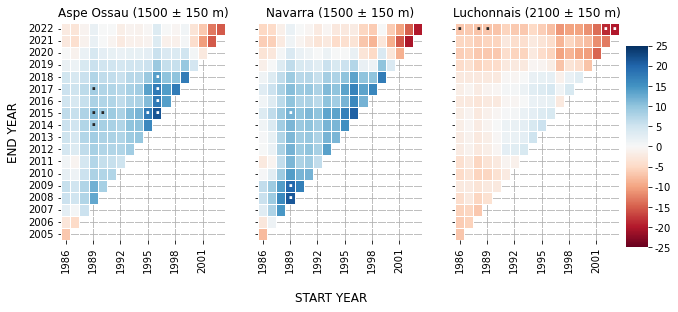

In [27]:
#for comparison with lopez-moreno

#for individual massifs 


plot_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/PLOTS"

df_mk_nan = df_mk.copy()
notna_var = pd.notna
df_mk_nan["slope"] = np.where((df_mk_nan["p"] == False),np.nan,df_mk_nan["slope"])
df_mk_nan["annot"] = np.where((df_mk_nan["p"] == False) ,int(32),int(8901))

bar_min = -25#df_mk["slope"].values.min()
bar_max = 25#df_mk["slope"].values.max()
ticks=[-25,-20,-15,-10,-5,0,5,10,15,20,25]         
min_obs = 26
fig, axs = plt.subplots(1,3,sharey=True)
cbar_ax = fig.add_axes([.91, 0.1, .03, .7])

x =0

for massif,elevation in [('Aspe Ossau',1500),('Navarra',1500), ('Luchonnais',2100)]:

    df_heat = df_mk.query(f"SAFRAN == '{massif}'  & ELEVATION == {elevation} & MIN_NOBS == {min_obs}").pivot(index="END_YEAR", columns="START_YEAR", values="slope")
    df_heat_nan = df_mk_nan.query(f"SAFRAN == '{massif}' & ELEVATION == {elevation} & MIN_NOBS == {min_obs}").pivot(index="END_YEAR", columns="START_YEAR", values="slope")
    df_annot = df_mk_nan.query(f"SAFRAN == '{massif}' & ELEVATION == {elevation} & MIN_NOBS == {min_obs}").pivot(index="END_YEAR", columns="START_YEAR", values="annot")
    df_annot = df_annot.fillna(32).astype('int')

    sn.heatmap(df_heat,ax=axs[x],cmap='RdBu',vmin=bar_min, vmax=bar_max,cbar_ax = cbar_ax,linewidth=.5,center=0)
    sn.heatmap(df_heat_nan,ax=axs[x],cmap='RdBu',vmin=bar_min, vmax=bar_max,cbar_ax = cbar_ax,linewidth=.5,annot=df_annot, fmt="c",center=0,annot_kws={"size": 15,"weight": "bold"},cbar_kws={'ticks': ticks})
    axs[x].collections[0].colorbar.set_ticklabels([t for t in ticks])
    axs[x].grid()
    axs[x].set_title(f"{massif} ({elevation} ± 150 m)")
    axs[x].invert_yaxis() 


    axs[x].set(xlabel=None,ylabel=None)
    axs[x].set_axisbelow(True)
    #fig.colorbar(im, cax=cbar_ax)
    x = x+1

fig.set_figwidth(10)
#fig.set_figheight(10)
plt.subplots_adjust(hspace=0.7)
#plt.subplots_adjust(wspace=0.3)
fig.supxlabel('START YEAR',y=-0.1)
fig.supylabel('END YEAR',x=0.05)


plt.savefig(op.join(plot_path,f'comparison_moreno.pdf'),format="pdf",transparent=False,facecolor='white')


    

      MTN  ELEVATION      SAFRAN  TOPO_VALUE      p     slope  COUNT_YEAR
0     ALP       1500      Aravis         0.0  False -3.100962        37.0
1     ALP       1500      Aravis        90.0  False -5.000000        37.0
2     ALP       1500      Aravis       180.0  False -6.485294        37.0
3     ALP       1500      Aravis       270.0   True -6.220238        37.0
4     ALP       1500      Bauges         0.0  False       NaN         NaN
...   ...        ...         ...         ...    ...       ...         ...
1931  PYR       4500    Sobrarbe       270.0  False       NaN         NaN
1932  PYR       4500  Ter-Freser         0.0  False       NaN         NaN
1933  PYR       4500  Ter-Freser        90.0  False       NaN         NaN
1934  PYR       4500  Ter-Freser       180.0  False       NaN         NaN
1935  PYR       4500  Ter-Freser       270.0  False       NaN         NaN

[1936 rows x 7 columns]


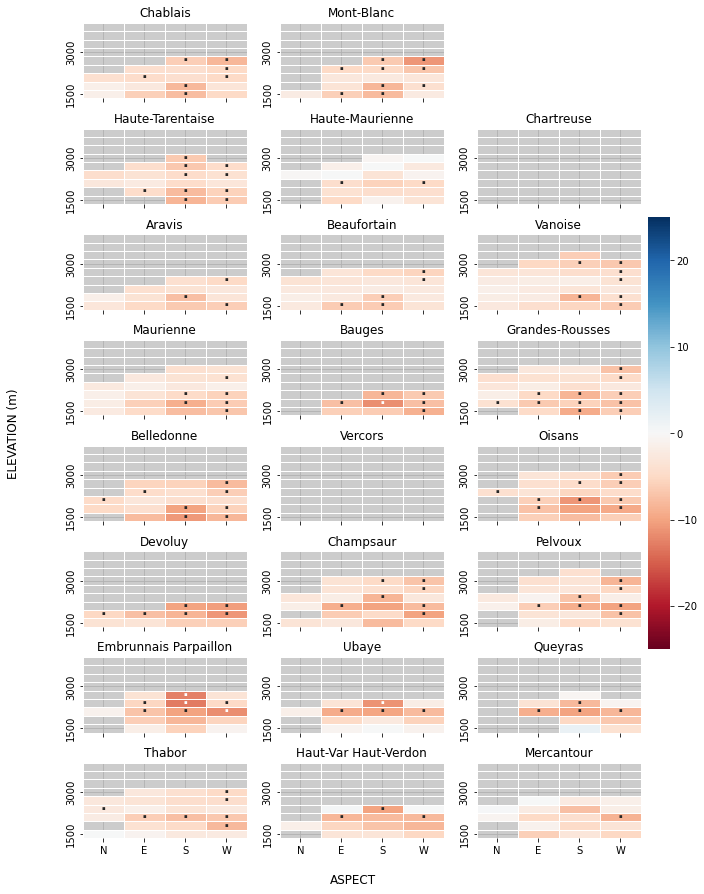

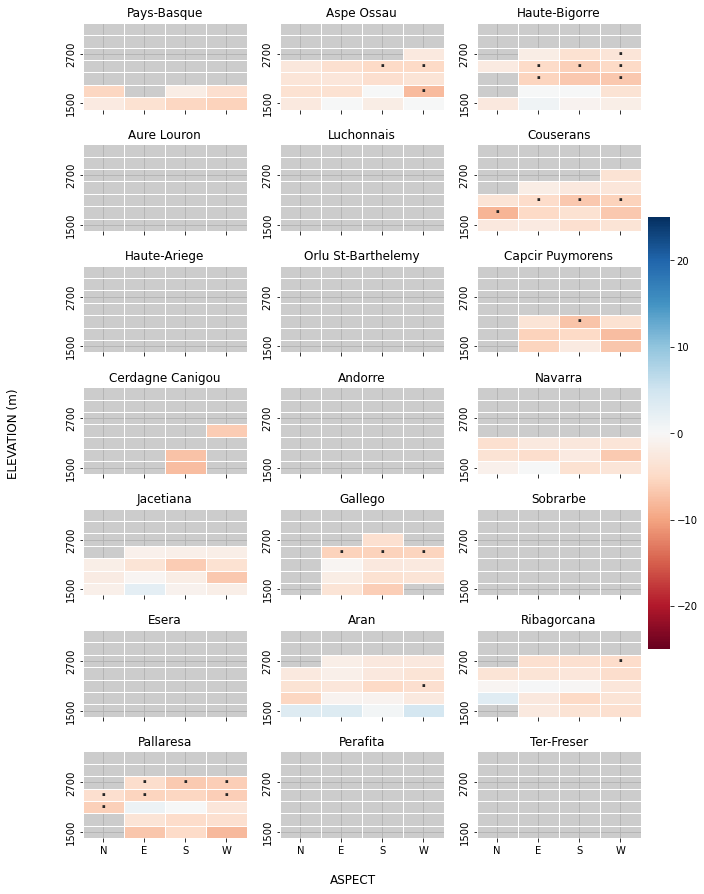

In [11]:
#SAFRAN OPTION A.4: mannkendall test for each aspect

topo="ASPECT"
max_count_year = 30 
min_px_count = 1000
start_year=1986




notna_var = pd.notna
def mannkendall(g,sy,ey):
    if g.query("@notna_var(SMOD_MEDIAN)").HYDRO_YEAR.min() == sy and \
       g.query("@notna_var(SMOD_MEDIAN)").HYDRO_YEAR.max() == ey and \
       g["SMOD_MEDIAN"].count() >= (ey - sy + 1)*95/100:
        mk_test = mk.original_test(g.SMOD_MEDIAN, alpha=0.05)
        out = pd.Series( dict(  p = mk_test.p < 0.05 , slope = mk_test.slope, COUNT_YEAR = g.HYDRO_YEAR.count()) )
    else:
        out = pd.Series( dict(  p = False , slope = np.nan, COUNT_YEAR = np.nan) )
    return out




with open( f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/DATAFRAMES/SWHLX_THEIA_MK.pkl", "rb" )  as dp:
    df = pickle.load(dp) 
    df = df.query("ELEVATION > 1200")
    
    
for min_nobs in range(18,19):

    df_temp =df.query(f"HYDRO_YEAR >= {start_year} & MIN_NOBS == {min_nobs} & TOPO == '{topo}' ")
    df_temp.loc[(df_temp.PIXEL_COUNT < min_px_count)  ,'SMOD_MEDIAN']=np.nan
    #print(df_mask.query("ELEVATION == 2100 & SAFRAN == 'Andorre'"))
    #df_MK = df_mask[["ELEVATION","SAFRAN"]].groupby(["ELEVATION","SAFRAN"])
    df_mk = df_temp.sort_values(by=['HYDRO_YEAR']).groupby(["MTN","ELEVATION","SAFRAN","TOPO_VALUE"]).apply(mannkendall,sy=start_year,ey=2022).reset_index()
    df_mk["slope"] = df_mk["slope"]*10
    print(df_mk)


    plot_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/PLOTS"
    df_mk_nan = df_mk.copy()
    notna_var = pd.notna
    df_mk_nan["slope"] = np.where((df_mk_nan["p"] == False),np.nan,df_mk_nan["slope"])
    df_mk_nan["annot"] = np.where((df_mk_nan["p"] == False) ,int(32),int(8901))
    bar_min = -25#df_mk["slope"].values.min()
    bar_max = 25#df_mk["slope"].values.max()
    mtn = "ALP"
    x= 0
    y=0
    list_massifs = SAFRAN_tiles_2[mtn]
    fig, axs = plt.subplots(8,3, sharex=True,)
    cbar_ax = fig.add_axes([.91, .3, .03, .4])
    skipx=0


    for i,massif in enumerate(list_massifs):
        if i == 2:
            skipx = 1
        x = (i+skipx)%3
        df_heat = df_mk.query(f"SAFRAN == '{massif}' & ELEVATION <= 3900").pivot(index="ELEVATION", columns="TOPO_VALUE", values="slope")
        df_heat_nan = df_mk_nan.query(f"SAFRAN == '{massif}' & ELEVATION <= 3900 ").pivot(index="ELEVATION", columns="TOPO_VALUE", values="slope")
        df_annot = df_mk_nan.query(f"SAFRAN == '{massif}' & ELEVATION <= 3900").pivot(index="ELEVATION", columns="TOPO_VALUE", values="annot")
        df_annot = df_annot.fillna(32).astype('int')
        sn.heatmap(df_heat,ax=axs[y,x],cmap='RdBu',vmin=bar_min, vmax=bar_max,cbar_ax = cbar_ax,linewidth=.5,center=0)
        sn.heatmap(df_heat_nan,ax=axs[y,x],cmap='RdBu',vmin=bar_min, vmax=bar_max,cbar_ax = cbar_ax,linewidth=.5,annot=df_annot, fmt="c",center=0,annot_kws={"size": 15,"weight": "bold"})

        axs[y,x].set_title(massif) 
        axs[y,x].grid()
        axs[y,x].invert_yaxis() 
        axs[y,x].set_facecolor('0.8') 
        axs[y,x].set_axisbelow(True)
        #axs[y,x].set_xticklabels(["N","NE","E","SE","S","SW","W"])
        axs[y,x].set_xticklabels(["N","E","S","W"])
        axs[y,x].set_yticklabels(axs[y,x].get_yticklabels(),rotation=90) 
        axs[y,x].set_xticklabels(axs[y,x].get_xticklabels(),rotation=0) 
        axs[y,x].set(xlabel=None,ylabel=None)
        #axs[y,x].set_xlabel("ORIENTATION",size= 14)
        #axs[y,x].set_ylabel("ELEVATION (m)",size= 14)
        #axs[y,x].set_yticklabels(axs[y,x].get_yticklabels(),size= 14)

        if x == 2 or i == 1:
            y = y + 1 


    #fig.delaxes(axs[0][0])
    fig.delaxes(axs[0][2])
    plt.subplots_adjust(hspace=0.4)
    fig.set_figwidth(10)
    fig.set_figheight(15)
    fig.supxlabel('ASPECT',y=0.08)
    fig.supylabel('ELEVATION (m)')
    plt.savefig(op.join(plot_path,f'{mtn}_MINNOBS_{min_nobs}_4_ASPECT.pdf'),format="pdf",transparent=False,facecolor='white')  

    mtn = "PYR"
    x= 0
    y=0
    list_massifs = SAFRAN_tiles_2[mtn]
    fig, axs = plt.subplots(7,3, sharex=True,)
    cbar_ax = fig.add_axes([.91, .3, .03, .4])

    for i,massif in enumerate(list_massifs):

        x = i%3
        df_heat = df_mk.query(f"SAFRAN == '{massif}' & ELEVATION <= 3300 ").pivot(index="ELEVATION", columns="TOPO_VALUE", values="slope")
        df_heat_nan = df_mk_nan.query(f"SAFRAN == '{massif}'& ELEVATION <= 3300  ").pivot(index="ELEVATION", columns="TOPO_VALUE", values="slope")
        df_annot = df_mk_nan.query(f"SAFRAN == '{massif}'& ELEVATION <= 3300 ").pivot(index="ELEVATION", columns="TOPO_VALUE", values="annot")
        df_annot = df_annot.fillna(32).astype('int')
        sn.heatmap(df_heat,ax=axs[y,x],cmap='RdBu',vmin=bar_min, vmax=bar_max,cbar_ax = cbar_ax,linewidth=.5,center=0)
        sn.heatmap(df_heat_nan,ax=axs[y,x],cmap='RdBu',vmin=bar_min, vmax=bar_max,cbar_ax = cbar_ax,linewidth=.5,annot=df_annot, fmt="c",center=0,annot_kws={"size": 15,"weight": "bold"})

        axs[y,x].set_title(massif) 
        axs[y,x].grid()
        axs[y,x].invert_yaxis() 
        axs[y,x].set_facecolor('0.8') 
        axs[y,x].set_axisbelow(True)
        #axs[y,x].set_xticklabels(["N","NE","E","SE","S","SW","W"])
        axs[y,x].set_xticklabels(["N","E","S","W"])
        axs[y,x].set_yticklabels(axs[y,x].get_yticklabels(),rotation=90) 
        axs[y,x].set_xticklabels(axs[y,x].get_xticklabels(),rotation=0) 
        axs[y,x].set(xlabel=None,ylabel=None)
        #axs[y,x].set_xlabel("ORIENTATION",size= 14)
        #axs[y,x].set_ylabel("ELEVATION (m)",size= 14)
        #axs[y,x].set_yticklabels(axs[y,x].get_yticklabels(),size= 14)

        if x == 2 :
            y = y + 1 


    #fig.delaxes(axs[0][0])

    plt.subplots_adjust(hspace=0.4)
    fig.set_figwidth(10)
    fig.set_figheight(15)
    fig.supxlabel('ASPECT',y=0.08)
    fig.supylabel('ELEVATION (m)')
    plt.savefig(op.join(plot_path,f'{mtn}_MINNOBS_{min_nobs}_4_ASPECT.pdf'),format="pdf",transparent=False,facecolor='white')   


      ELEVATION     SAFRAN  MTN  SMOD_MEDIAN  PIXEL_COUNT  PIXEL_RATIO  \
0          2100  Champsaur  ALP        269.0        17300         26.0   
1          2100  Champsaur  ALP        268.0        58727         90.0   
2          2100  Champsaur  ALP        274.0        63844         98.0   
3          2100  Champsaur  ALP        256.0        60859         93.0   
4          2100  Champsaur  ALP        268.0        54039         83.0   
...         ...        ...  ...          ...          ...          ...   
1490       2100  Couserans  PYR        249.0        54017         98.0   
1491       2100  Couserans  PYR        212.0        54722         99.0   
1492       2100  Couserans  PYR        231.0        54742         99.0   
1493       2100  Couserans  PYR        255.0        54744        100.0   
1494       2100  Couserans  PYR        252.0        54544         99.0   

      PIXEL_RATIO_SNOW  MIN_NOBS TOPO  TOPO_VALUE  HYDRO_YEAR DATASET  
0                 26.0        20  DAH  

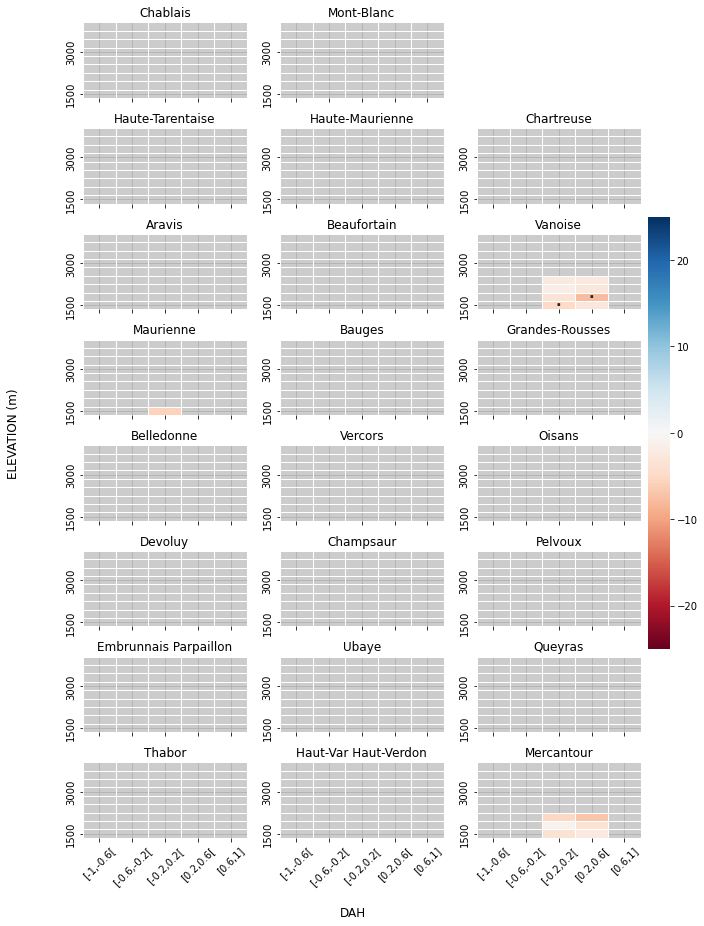

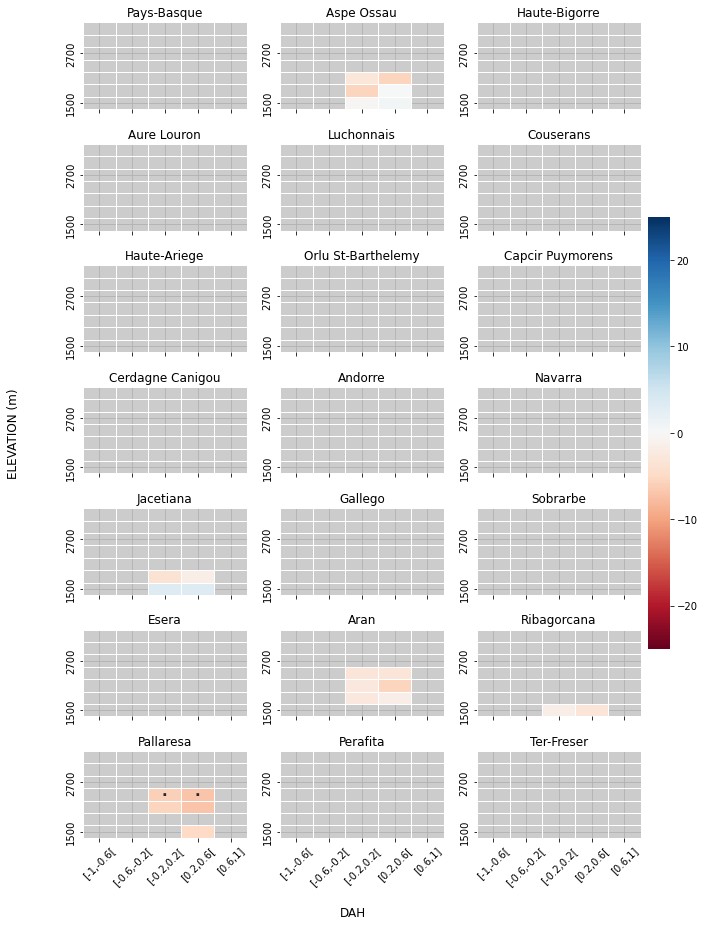

In [14]:
#SAFRAN OPTION A.4: mannkendall test for each dah

topo="DAH"
max_count_year = 30 
min_px_count = 1000
min_nobs = 4
start_year=1986




notna_var = pd.notna
def mannkendall(g,sy,ey):
    if g.query("@notna_var(SMOD_MEDIAN)").HYDRO_YEAR.min() == sy and \
       g.query("@notna_var(SMOD_MEDIAN)").HYDRO_YEAR.max() == ey and \
       g["SMOD_MEDIAN"].count() >= (ey - sy + 1)*95/100:
        mk_test = mk.original_test(g.SMOD_MEDIAN, alpha=0.05)
        out = pd.Series( dict(  p = mk_test.p < 0.05 , slope = mk_test.slope, COUNT_YEAR = g.HYDRO_YEAR.count()) )
    else:
        out = pd.Series( dict(  p = False , slope = np.nan, COUNT_YEAR = np.nan) )
    return out




with open( f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/DATAFRAMES/SWHLX_THEIA_MK.pkl", "rb" )  as dp:
    df = pickle.load(dp) 
    df = df.query("ELEVATION > 1200")
print(df.query("TOPO == 'DAH' & PIXEL_COUNT >= 1000 & MIN_NOBS == 20 & ELEVATION == 2100 & TOPO_VALUE == 0").reset_index(drop=True))
    
for min_nobs in range(26,27):

    df_temp =df.query(f"HYDRO_YEAR >= {start_year} & MIN_NOBS == {min_nobs} & TOPO == '{topo}' ")
    df_temp.loc[(df_temp.PIXEL_COUNT < min_px_count)  ,'SMOD_MEDIAN']=np.nan
    #print(df_mask.query("ELEVATION == 2100 & SAFRAN == 'Andorre'"))
    #df_MK = df_mask[["ELEVATION","SAFRAN"]].groupby(["ELEVATION","SAFRAN"])
    df_mk = df_temp.sort_values(by=['HYDRO_YEAR']).groupby(["MTN","ELEVATION","SAFRAN","TOPO_VALUE"]).apply(mannkendall,sy=start_year,ey=2022).reset_index()
    df_mk["slope"] = df_mk["slope"]*10
    print(df_mk)


    plot_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/PLOTS"
    df_mk_nan = df_mk.copy()
    notna_var = pd.notna
    df_mk_nan["slope"] = np.where((df_mk_nan["p"] == False),np.nan,df_mk_nan["slope"])
    df_mk_nan["annot"] = np.where((df_mk_nan["p"] == False) ,int(32),int(8901))
    bar_min = -25#df_mk["slope"].values.min()
    bar_max = 25#df_mk["slope"].values.max()
    mtn = "ALP"
    x= 0
    y=0
    list_massifs = SAFRAN_tiles_2[mtn]
    fig, axs = plt.subplots(8,3, sharex=True,)
    cbar_ax = fig.add_axes([.91, .3, .03, .4])
    skipx=0


    for i,massif in enumerate(list_massifs):
        if i == 2:
            skipx = 1
        x = (i+skipx)%3
        df_heat = df_mk.query(f"SAFRAN == '{massif}' & ELEVATION <= 3900").pivot(index="ELEVATION", columns="TOPO_VALUE", values="slope")
        df_heat_nan = df_mk_nan.query(f"SAFRAN == '{massif}' & ELEVATION <= 3900 ").pivot(index="ELEVATION", columns="TOPO_VALUE", values="slope")
        df_annot = df_mk_nan.query(f"SAFRAN == '{massif}' & ELEVATION <= 3900").pivot(index="ELEVATION", columns="TOPO_VALUE", values="annot")
        df_annot = df_annot.fillna(32).astype('int')
        sn.heatmap(df_heat,ax=axs[y,x],cmap='RdBu',vmin=bar_min, vmax=bar_max,cbar_ax = cbar_ax,linewidth=.5,center=0)
        sn.heatmap(df_heat_nan,ax=axs[y,x],cmap='RdBu',vmin=bar_min, vmax=bar_max,cbar_ax = cbar_ax,linewidth=.5,annot=df_annot, fmt="c",center=0,annot_kws={"size": 15,"weight": "bold"})

        axs[y,x].set_title(massif) 
        axs[y,x].grid()
        axs[y,x].invert_yaxis() 
        axs[y,x].set_facecolor('0.8') 
        axs[y,x].set_axisbelow(True)
        axs[y,x].set_xticklabels(["[-1,-0.6[","[-0.6,-0.2[","[-0.2,0.2[","[0.2,0.6[","[0.6,1]"])
        axs[y,x].set_yticklabels(axs[y,x].get_yticklabels(),rotation=90) 
        axs[y,x].set_xticklabels(axs[y,x].get_xticklabels(),rotation=45) 
        axs[y,x].set(xlabel=None,ylabel=None)
        #axs[y,x].set_xlabel("ORIENTATION",size= 14)
        #axs[y,x].set_ylabel("ELEVATION (m)",size= 14)
        #axs[y,x].set_yticklabels(axs[y,x].get_yticklabels(),size= 14)

        if x == 2 or i == 1:
            y = y + 1 


    #fig.delaxes(axs[0][0])
    fig.delaxes(axs[0][2])
    plt.subplots_adjust(hspace=0.4)
    fig.set_figwidth(10)
    fig.set_figheight(15)
    fig.supxlabel('DAH',y=0.05)
    fig.supylabel('ELEVATION (m)')
    plt.savefig(op.join(plot_path,f'{mtn}_MINNOBS_{min_nobs}_5_DAH.png'),format="png",transparent=False,facecolor='white')  

    mtn = "PYR"
    x= 0
    y=0
    list_massifs = SAFRAN_tiles_2[mtn]
    fig, axs = plt.subplots(7,3, sharex=True,)
    cbar_ax = fig.add_axes([.91, .3, .03, .4])

    for i,massif in enumerate(list_massifs):

        x = i%3
        df_heat = df_mk.query(f"SAFRAN == '{massif}' & ELEVATION <= 3300 ").pivot(index="ELEVATION", columns="TOPO_VALUE", values="slope")
        df_heat_nan = df_mk_nan.query(f"SAFRAN == '{massif}'& ELEVATION <= 3300  ").pivot(index="ELEVATION", columns="TOPO_VALUE", values="slope")
        df_annot = df_mk_nan.query(f"SAFRAN == '{massif}'& ELEVATION <= 3300 ").pivot(index="ELEVATION", columns="TOPO_VALUE", values="annot")
        df_annot = df_annot.fillna(32).astype('int')
        sn.heatmap(df_heat,ax=axs[y,x],cmap='RdBu',vmin=bar_min, vmax=bar_max,cbar_ax = cbar_ax,linewidth=.5,center=0)
        sn.heatmap(df_heat_nan,ax=axs[y,x],cmap='RdBu',vmin=bar_min, vmax=bar_max,cbar_ax = cbar_ax,linewidth=.5,annot=df_annot, fmt="c",center=0,annot_kws={"size": 15,"weight": "bold"})

        axs[y,x].set_title(massif) 
        axs[y,x].grid()
        axs[y,x].invert_yaxis() 
        axs[y,x].set_facecolor('0.8') 
        axs[y,x].set_axisbelow(True)
        axs[y,x].set_xticklabels(["[-1,-0.6[","[-0.6,-0.2[","[-0.2,0.2[","[0.2,0.6[","[0.6,1]"])
        axs[y,x].set_yticklabels(axs[y,x].get_yticklabels(),rotation=90) 
        axs[y,x].set_xticklabels(axs[y,x].get_xticklabels(),rotation=45) 
        axs[y,x].set(xlabel=None,ylabel=None)
        #axs[y,x].set_xlabel("ORIENTATION",size= 14)
        #axs[y,x].set_ylabel("ELEVATION (m)",size= 14)
        #axs[y,x].set_yticklabels(axs[y,x].get_yticklabels(),size= 14)

        if x == 2 :
            y = y + 1 


    #fig.delaxes(axs[0][0])

    plt.subplots_adjust(hspace=0.4)
    fig.set_figwidth(10)
    fig.set_figheight(15)
    fig.supxlabel('DAH',y=0.05)
    fig.supylabel('ELEVATION (m)')
    plt.savefig(op.join(plot_path,f'{mtn}_MINNOBS_{min_nobs}_5_DAH.png'),format="png",transparent=False,facecolor='white')   


In [6]:
with open( f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/DATAFRAMES/SWHLX_THEIA_ALL_MK.pkl", "rb" )  as dp:
    df = pickle.load(dp) 
df.query(f"MIN_NOBS == 10  & ELEVATION > 1200 & TOPO == 'NONE'").groupby(["MTN","ELEVATION","SAFRAN"])

,ELEVATION,SAFRAN,MTN,SMOD_MEDIAN,SOD_MEDIAN,SCD_MEDIAN,PIXEL_COUNT,MIN_NOBS,TOPO,TOPO_VALUE,HYDRO_YEAR,DATASET
0,1500,Pelvoux,ALP,181.0,106.0,76.0,43503,2,NONE,NaN,1986,TB
1,1500,Pelvoux,ALP,225.0,90.0,144.0,1410,2,ASPECT,0.0,1986,TB
2,1500,Pelvoux,ALP,189.0,106.0,92.0,9371,2,ASPECT,90.0,1986,TB
3,1500,Pelvoux,ALP,181.0,106.0,74.0,28228,2,ASPECT,180.0,1986,TB
4,1500,Pelvoux,ALP,189.0,108.0,90.0,4494,2,ASPECT,270.0,1986,TB
...,...,...,...,...,...,...,...,...,...,...,...,...
2328035,4500,Haute-Ariege,PYR,NaN,NaN,NaN,0,26,DAH,-0.8,2022,THEIA
2328036,4500,Haute-Ariege,PYR,NaN,NaN,NaN,0,26,DAH,-0.4,2022,THEIA
2328037,4500,Haute-Ariege,PYR,NaN,NaN,NaN,0,26,DAH,0.0,2022,THEIA
2328038,4500,Haute-Ariege,PYR,NaN,NaN,NaN,0,26,DAH,0.4,2022,THEIA


In [7]:
#SAFRAN OPTION A.4: write new shapefile
metric='SMOD'


notna_var = pd.notna
def mannkendall(g,sy,ey):
    if g.query(f"@notna_var({metric}_MEDIAN)").HYDRO_YEAR.min() == 1986 and \
       g.query(f"@notna_var({metric}_MEDIAN)").HYDRO_YEAR.max() == 2022 and \
       g[f"{metric}_MEDIAN"].count() >= (ey - sy + 1)*95/100:
        mk_test = mk.original_test(g[f"{metric}_MEDIAN"], alpha=0.05)
        out = pd.Series( dict(  trend = mk_test.trend, p = mk_test.p < 0.05 , slope = mk_test.slope, COUNT_YEAR = g.HYDRO_YEAR.count()) )
    else:
        out = pd.Series( dict(  trend = 'nan', p = False , slope = np.nan, COUNT_YEAR = np.nan) )
    return out




with open( f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/DATAFRAMES/SWHLX_THEIA_ALL_MK.pkl", "rb" )  as dp:
    df = pickle.load(dp) 
print(df)

df.loc[(df.PIXEL_COUNT < 1000)  ,f'{metric}_MEDIAN']=np.nan

df_MK2 = df.sort_values(by=["HYDRO_YEAR"]).query(f"MIN_NOBS == 12  & ELEVATION > 1200 & TOPO == 'NONE'").groupby(["MTN","ELEVATION","SAFRAN"]).apply(mannkendall,sy=1986,ey=2022).reset_index()
df_MK2['slope'] = df_MK2['slope']*10
print(df_MK2)


SAFRAN_PATH = f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SAFRAN/massifs_WGS84.shp"
drv = ogr.GetDriverByName( 'ESRI Shapefile' )
shapefile = gpd.read_file(SAFRAN_PATH)


print(df_MK2.query(" SAFRAN == 'Bauges'"))

list_ele = df_MK2.ELEVATION.unique()
list_massifs = df_MK2.SAFRAN.unique()
out_path = f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/SHP/{metric}_SWHLX_THEIA_MK_NOBS12_HYDRO_RGI.shp"
for ele in list_ele:
    print(ele)
    att_name = metric+"_"+str(ele)
    p_name = "p_"+str(ele)
    #print(att_name)

    df2= df_MK2.query(f"ELEVATION == {ele}")
    #print(df2)
    list_val = []
    list_p = []
    for ind in shapefile.index:
        massif = shapefile['title'][ind]
        val = np.nan
        trend_val = np.nan
        if massif in df2['SAFRAN'].unique():
            trend_val = df2.loc[df2['SAFRAN'] == massif, 'trend'].values[0]
            if trend_val == "no trend":
                val = df2.loc[df2['SAFRAN'] == massif, 'slope'].values[0]
            if trend_val == "nan":
                val = np.nan
            if trend_val == "decreasing" or trend_val == "increasing":
                val = df2.loc[df2['SAFRAN'] == massif, 'slope'].values[0]
        list_val.append(val)
        list_p.append(trend_val)
    shapefile[att_name] = list_val
    shapefile[p_name] = list_p
#print(shapefile)
#print(df)
shapefile.to_file(out_path)
    



         ELEVATION        SAFRAN  MTN  SMOD_MEDIAN  SOD_MEDIAN  SCD_MEDIAN  \
0             1500       Pelvoux  ALP        181.0       106.0        76.0   
1             1500       Pelvoux  ALP        225.0        90.0       144.0   
2             1500       Pelvoux  ALP        189.0       106.0        92.0   
3             1500       Pelvoux  ALP        181.0       106.0        74.0   
4             1500       Pelvoux  ALP        189.0       108.0        90.0   
...            ...           ...  ...          ...         ...         ...   
2328035       4500  Haute-Ariege  PYR          NaN         NaN         NaN   
2328036       4500  Haute-Ariege  PYR          NaN         NaN         NaN   
2328037       4500  Haute-Ariege  PYR          NaN         NaN         NaN   
2328038       4500  Haute-Ariege  PYR          NaN         NaN         NaN   
2328039       4500  Haute-Ariege  PYR          NaN         NaN         NaN   

         PIXEL_COUNT  MIN_NOBS    TOPO  TOPO_VALUE  HYDRO_YEAR 

In [7]:
#SAFRAN OPTION B.1: make trend dataframes of mannkendall tests and Sen slopes for each pixel


account = "cesbio"
log_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/LOGS"
job_sh_path = "/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/synthesis_code/safran_pixel_MK.sh"
job_common_params =  " ".join(
    [
        "-A",account,
        " --job-name={}",
        " --time=01:59:59",
        "-N","1","-n","8",
        "--mem-per-cpu=8000M",
        "-o",log_path+"/{}",
        "--export=ALL,{}",job_sh_path
    ]
)

DTM_step = 300
DTM_min = 1500
DTM_max= 4500


for mtn in SAFRAN_tiles_2:
    for i,massif in enumerate(SAFRAN_tiles_2[mtn]):
        for ele in range(DTM_min,DTM_max+1,DTM_step):
            jobname=f"{mtn}_{i}_{ele}_MK"
            export =  ",".join([ f"MTN=\"{mtn}\",MASSIF=\"{massif}\",N=\"{i}\",ELE=\"{ele}\""])
            os.system("sbatch "+job_common_params.format(jobname,jobname+".log",export))  
            
            
            
            





Submitted batch job 24558727
Submitted batch job 24558729
Submitted batch job 24558730
Submitted batch job 24558731
Submitted batch job 24558732
Submitted batch job 24558733
Submitted batch job 24558734
Submitted batch job 24558735
Submitted batch job 24558736
Submitted batch job 24558737
Submitted batch job 24558738
Submitted batch job 24558739
Submitted batch job 24558740
Submitted batch job 24558741
Submitted batch job 24558742
Submitted batch job 24558743
Submitted batch job 24558744
Submitted batch job 24558745
Submitted batch job 24558746
Submitted batch job 24558747
Submitted batch job 24558748
Submitted batch job 24558749
Submitted batch job 24558750
Submitted batch job 24558751
Submitted batch job 24558752
Submitted batch job 24558753
Submitted batch job 24558754
Submitted batch job 24558755
Submitted batch job 24558756
Submitted batch job 24558757
Submitted batch job 24558758
Submitted batch job 24558759
Submitted batch job 24558760
Submitted batch job 24558761
Submitted batc

In [8]:
#SAFRAN OPTION B.2: concatenate all dataframes
list_df = glob.glob(f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/DATAFRAMES/safran_pixel_*.pkl")
len_list = len(list_df)
with open( list_df[0], "rb" )  as dp:
    print(f"1/{len_list}",end= "               \r")
    df = pickle.load(dp)
df = df[["ELEVATION","MTN","SLOPE","TREND","MIN_NOBS"]].query("MIN_NOBS == 10")
for i,l in enumerate(list_df[1:],2):
    print(f"{i}/{len_list}",end= "               \r")
    with open( l, "rb" )  as dp:
        df2 = pickle.load(dp) 
    df = pd.concat([df,df2[["ELEVATION","MTN","SLOPE","TREND","MIN_NOBS"]].query("MIN_NOBS == 10")],ignore_index=True)
    #print(len(df))
df.to_pickle(f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/DATAFRAMES/PIXEL_MK_MULTI_NOBS.pkl")  
print(df)

          ELEVATION  MTN  SLOPE TREND  MIN_NOBS
0            3600.0  ALP    NaN   nan      10.0
1            3600.0  ALP    NaN   nan      10.0
2            3600.0  ALP    NaN   nan      10.0
3            3600.0  ALP    NaN   nan      10.0
4            3600.0  ALP    NaN   nan      10.0
...             ...  ...    ...   ...       ...
26260882     3000.0  PYR    NaN   nan      10.0
26260883     3000.0  PYR    NaN   nan      10.0
26260884     3000.0  PYR    NaN   nan      10.0
26260885     3000.0  PYR    NaN   nan      10.0
26260886     3000.0  PYR    NaN   nan      10.0

[26260887 rows x 5 columns]


In [14]:
with open( f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/DATAFRAMES/PIXEL_MK_MULTI_NOBS.pkl", "rb" )  as dp:
    df = pickle.load(dp) 
df = df[["ELEVATION","SLOPE","TREND","MTN"]]
df = df.query("SLOPE.notnull()",engine='python')
df["SLOPE"] = df["SLOPE"]*37


In [15]:
df.groupby(["MTN"])["SLOPE"].mean()

MTN
ALP   -20.400669
PYR   -14.938308
Name: SLOPE, dtype: float64

In [16]:
df.groupby(["MTN"])["SLOPE"].std()

MTN
ALP    17.956071
PYR    16.476244
Name: SLOPE, dtype: float64

prepare dataframes


/tmp/slurm-17978411/ipykernel_279189/3649612624.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp2["Significance"] ="p < 0.05"


start plots
boxplot
histplot
[[1107670 2883926 4040682 3627324 1063985   80208]
 [  51854  391805  702626  686210  237988   17512]] [[-0.5  0.5  1.5  2.5  3.5  4.5]
 [-0.5  0.5  1.5  2.5  3.5  4.5]]
[ 4.68135817 13.58582016 17.38879724 18.91780277 22.36760857 21.83323359]


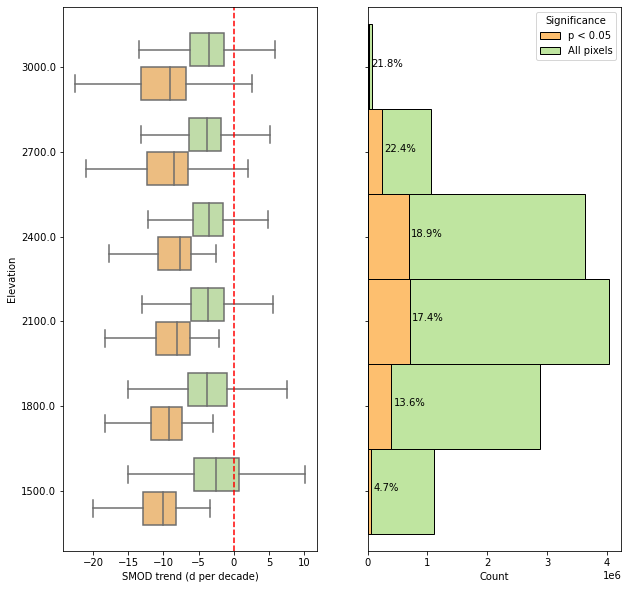

In [13]:
#SAFRAN OPTION B.4: make boxplot per elevation range
def draw_text(plot,ax):
    w = []
    y = []
    for i,patch in enumerate(plot.patches):
        w.append(plot.patches[i].get_width())
        y.append(plot.patches[i].get_y())
    w = np.array(w).reshape(2, int(len(w)/2))
    y = np.array(y).reshape(2, int(len(y)/2))
    print(w,y)
    p = w[1]/w[0]*100
    print(p)
    for i in range(len(p)):
        plot.annotate("{:.1f}%".format(p[i]), xy=(w[1][i] + 40000 ,y[0][i] + 0.5))
        
mtn = 'PYR'
print("prepare dataframes")

df_temp = df.sort_values(by=['ELEVATION']).query(f"ELEVATION <= 3000 & MTN == '{mtn}'")
df_temp = df_temp.rename(columns={"SIGNIFICANCE": "Significance"})
df_temp2 = df_temp.query("TREND != 'no trend'")
df_temp["Significance"] ="All pixels"
df_temp2["Significance"] ="p < 0.05"

df_temp = pd.concat([df_temp,df_temp2],ignore_index=True)

df_temp['ELEVATION'] = df_temp['ELEVATION'].astype(str)
plot_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/PLOTS"

hur_order=["p < 0.05","All pixels"]

print("start plots")
fig, axs = plt.subplots(1,2,sharey=True)
print("boxplot")
bp = sn.boxplot(ax=axs[0],data=df_temp,y="ELEVATION",x="SLOPE",hue="Significance",hue_order=hur_order, showfliers=False,palette='Spectral')
axs[0].invert_yaxis() 
axs[0].axvline(0, ls='--', color='red')
axs[0].legend_.remove()
axs[0].set_xlabel("SMOD trend (d per decade)")
axs[0].set_ylabel("Elevation")
#axs[0].set_xticklabels([-25,-20, -15, -10, -5,0,5,10])
print("histplot")
hs = sn.histplot(ax=axs[1],data=df_temp,y='ELEVATION',hue='Significance',hue_order=hur_order,alpha=1,palette='Spectral')
axs[1].invert_yaxis()
axs[1].set_xlabel("Count")

draw_text(hs,axs[1])
fig.set_figwidth(10)
fig.set_figheight(10)
plt.savefig(os.path.join(plot_path,f"{mtn}_pixel_trends.pdf"),format='pdf',transparent=False)


prepare dataframes


/tmp/slurm-17978411/ipykernel_279189/3535024793.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp2["Significance"] ="p < 0.05"


start plots
boxplot
histplot
[[1877098 3407308 5062620 5545353 2987744  774204  120551   13041]
 [ 397546 1076082 1533491 1375156  762442  241279   49996    6209]] [[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5]
 [-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5]]
[21.17875572 31.58158875 30.29046225 24.79834918 25.5189869  31.16478344
 41.47290358 47.6113795 ]


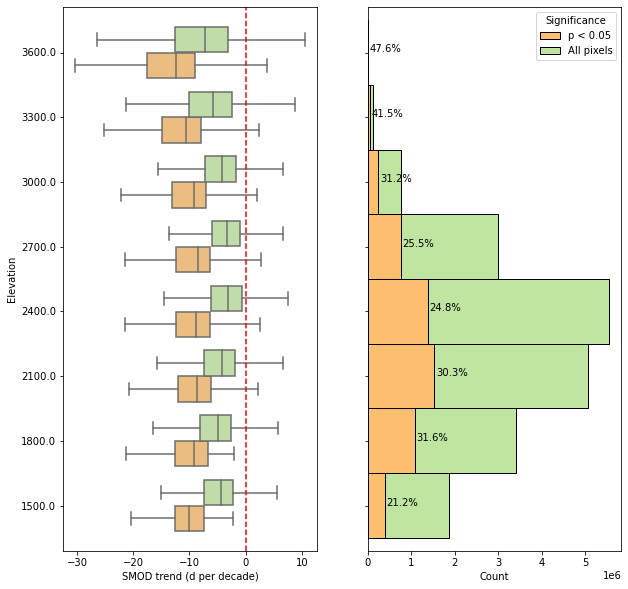

In [14]:
#SAFRAN OPTION B.4: make boxplot per elevation range
def draw_text(plot,ax):
    w = []
    y = []
    for i,patch in enumerate(plot.patches):
        w.append(plot.patches[i].get_width())
        y.append(plot.patches[i].get_y())
    w = np.array(w).reshape(2, int(len(w)/2))
    y = np.array(y).reshape(2, int(len(y)/2))
    print(w,y)
    p = w[1]/w[0]*100
    print(p)
    for i in range(len(p)):
        plot.annotate("{:.1f}%".format(p[i]), xy=(w[1][i] + 40000 ,y[0][i] + 0.5))
        
mtn = 'ALP'
print("prepare dataframes")

df_temp = df.sort_values(by=['ELEVATION']).query(f"ELEVATION <= 3600  & MTN == '{mtn}'")
df_temp = df_temp.rename(columns={"SIGNIFICANCE": "Significance"})
df_temp2 = df_temp.query("TREND != 'no trend'")
df_temp["Significance"] ="All pixels"
df_temp2["Significance"] ="p < 0.05"

df_temp = pd.concat([df_temp,df_temp2],ignore_index=True)

df_temp['ELEVATION'] = df_temp['ELEVATION'].astype(str)
plot_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/PLOTS"

hur_order=["p < 0.05","All pixels"]

print("start plots")
fig, axs = plt.subplots(1,2,sharey=True)
print("boxplot")
bp = sn.boxplot(ax=axs[0],data=df_temp,y="ELEVATION",x="SLOPE",hue="Significance",hue_order=hur_order, showfliers=False,palette='Spectral')
axs[0].invert_yaxis() 
axs[0].axvline(0, ls='--', color='red')
axs[0].legend_.remove()
axs[0].set_xlabel("SMOD trend (d per decade)")
axs[0].set_ylabel("Elevation")
#axs[0].set_xticklabels([-25,-20, -15, -10, -5,0])
print("histplot")
hs = sn.histplot(ax=axs[1],data=df_temp,y='ELEVATION',hue='Significance',hue_order=hur_order,alpha=1,palette='Spectral')
axs[1].invert_yaxis()
axs[1].set_xlabel("Count")

draw_text(hs,axs[1])
fig.set_figwidth(10)
fig.set_figheight(10)
plt.savefig(os.path.join(plot_path,f"{mtn}_pixel_trends.pdf"),format='pdf',transparent=False)


In [ ]:
df_C_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/DATAFRAMES/df_OPTC.pkl"
df_C_MK_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/DATAFRAMES/df_OPTC_ASPECT_MK.pkl"
with open( df_C_path, "rb" )  as dp:
    df = pickle.load(dp)  
d = dict()
d["MTN"] = []
d["TREND"] = []
d["SAFRAN"] = []
d["TAU"] = []
d["P-VALUE"] = []
d["SEN_SLOPE"]= []
d["ELEVATION"] = []
d["ASPECT"]=[]
d["NB"] = []
for mtn in ["ALP","PYR"]:
    df_mtn = df.query(f"MTN == '{mtn}'")
    for massif in SAFRAN_tiles_2[mtn]:
        for ele in range(900,4200,300):
            for aspect in range(1,9):
                list_smod_period = []
                #print(massif,ele,len(list_smod_period))
                list_ID = df_mtn.query(f"SAFRAN == '{massif}' & ELEVATION == {ele} & ASPECT == {aspect}")["ID"].unique()
                n_ID = len(list_ID)
                ID_sample = random.sample(list(list_ID), min(n_ID,500))
                for ID in ID_sample:
                    smod_period = df_mtn.query(f"ID == {ID}").sort_values(by=['HYDRO_YEAR'])['SMOD'].values
                    #print(smod_period)
                    if 0 not in smod_period and len(smod_period) == 29:
                        list_smod_period.append(smod_period)


                if len(list_smod_period) > 2 :
                    print(massif,ele,aspect,len(list_smod_period))
                    stack_smod_array = np.hstack(list_smod_period) 
                    #print(stack_smod_array)
                    mk_test = mk.regional_test(stack_smod_array, alpha=0.05)

                    print(mk_test)
                    d["MTN"].append(mtn)
                    d["TREND"].append(mk_test.trend)
                    d["SAFRAN"].append(massif)
                    d["TAU"].append(mk_test.Tau)
                    d["P-VALUE"].append(mk_test.p)
                    d["SEN_SLOPE"].append(mk_test.slope)
                    d["ELEVATION"].append(ele)
                    d["ASPECT"].append(aspect)
                    d["NB"].append(len(list_smod_period))
    
    
df = pd.DataFrame(data=d)   
df.to_pickle(df_C_MK_path)


In [ ]:
df_C_MK_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/DATAFRAMES/df_OPTC_ASPECT_MK.pkl"
with open( df_C_MK_path, "rb" )  as dp:
    df = pickle.load(dp)  
df.query("SAFRAN == 'Belledonne'").sort_values(by=['SAFRAN','ELEVATION','ASPECT'])

In [ ]:
#MAKE MANNKENDALL RASTERS PER MASSIF
driver = gdal.GetDriverByName('GTiff')
model="TCD-BLUE_AVG-1200"
syntheses= f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/LANDSAT"



account = "cesbio"
log_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/LOGS"
job_sh_path = "/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/synthesis_code/raster_MK.sh"
job_common_params =  " ".join(
    [
        "-A",account,
        " --job-name={}",
        " --time=09:59:59",
        "-N","1","-n","8",
        "--mem-per-cpu=32000M",
        "-o",log_path+"/{}",
        "--export=ALL,{}",job_sh_path
    ]
)


for mtn in SAFRAN_tiles_2:
    for i,massif in enumerate(SAFRAN_tiles_2[mtn]):
        jobname=f"{mtn}_{i}_rasters_MK"
        export =  ",".join([ f"MTN=\"{mtn}\",MASSIF=\"{massif}\",N=\"{i}\""])
        os.system("sbatch "+job_common_params.format(jobname,jobname+".log",export))              
            
            

In [120]:


coords={"Mont-Louis":[reproject('4326','32631',to_deg(2,7,30,'E'),to_deg(42,30,60,'N'))[0]
                      ,reproject('4326','32631',to_deg(2,7,30,'E'),to_deg(42,30,60,'N'))[1]],
        "Angoustrine":[reproject('4326','32631',to_deg(1,57,20,'E'),to_deg(42,29,20,'N'))[0],
                      reproject('4326','32631',to_deg(1,57,20,'E'),to_deg(42,29,20,'N'))[1]],
        "La Llagone":[reproject('4326','32631',to_deg(2,7,20,'E'),to_deg(42,31,60,'N'))[0],
                      reproject('4326','32631',to_deg(2,7,20,'E'),to_deg(42,31,60,'N'))[1]],
        "Railleu":[reproject('4326','32631',to_deg(2,10,86,'E'),to_deg(42,35,20,'N'))[0],
                   reproject('4326','32631',to_deg(2,10,86,'E'),to_deg(42,35,20,'N'))[1]]}
print(coords)





{'Mont-Louis': [428123.4837912724, 4707514.646233805], 'Angoustrine': [414166.4217427008, 4704587.772429402], 'La Llagone': [427914.4680781789, 4709367.6752021015], 'Railleu': [433585.1751274823, 4715480.743095107]}


In [132]:


import re

def to_deg(deg, minutes, seconds, direction):
    return (float(deg) + float(minutes)/60 + float(seconds)/(60*60)) * (-1 if direction in ['W', 'S'] else 1)

path_insitu_smod = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/INSITU/STATIONS"
path_synthesis = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS"
TCD_PATH = "/home/ad/barrouz/datalake/static_aux/TreeCoverDensity"
GLACIER_PATH= "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/GLACIERS"
SAFRAN_PATH = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SAFRAN/massifs_WGS84.shp"
models = ["TCD-BLUE_AVG-1200"]


coords={"Mont-Louis":[to_deg(2,7,30,'E'),to_deg(42,30,60,'N')],
        "Angoustrine":[to_deg(1,57,20,'E'),to_deg(42,29,20,'N')],
        "La Llagone":[to_deg(2,7,20,'E'),to_deg(42,31,60,'N')],
        "Railleu":[to_deg(2,10,86,'E'),to_deg(42,35,20,'N')]}
print(coords)
dict_insitu_synth={'NAME':[],'HYDRO_YEAR':[],'DATASET':[],
                   'LON':[],'LAT':[],
                   'SCD':[], 
                   'SOD':[],
                   'SMOD':[],
                   'NOBS':[]
                   }

mtn = "PYR"          
tile = '31TDH'    
year_list = list(range(1986,2023))
to_tile = pyproj.Transformer.from_crs(4326,int(epsg_list[tile]['EPSG']), always_xy=True)
for station_name in coords:
    print(station_name)
    station_lon = coords[station_name][0]
    station_lat = coords[station_name][1]
    coord = to_tile.itransform([(station_lon,station_lat)])  
    coord_point = [*coord]
        


    for j,year in enumerate(year_list):
        print(year)
        #theia 
        nobs_path_list = glob.glob(op.join(path_synthesis,"THEIA",mtn,tile,f"*_{year}0*",f'*NOB*.tif'))
        smod_path_list = glob.glob(op.join(path_synthesis,"THEIA",mtn,tile,f"*_{year}0*",f'*SM*.tif'))
        sod_path_list = glob.glob(op.join(path_synthesis,"THEIA",mtn,tile,f"*_{year}0*",f'*SOD*.tif'))
        scd_path_list = glob.glob(op.join(path_synthesis,"THEIA",mtn,tile,f"*_{year}0*",f'*SCD*.tif'))
        if len(nobs_path_list) == 1 & len(smod_path_list) == 1 & len(sod_path_list) == 1 & len(scd_path_list) == 1:
            dict_insitu_synth['HYDRO_YEAR'].append(year)
            dict_insitu_synth['NAME'].append(station_name)
            dict_insitu_synth['LON'].append(station_lon)
            dict_insitu_synth['LAT'].append(station_lat)
            dict_insitu_synth['DATASET'].append("THEIA")
            with rasterio.open(nobs_path_list[0]) as src:
                for z in src.sample(coord_point):
                    nobs = float(z)
            dict_insitu_synth['NOBS'].append(nobs) 
            with rasterio.open(smod_path_list[0]) as src:
                for z in src.sample(coord_point):
                    smod = float(z)
            dict_insitu_synth['SMOD'].append(smod)    
            with rasterio.open(sod_path_list[0]) as src:
                for z in src.sample(coord_point):
                    sod = float(z)
            dict_insitu_synth['SOD'].append(sod) 
            with rasterio.open(scd_path_list[0]) as src:
                for z in src.sample(coord_point):
                    scd = float(z)
            dict_insitu_synth['SCD'].append(scd)    



        #swh models + landsat
        for model in models:
            nobs_path_list = glob.glob(op.join(path_synthesis,"LANDSAT_SWH",model,mtn,tile,f"LANDSAT_SWH_{year}*",f'*NOBS*.tif'))
            smod_path_list = glob.glob(op.join(path_synthesis,"LANDSAT_SWH",model,mtn,tile,f"LANDSAT_SWH_{year}*",f'*SMOD*.tif'))
            sod_path_list = glob.glob(op.join(path_synthesis,"LANDSAT_SWH",model,mtn,tile,f"LANDSAT_SWH_{year}*",f'*SOD*.tif'))
            scd_path_list = glob.glob(op.join(path_synthesis,"LANDSAT_SWH",model,mtn,tile,f"LANDSAT_SWH_{year}*",f'*SCD*.tif'))
            if len(nobs_path_list) == 1 & len(smod_path_list) == 1 & len(sod_path_list) == 1 & len(scd_path_list) == 1:
                dict_insitu_synth['HYDRO_YEAR'].append(year)
                dict_insitu_synth['NAME'].append(station_name)
                dict_insitu_synth['LON'].append(station_lon)
                dict_insitu_synth['LAT'].append(station_lat)
                dict_insitu_synth['DATASET'].append("SWH+LANDSAT")
                with rasterio.open(nobs_path_list[0]) as src:
                    for z in src.sample(coord_point):
                        nobs = float(z)
                dict_insitu_synth['NOBS'].append(nobs) 
                with rasterio.open(smod_path_list[0]) as src:
                    for z in src.sample(coord_point):
                        smod = float(z)
                dict_insitu_synth['SMOD'].append(smod)    
                with rasterio.open(sod_path_list[0]) as src:
                    for z in src.sample(coord_point):
                        sod = float(z)
                dict_insitu_synth['SOD'].append(sod) 
                with rasterio.open(scd_path_list[0]) as src:
                    for z in src.sample(coord_point):
                        scd = float(z)
                dict_insitu_synth['SCD'].append(scd)     
                        
                        
df_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/DATAFRAMES/stations_simon.csv"

df = pd.DataFrame(data=dict_insitu_synth)
df.to_csv(df_path)


    





{'Mont-Louis': [2.125, 42.516666666666666], 'Angoustrine': [1.9555555555555555, 42.48888888888889], 'La Llagone': [2.1222222222222222, 42.53333333333333], 'Railleu': [2.1905555555555556, 42.58888888888889]}
Mont-Louis
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
Angoustrine
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
La Llagone
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
Railleu
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022


In [133]:
df

,NAME,HYDRO_YEAR,DATASET,LON,LAT,SCD,SOD,SMOD,NOBS
0,Mont-Louis,1986,SWH+LANDSAT,2.125000,42.516667,64.0,100.0,163.0,14.0
1,Mont-Louis,1987,SWH+LANDSAT,2.125000,42.516667,81.0,118.0,198.0,16.0
2,Mont-Louis,1988,SWH+LANDSAT,2.125000,42.516667,53.0,120.0,172.0,24.0
3,Mont-Louis,1989,SWH+LANDSAT,2.125000,42.516667,21.0,227.0,247.0,18.0
4,Mont-Louis,1990,SWH+LANDSAT,2.125000,42.516667,125.0,111.0,185.0,33.0
...,...,...,...,...,...,...,...,...,...
143,Railleu,2018,THEIA,2.190556,42.588889,8.0,0.0,0.0,100.0
144,Railleu,2019,THEIA,2.190556,42.588889,0.0,0.0,0.0,106.0
145,Railleu,2020,THEIA,2.190556,42.588889,0.0,0.0,0.0,75.0
146,Railleu,2021,THEIA,2.190556,42.588889,9.0,0.0,0.0,78.0
